In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import ast

In [ ]:
#Ruta figures por capitulo
results_path = "/home/andres/Dropbox/Manuscrito_Thesis/Tesis_Andrés_López/figures/results/"

In [ ]:
path = '../../results/halos_matched_disk_noduplicates2.csv'
df = pd.read_csv(path)
df.head()

subhalo_TNG50-1  halo_TNG50-1  Mvir_TNG50-1  halo_TNG50-2  Mvir_TNG50-2  \
0           117251             3   3470.526367           3.0   3474.905273   
1           143881             4   3142.989746           4.0   3279.320801   
2           167393             5   1859.250610           5.0   1844.443115   
3           184932             6   3027.909180           6.0   3006.941162   
4           198183             7   2737.067871           7.0   2802.168945   

   has_disk  
0         1  
1         1  
2         1  
3         1  
4         1

In [ ]:
#Contar el numero de halos con y sin disco
df['has_disk'].value_counts() 

has_disk
1    107
0     60
Name: count, dtype: int64

In [ ]:
halos = df.copy()
halos.drop(columns=['halo_TNG50-1','subhalo_TNG50-1'], inplace=True)
#ordenar por el indice de TNG50-2
halos=halos.sort_values('halo_TNG50-2')
halos.reset_index(drop=True, inplace=True)
halos.head()

Mvir_TNG50-1  halo_TNG50-2  Mvir_TNG50-2  has_disk
0   7466.339355           1.0   7451.421387         1
1   5243.999512           2.0   5196.799316         1
2   3470.526367           3.0   3474.905273         1
3   3142.989746           4.0   3279.320801         1
4   1859.250610           5.0   1844.443115         1

In [ ]:
#leer archivo history
path = '../../results/halos2_history.csv'
history = pd.read_csv(path)

history.head()

halo_id  snap    z  epoch          Mdom          Mvir         Rvir
0        0    99  0.0      0  12440.345777  15095.435547  1082.628174
1        0    67  0.5      1   9583.512727   7351.824219   961.341614
2        0    50  1.0      2   3952.028109   3477.991455   782.610474
3        1    40  1.5      3   3295.419864   2304.820068   695.626465
4        2    33  2.0      4   2152.375580   1340.657471   586.263428

In [ ]:
# Encontrar los índices donde snap == 99 (inicio de cada halo)
mask_z0 = history['snap'] == 99
start_idxs = history.index[mask_z0].tolist()
start_idxs.append(len(history))  # Añadir el final para el último halo

history_grouped = []
for i in range(len(start_idxs) - 1):
    group = history.iloc[start_idxs[i]:start_idxs[i+1]]
    history_grouped.append({
    'halo_id': np.array(group['halo_id']),
    'snap':   np.array(group['snap']),
    'z':      np.array(group['z']),
    'Mdom':   np.array(group['Mdom']),
    'Mvir':   np.array(group['Mvir']),
    'Rvir':   np.array(group['Rvir']),
})



In [ ]:
history_accretion = pd.DataFrame(history_grouped)

In [ ]:
# Filtrar history_accretion para mantener solo filas cuyo primer halo_id está en halos['halo_TNG50-2']
valid_ids = set(halos['halo_TNG50-2'])
mask = history_accretion['halo_id'].apply(lambda ids: ids[0] in valid_ids)
history_accretion = history_accretion[mask].reset_index(drop=True)

In [ ]:
history_accretion['Mvir_ratio'] = history_accretion.apply(lambda row: np.array(row['Mvir']) / row['Mvir'][row['z'] == 0], axis=1)

In [ ]:
#columna si tiene disco o no
history_accretion['has_disk'] = history_accretion['halo_id'].apply(lambda ids: halos.loc[halos['halo_TNG50-2'] == ids[0], 'has_disk'].values[0])


In [ ]:
# Crear DataFrame con solo los resultados en z=0
z0_data = []

for i, row in history_accretion.iterrows():
    # Encontrar el índice donde z=0
    z_idx = np.where(row['z'] == 0)[0][0]
    
    z0_data.append({
        'halo_id': row['halo_id'][z_idx],
        'has_disk': row['has_disk'],
        'Mvir_z0': row['Mvir'][z_idx],
        'Mdom_z0': row['Mdom'][z_idx],
        'Rvir_z0': row['Rvir'][z_idx],
        'Mvir_Mdom_ratio': row['Mvir'][z_idx] / row['Mdom'][z_idx]
    })

z0_df = pd.DataFrame(z0_data)
z0_df.head()

halo_id  has_disk      Mvir_z0      Mdom_z0     Rvir_z0  Mvir_Mdom_ratio
0        1         1  7451.421387  4486.701472  855.576904         1.660779
1        2         1  5196.799316  3289.364629  758.742126         1.579879
2        3         1  3474.905273  2612.853859  663.502197         1.329927
3        4         1  3279.320801  2294.943374  650.796753         1.428933
4        5         1  1844.443115  1576.246429  537.220276         1.170149

In [ ]:
halo3_z0 = pd.read_csv('../../results/Halos_50_3_z0.dat', delim_whitespace=True, header=None, names=['X', 'Y', 'Z','Mvir','Rvir','Mdom','Npart'])
halo3_z0 = halo3_z0[halo3_z0['Mdom'] > 0]  # Filtrar halos con Mvir > 10^10 M_sun

/tmp/ipykernel_4895/2740427918.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  halo3_z0 = pd.read_csv('../../results/Halos_50_3_z0.dat', delim_whitespace=True, header=None, names=['X', 'Y', 'Z','Mvir','Rvir','Mdom','Npart'])


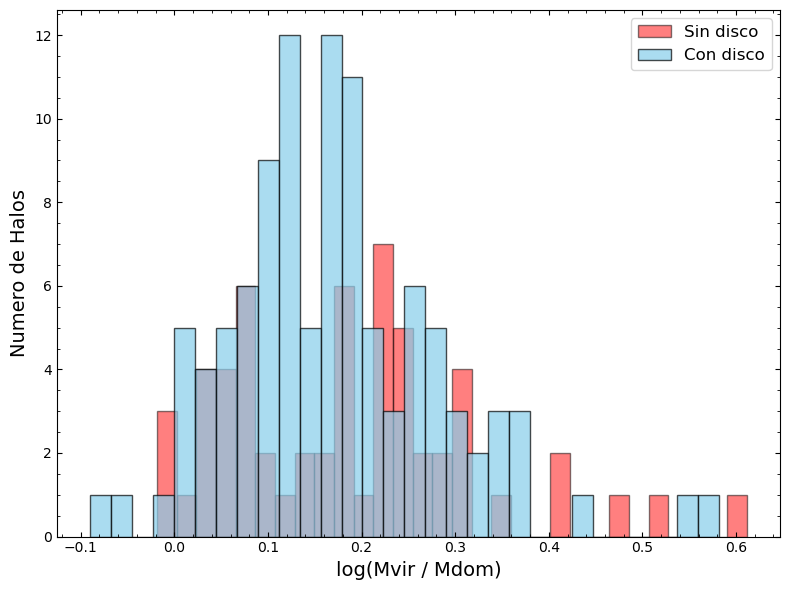

In [ ]:
#histograma de Mvir/Mdom para halos con y sin disco
plt.figure(figsize=(8,6))
plt.hist(np.log10(z0_df[z0_df['has_disk'] == 0]['Mvir_Mdom_ratio']), bins=30, color='red', edgecolor='black', alpha=0.5, label='Sin disco')
#plt.hist(np.log10(z0_df[z0_df['has_disk'] == 0]['Mvir_Mdom_ratio']), bins=30, color='salmon', edgecolor='black', alpha=0.7, label='No disk')
plt.hist(np.log10(z0_df[z0_df['has_disk'] == 1]['Mvir_Mdom_ratio']), bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Con disco')
#plt.hist(np.log10(z0_df[z0_df['has_disk'] == 1]['Mvir_Mdom_ratio']), bins=30, color='skyblue', edgecolor='black', alpha=0.5, label='Disk')
plt.xlabel('log(Mvir / Mdom)', fontsize=14)
plt.ylabel('Numero de Halos', fontsize=14)
#plt.title('Distribución de Mvir / Mdom en halos con y sin disco', fontsize=16)
plt.legend(fontsize=12)
#mostrar los ticks secundarios entre los ticks principales
plt.minorticks_on()
#mostrar los ticks de arriba y la derecha hacia adentro
plt.tick_params(axis='both', which='both', top=True, right=True, direction='in')
plt.tight_layout()

plt.savefig(results_path + 'Mvir_Mdom_histogram_disk_nodisk_T3.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from scipy.stats import ks_2samp

# Extraer las distribuciones de Mvir_Mdom_ratio para halos con y sin disco
mvir_mdom_disk = z0_df[z0_df['has_disk'] == 1]['Mvir_Mdom_ratio']
mvir_mdom_nodisk = z0_df[z0_df['has_disk'] == 0]['Mvir_Mdom_ratio']

# Realizar el test de Kolmogorov-Smirnov
ks_stat, p_value = ks_2samp(mvir_mdom_disk, mvir_mdom_nodisk)

print(f"Test de Kolmogorov-Smirnov:")
print(f"Estadístico KS: {ks_stat:.4f}")
print(f"p-valor: {p_value:.4f}")
if p_value < 0.05:
    print("Conclusión: Las distribuciones son significativamente diferentes (p < 0.05)")
else:
    print("Conclusión: No hay evidencia suficiente de que las distribuciones sean diferentes (p ≥ 0.05)")

Test de Kolmogorov-Smirnov:
Estadístico KS: 0.1626
p-valor: 0.2429
Conclusión: No hay evidencia suficiente de que las distribuciones sean diferentes (p ≥ 0.05)


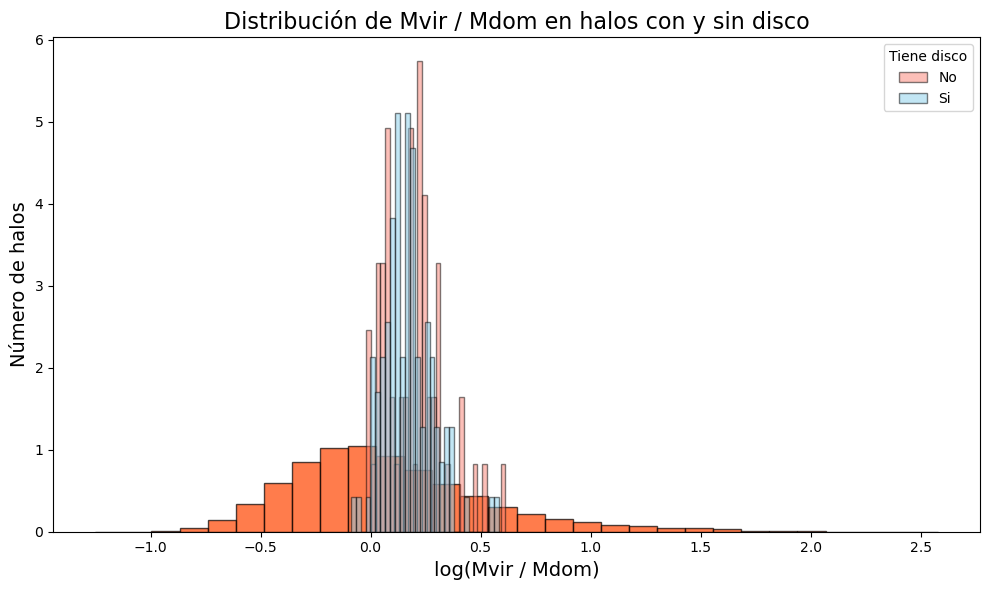

In [ ]:
#histograma de Mvir/Mdom para halos con y sin disco
plt.figure(figsize=(10,6))

plt.hist(np.log10(halo3_z0['Mvir']/halo3_z0['Mdom']), bins=30, color='orangered', edgecolor='black',alpha=0.7,density=1)
plt.hist(np.log10(z0_df[z0_df['has_disk'] == 0]['Mvir_Mdom_ratio']), bins=30, color='salmon', edgecolor='black', alpha=0.5 ,density=1,label='No')
plt.hist(np.log10(z0_df[z0_df['has_disk'] == 1]['Mvir_Mdom_ratio']), bins=30, color='skyblue', edgecolor='black', alpha=0.5 ,density=1,label='Si')

plt.xlabel('log(Mvir / Mdom)', fontsize=14)
plt.ylabel('Número de halos', fontsize=14)
plt.title('Distribución de Mvir / Mdom en halos con y sin disco', fontsize=16)
plt.legend(title='Tiene disco')
plt.tight_layout()
#plt.savefig('Mvir_Mdom_histogram_disk_nodisk.png', dpi=300)
plt.show()

### Quitando outliers de la manera mas horrible posible

#### Halos con disco (naranja)

In [ ]:
#quitar la de mas abajo
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (4.01 in row['z']) & (row['has_disk'] == 1)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][-1])
        IDXS.append(i)

#Encontrar el indice con menor masa
min_Mvir = min(Mvirs)
min_index = Mvirs.index(min_Mvir)
min_halo = IDXS[min_index]
print(f"El halo con menor masa en z=4.01 es el índice {min_halo} con Mvir/Mvir0 = {min_Mvir}")

El halo con menor masa en z=4.01 es el índice 12 con Mvir/Mvir0 = 1.1978295556684003e-05


In [ ]:
#Eliminar el halo con menor masa en z=4.01
history_accretion = history_accretion.drop(index=min_halo).reset_index(drop=True)

In [ ]:
#quitar la segunda de mas abajo
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (4.01 in row['z']) & (row['has_disk'] == 1)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][-1])
        IDXS.append(i)

#Encontrar el indice con menor masa
min_Mvir = min(Mvirs)
min_index = Mvirs.index(min_Mvir)
min_halo = IDXS[min_index]
print(f"El halo con menor masa en z=4.01 es el índice {min_halo} con Mvir/Mvir0 = {min_Mvir}")

El halo con menor masa en z=4.01 es el índice 2 con Mvir/Mvir0 = 0.002681651319022898


In [ ]:
#Eliminar el halo con menor masa en z=4.01
history_accretion = history_accretion.drop(index=min_halo).reset_index(drop=True)

#### Halos sin disco (azul)

In [ ]:
#limpiar halos que no tienen disco outliers
#quitar la de mas arriba
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (4.01 in row['z']) & (row['has_disk'] == 0)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][-1])
        IDXS.append(i)

#Encontrar el indice con mayor masa
max_Mvir = max(Mvirs)
max_index = Mvirs.index(max_Mvir)
max_halo = IDXS[max_index]
print(f"El halo con mayor masa en z=4.01 es el índice {max_halo} con Mvir/Mvir0 = {max_Mvir}")

El halo con mayor masa en z=4.01 es el índice 139 con Mvir/Mvir0 = 0.3177255198205521


In [ ]:
#Eliminar el halo con menor masa en z=4.01
history_accretion = history_accretion.drop(index=max_halo).reset_index(drop=True)

In [ ]:
history_accretion['Mdom/Mdom0'] = history_accretion.apply(lambda row: np.log10(row['Mdom']/row['Mdom'][row['z'] == 0]), axis=1)

In [ ]:
# Separar halos según si Mdom/Mdom0 aumenta o siempre disminuye
halos_Mdomup = []
halos_Mdomdown = []

for i, row in history_accretion.iterrows():
    # Calcular Mdom/Mdom0 para cada z
    mdom_ratio = row['Mdom'] / row['Mdom'][row['z'] == 0]
    
    # Verificar si algún valor es mayor a 1 (excluyendo z=0 que siempre es 1)
    if np.any(mdom_ratio[1:] > 1):
        halos_Mdomup.append(i)
    else:
        halos_Mdomdown.append(i)

# Crear los DataFrames
halos_Mdomup = history_accretion.loc[halos_Mdomup].reset_index(drop=True)
halos_Mdomdown = history_accretion.loc[halos_Mdomdown].reset_index(drop=True)

print(f"Halos con Mdom/Mdom0 > 1 en algún z: {len(halos_Mdomup)}")
print(f"Halos con Mdom/Mdom0 ≤ 1 en algún z: {len(halos_Mdomdown)}")

Halos con Mdom/Mdom0 > 1 en algún z: 101
Halos con Mdom/Mdom0 ≤ 1 en algún z: 59


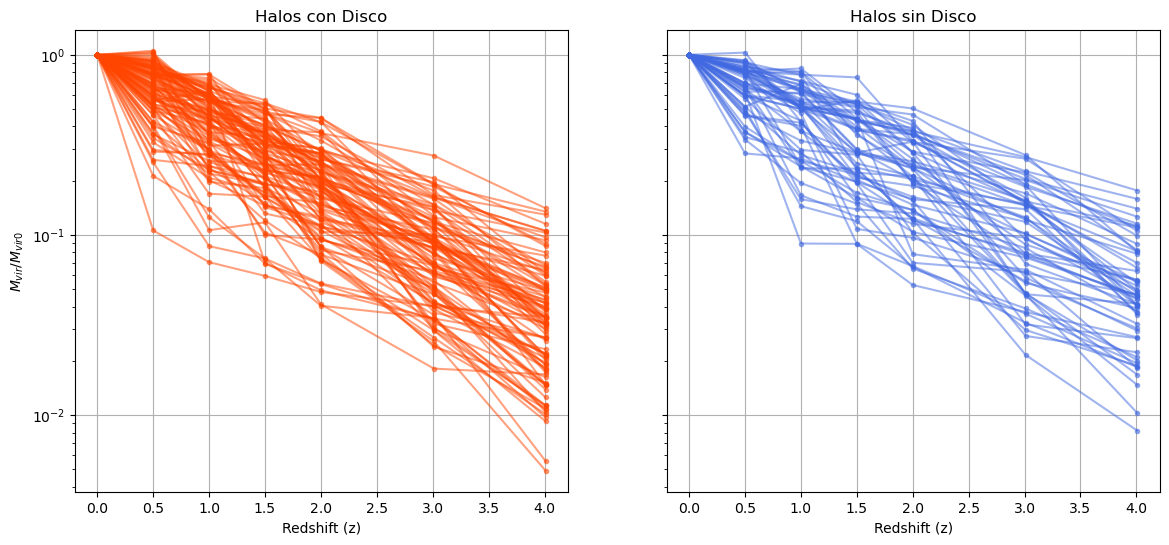

In [ ]:
#grafica de Mvir vs z para halos con y sin disco
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Halos con disco
mask_disk = history_accretion['has_disk'] == 1
for i, row in history_accretion[mask_disk].iterrows():
    #dividiendo por la masa en z=0
    axs[0].plot(row['z'], row['Mvir']/row['Mvir'][row['z']==0], marker='.', linestyle='-', alpha=0.5, color='orangered')
axs[0].set_title('Halos con Disco')
axs[0].set_xlabel('Redshift (z)')
axs[0].set_ylabel('$M_{vir}$/$M_{vir0}$')
axs[0].set_yscale('log')
axs[0].grid(True)

# Halos sin disco
mask_nodisk = history_accretion['has_disk'] == 0
for i, row in history_accretion[mask_nodisk].iterrows():
    axs[1].plot(row['z'], row['Mvir']/row['Mvir'][row['z']==0], marker='.', linestyle='-', alpha=0.5, color='royalblue')
axs[1].set_title('Halos sin Disco')
axs[1].set_xlabel('Redshift (z)')
axs[1].set_yscale('log')
axs[1].grid(True)

In [ ]:
history_accretion.head()

halo_id                          snap  \
0        [1, 1, 3, 2, 1, 0, 8]  [99, 67, 50, 40, 33, 25, 21]   
1      [2, 2, 2, 3, 4, 16, 13]  [99, 67, 50, 40, 33, 25, 21]   
2  [4, 10, 25, 41, 33, 23, 27]  [99, 67, 50, 40, 33, 25, 21]   
3     [5, 8, 10, 9, 6, 10, 20]  [99, 67, 50, 40, 33, 25, 21]   
4    [6, 5, 6, 15, 18, 17, 17]  [99, 67, 50, 40, 33, 25, 21]   

                                       z  \
0  [0.0, 0.5, 1.0, 1.5, 2.0, 3.01, 4.01]   
1  [0.0, 0.5, 1.0, 1.5, 2.0, 3.01, 4.01]   
2  [0.0, 0.5, 1.0, 1.5, 2.0, 3.01, 4.01]   
3  [0.0, 0.5, 1.0, 1.5, 2.0, 3.01, 4.01]   
4  [0.0, 0.5, 1.0, 1.5, 2.0, 3.01, 4.01]   

                                                Mdom  \
0  [4486.70147182, 4043.95089966, 3420.44057855, ...   
1  [3289.3646289, 3448.49933087, 3782.05287027, 2...   
2  [2294.94337426, 661.52690158, 471.78453508, 32...   
3  [1576.24642926, 1481.60256171, 1222.37016631, ...   
4  [1930.38444083, 2039.05155665, 1567.69042987, ...   

                                                Mvir  \
0  [7451.42138672, 4386.43115234, 2622.07202148, ...   
1  [5196.79931641, 3809.56542969, 2967.62475586, ...   
2  [3279.32080078, 697.64556885, 455.49746704, 22...   
3  [1844.44311523, 1330.6953125, 734.99511719, 69...   
4  [3006.94116211, 2227.3269043, 1323.66748047, 5...   

                                                Rvir  \
0  [855.5769043, 809.34417725, 712.26452637, 661....   
1  [758.74212646, 772.17987061, 742.26080322, 580...   
2  [650.79675293, 438.50247192, 397.43258667, 321...   
3  [537.22027588, 543.79864502, 466.13973999, 465...   
4  [632.26092529, 645.66772461, 567.12854004, 430...   

                                          Mvir_ratio  has_disk  \
0  [1.0, 0.5886703924914974, 0.3518888391083457, ...         1   
1  [1.0, 0.7330599466599541, 0.571048558001671, 0...         1   
2  [1.0, 0.21274087264779407, 0.13889994139385756...         1   
3  [1.0, 0.7214618339335793, 0.3984916157733316, ...         1   
4  [1.0, 0.7407284626537431, 0.4402039844175633, ...         1   

                                          Mdom/Mdom0  
0  [0.0, -0.045121300290604086, -0.11784512411409...  
1  [0.0, 0.020518127988365206, 0.0606155775952245...  
2  [0.0, -0.5402244643111833, -0.6870282733925318...  
3  [0.0, -0.0268923955166744, -0.1104213739721973...  
4  [0.0, 0.023784398448985423, -0.090383501286131...

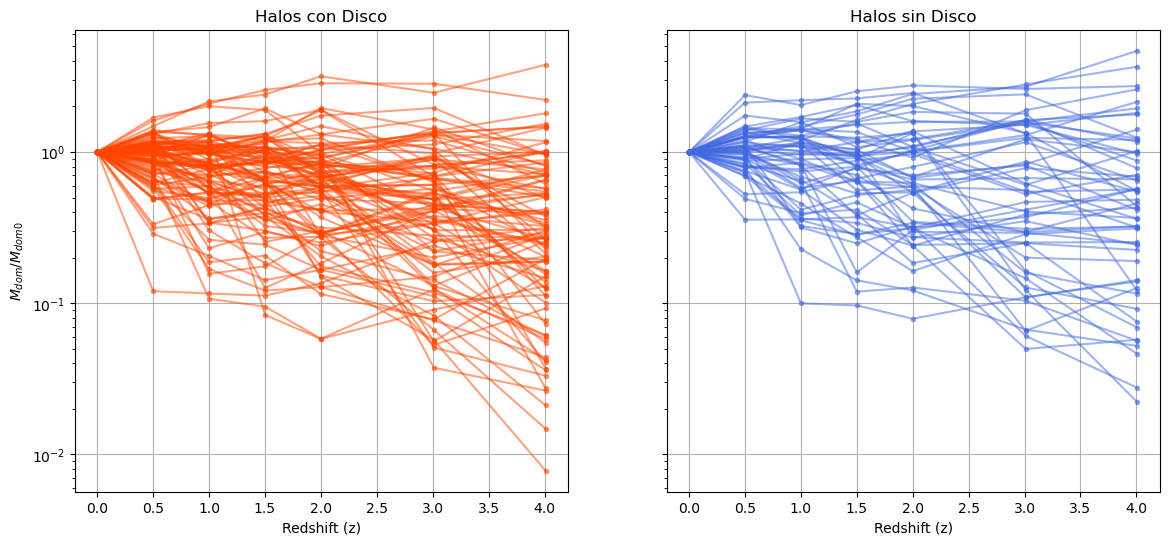

In [ ]:
#grafica de Mdom vs z para halos con y sin disco
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Halos con disco
mask_disk = history_accretion['has_disk'] == True
for i, row in history_accretion[mask_disk].iterrows():
    #dividiendo por la masa en z=0
    axs[0].plot(row['z'], row['Mdom']/row['Mdom'][row['z'] == 0], marker='.', linestyle='-', alpha=0.5, color='orangered')
    
axs[0].set_title('Halos con Disco')
axs[0].set_xlabel('Redshift (z)')
axs[0].set_ylabel('$M_{dom}$/$M_{dom0}$')
axs[0].set_yscale('log')
axs[0].grid(True)

# Halos sin disco
mask_nodisk = history_accretion['has_disk'] == False
for i, row in history_accretion[mask_nodisk].iterrows():
    axs[1].plot(row['z'], row['Mdom']/row['Mdom'][row['z'] == 0], marker='.', linestyle='-', alpha=0.5, color='royalblue')
axs[1].set_title('Halos sin Disco')
axs[1].set_xlabel('Redshift (z)')
axs[1].set_yscale('log')
axs[1].grid(True)

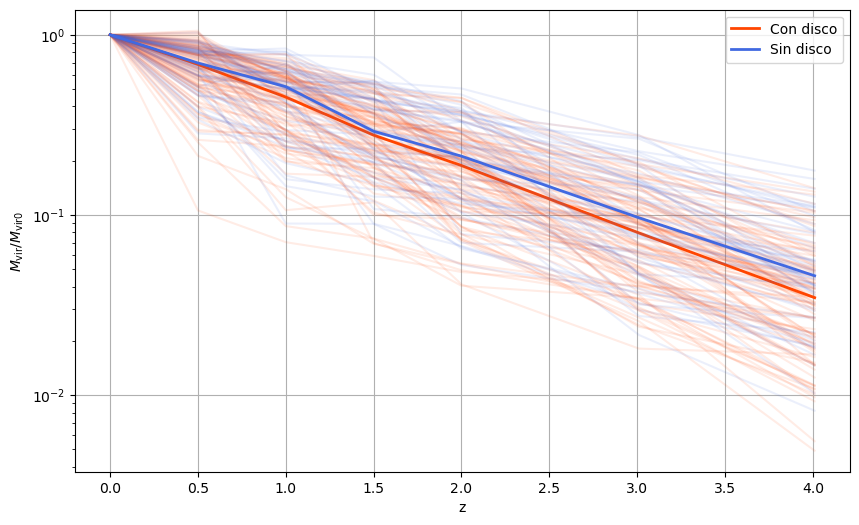

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

# Funcion para graficar grupos
def plot_group(halos, color, label):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        #normalizar por la masa en z=0
        mvir = np.array(row['Mvir'])/row['Mvir'][row['z'] == 0]
        ax.plot(z, mvir, color=color, alpha=0.1)

    # Mediana en cada z
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            #normalizar por la masa en z=0
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = sorted(mvir_by_z.keys())
    mvir_median = [np.median(mvir_by_z[zz]) for zz in z_vals]

    # Curva de la mediana
    ax.plot(z_vals, mvir_median, color=color, lw=2, label=label)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(halos_disk, color='orangered', label='Con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(halos_nodisk, color='royalblue', label='Sin disco')

ax.set_xlabel("z")
ax.set_ylabel(r"$M_{\rm vir}/M_{\rm vir0}$")
ax.legend()
ax.set_yscale('log')
ax.grid(True)
plt.show()


### Mdom

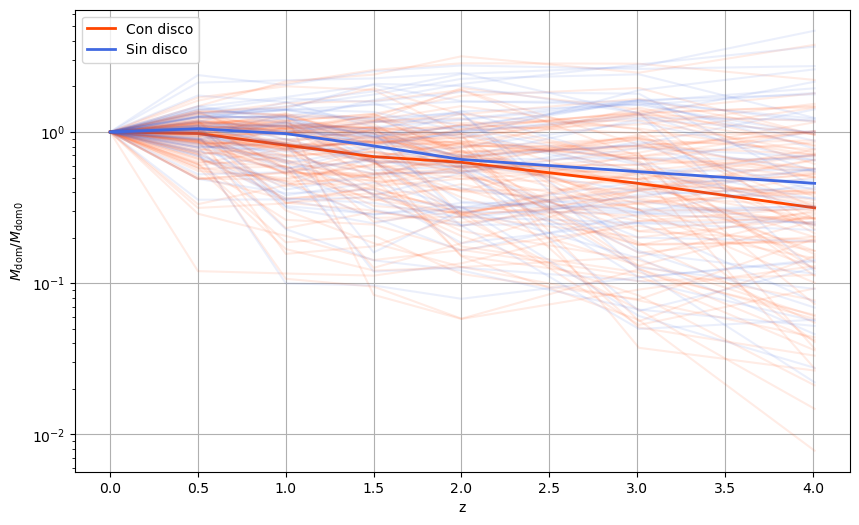

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

# Funcion para graficar grupos
def plot_group(halos, color, label):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        #normalizar por la masa en z=0
        mdom = np.array(row['Mdom'])/row['Mdom'][row['z'] == 0]
        ax.plot(z, mdom, color=color, alpha=0.1)

    # Mediana en cada z
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            #normalizar por la masa en z=0
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = sorted(mdom_by_z.keys())
    mdom_median = [np.median(mdom_by_z[zz]) for zz in z_vals]

    # Curva de la mediana
    ax.plot(z_vals, mdom_median, color=color, lw=2, label=label)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(halos_disk, color='orangered', label='Con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(halos_nodisk, color='royalblue', label='Sin disco')

ax.set_xlabel("z")
ax.set_ylabel(r"$M_{\rm dom}/M_{\rm dom0}$")
ax.legend()
ax.set_yscale('log')
ax.grid(True)
plt.show()


In [ ]:
# fig, ax = plt.subplots(figsize=(10,6))

# # Funcion para graficar grupos
# def plot_group(halos, color, label):
#     # Historias individuales
#     for i, row in halos.iterrows():
#         z = np.array(row['z'])

#         m_vir_dom = np.array(row['Mvir']/row['Mdom'])
#         ax.plot(z, m_vir_dom, color=color, alpha=0.1)

#     # Mediana en cada z
#     m_vir_dom_by_z = {}
#     for i, row in halos.iterrows():
#         for zz, m in zip(row['z'], row['Mvir']/row['Mdom']):
#             if zz not in m_vir_dom_by_z:
#                 m_vir_dom_by_z[zz] = []
#             m_vir_dom_by_z[zz].append(m)

#     z_vals = sorted(m_vir_dom_by_z.keys())
#     m_vir_dom_median = [np.median(m_vir_dom_by_z[zz]) for zz in z_vals]

#     # Curva de la mediana
#     ax.plot(z_vals, m_vir_dom_median, color=color, lw=2, label=label)

# # Halos con disco
# halos_disk = history_accretion[history_accretion['has_disk'] == 1]
# plot_group(halos_disk, color='orangered', label='Con disco')

# # Halos sin disco
# halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
# plot_group(halos_nodisk, color='royalblue', label='Sin disco')

# ax.set_xlabel("z")
# ax.set_ylabel(r"$M_{\rm vir}/M_{\rm dom}$")
# ax.legend()
# ax.set_yscale('log')
# ax.grid(True)

### Mvir

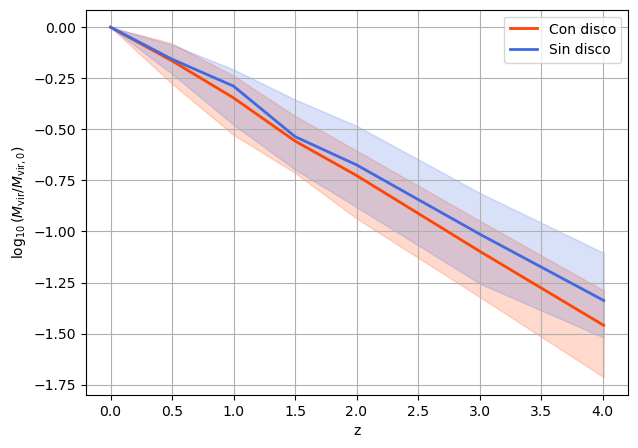

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

# Función para graficar grupos con dispersión
def plot_group(halos, color, label):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir = np.array(row['Mvir']/row['Mvir'][row['z'] == 0])

    # Agrupar por z
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = sorted(mvir_by_z.keys())
    mvir_median = [np.median(mvir_by_z[zz]) for zz in z_vals]
    mvir_q25    = [np.percentile(mvir_by_z[zz], 25) for zz in z_vals]
    mvir_q75    = [np.percentile(mvir_by_z[zz], 75) for zz in z_vals]

    # Mediana
    ax.plot(z_vals, np.log10(mvir_median), color=color, lw=2, label=label)
    # Banda de dispersión
    ax.fill_between(z_vals, np.log10(mvir_q25), np.log10(mvir_q75),
                    color=color, alpha=0.2)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(halos_disk, color='orangered', label='Con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(halos_nodisk, color='royalblue', label='Sin disco')

ax.set_xlabel("z")
ax.set_ylabel(r"$\log_{10}(M_{\rm vir}/M_{\rm vir,0})$")
ax.legend()
ax.grid(True)
plt.show()


### Mdom

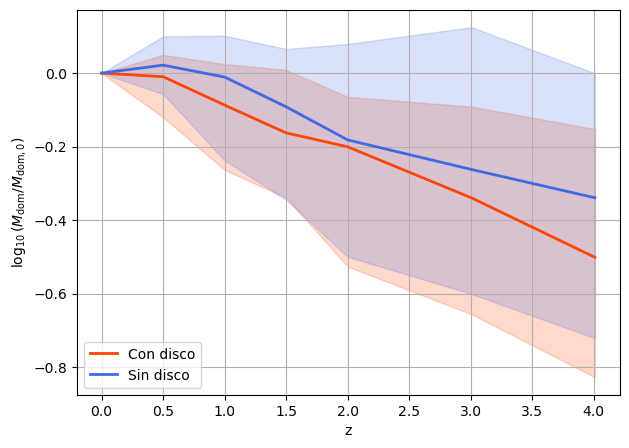

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

# Función para graficar
def plot_group(halos, color, label):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mdom = np.array(row['Mdom']/row['Mdom'][row['z'] == 0])

    # Agrupar por z
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = sorted(mdom_by_z.keys())
    mdom_median = [np.median(mdom_by_z[zz]) for zz in z_vals]
    mdom_q25    = [np.percentile(mdom_by_z[zz], 25) for zz in z_vals]
    mdom_q75    = [np.percentile(mdom_by_z[zz], 75) for zz in z_vals]

    # Mediana
    ax.plot(z_vals, np.log10(mdom_median), color=color, lw=2, label=label)
    # Banda de dispersión
    ax.fill_between(z_vals, np.log10(mdom_q25), np.log10(mdom_q75),
                    color=color, alpha=0.2)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(halos_disk, color='orangered', label='Con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(halos_nodisk, color='royalblue', label='Sin disco')

ax.set_xlabel("z")
ax.set_ylabel(r"$\log_{10}(M_{\rm dom}/M_{\rm dom,0})$")
ax.legend()
ax.grid(True)
plt.show()


### Mvir/Mdom

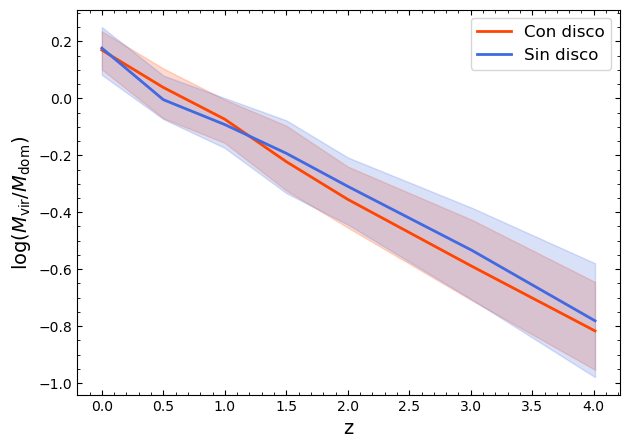

In [ ]:
#mvir/mdom vs z con dispersión para halos con y sin disco
fig, ax = plt.subplots(figsize=(7,5))

# Función para graficar grupos con dispersión
def plot_group(halos, color, label):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir_mdom = np.array(row['Mvir']/row['Mdom'])

    # Agrupar por z
    mvir_mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']/row['Mdom']):
            if zz not in mvir_mdom_by_z:
                mvir_mdom_by_z[zz] = []
            mvir_mdom_by_z[zz].append(m)

    z_vals = sorted(mvir_mdom_by_z.keys())
    mvir_mdom_median = [np.median(mvir_mdom_by_z[zz]) for zz in z_vals]
    mvir_mdom_q25    = [np.percentile(mvir_mdom_by_z[zz], 25) for zz in z_vals]
    mvir_mdom_q75    = [np.percentile(mvir_mdom_by_z[zz], 75) for zz in z_vals]

    # Mediana
    ax.plot(z_vals, np.log10(mvir_mdom_median), color=color, lw=2, label=label)
    # Banda de dispersión
    ax.fill_between(z_vals, np.log10(mvir_mdom_q25), np.log10(mvir_mdom_q75),
                    color=color, alpha=0.2)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(halos_disk, color='orangered', label='Con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(halos_nodisk, color='royalblue', label='Sin disco')

ax.set_xlabel("z", fontsize=14)
ax.set_ylabel(r"$\log(M_{\rm vir}/M_{\rm dom})$", fontsize=14)
#mostrar los ticks secundarios entre los ticks principales
plt.minorticks_on()
#mostrar los ticks de arriba y la derecha hacia adentro
plt.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend(fontsize=12)
#ax.grid(True)
plt.savefig(results_path + 'Mvir_Mdom_vs_z_disk_nodisk_T3.png', dpi=300, bbox_inches='tight')
plt.show()

### Mvir

In [ ]:
#fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

def plot_group(ax, halos, color, title, outlier_indices=[]):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir = np.array(row['Mvir'])/row['Mvir'][row['z'] == 0]
        ax.plot(z, np.log10(mvir), color=color, alpha=0.1)
        if i in outlier_indices:
            ax.plot(z, np.log10(mvir), color='red', alpha=0.7)

    # Agrupar por z
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = np.array(sorted(mvir_by_z.keys()))
    mvir_median = np.array([np.median(mvir_by_z[zz]) for zz in z_vals])
    mvir_q25    = np.array([np.percentile(mvir_by_z[zz], 25) for zz in z_vals])
    mvir_q75    = np.array([np.percentile(mvir_by_z[zz], 75) for zz in z_vals])

    # Puntos de la mediana con barras de error
    ax.errorbar(z_vals, np.log10(mvir_median),
                yerr=[np.log10(mvir_median)-np.log10(mvir_q25),
                      np.log10(mvir_q75)-np.log10(mvir_median)],
                fmt='o', color='black', ecolor='black', capsize=3,
                label='Mediana ± IQR')

    #ax.set_title(title)
    ax.set_xlabel("z")
    ax.grid(True)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
#plot_group(axs[0], halos_disk, color='orangered', title='Halos con disco')
#plot_group(axs[0], halos_disk, color='orangered', title='Halos with disk')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
#plot_group(axs[1], halos_nodisk, color='royalblue', title='Halos sin disco')
#plot_group(axs[1], halos_nodisk, color='royalblue', title='Halos without disk')

# axs[0].set_ylabel(r"$\log(M_{\rm vir}/M_{\rm vir,0})$")
# axs[0].legend(['Disk'], markerscale = 3)
# axs[1].legend(['No disk'], markerscale = 3)

# plt.tight_layout()
# plt.show()



Con disco:
log(Mvir/Mvir0) = -0.3670*z + 0.0084
R² = 0.9996

Sin disco:
log(Mvir/Mvir0) = -0.3381*z + 0.0080
R² = 0.9976



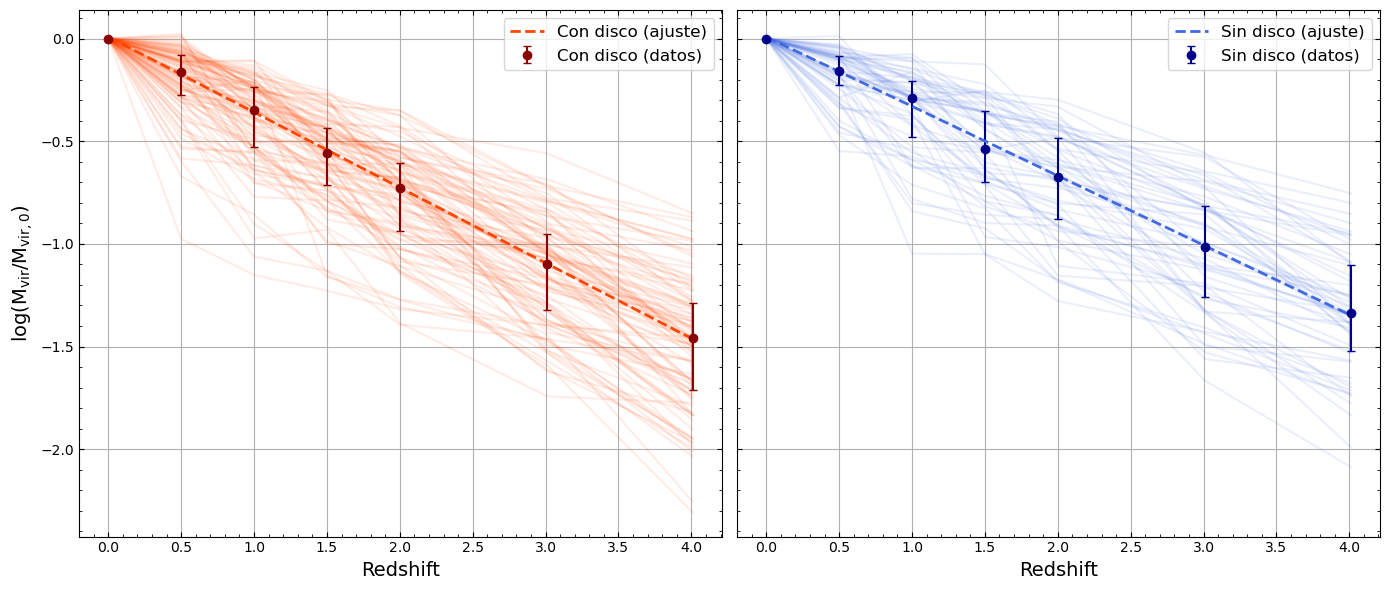

In [ ]:
from scipy.optimize import curve_fit

# Ajuste lineal a las curvas de Mvir/Mvir0 vs z en escala logarítmica

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

def linear_fit(z, a, b):
    """Función lineal: y = a*z + b"""
    return a*z + b

def other_fit(z, a, b):
    """Función: y = b*ln(1+z) + a*z"""
    return b*np.log(1+z) + a*z

def plot_group_with_fit(ax, halos, color, color2, label):
    # Agrupar por z para obtener medianas

    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir = np.array(row['Mvir'])/row['Mvir'][row['z'] == 0]
        ax.plot(z, np.log10(mvir), color=color, alpha=0.1)
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = np.array(sorted(mvir_by_z.keys()))
    

    mvir_median = np.array([np.median(mvir_by_z[zz]) for zz in z_vals])
    mvir_q25    = np.array([np.percentile(mvir_by_z[zz], 25) for zz in z_vals])
    mvir_q75    = np.array([np.percentile(mvir_by_z[zz], 75) for zz in z_vals])

    # Puntos de la mediana con barras de error
    ax.errorbar(z_vals, np.log10(mvir_median),
                yerr=[np.log10(mvir_median)-np.log10(mvir_q25),
                      np.log10(mvir_q75)-np.log10(mvir_median)],
                fmt='o', color=color2, ecolor=color2, capsize=3, label= label + ' (datos)')


    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log10(mvir_median))
    
    # Crear curva suave para el ajuste
    z_smooth = np.linspace(z_vals.min(), z_vals.max(), 200)
    fit_smooth = linear_fit(z_smooth, *popt)
    
    # Graficar datos originales
    #ax.plot(z_vals, np.log10(mvir_median), 'o', color=color, label=f'{label} (data)')
    
    # Graficar ajuste
    ax.plot(z_smooth, fit_smooth, '--', color=color, linewidth=2, 
            label=f'{label} (ajuste)')
    
    ax.set_xlabel("Redshift", fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=12)
    #mostrar los ticks secundarios entre los ticks principales
    ax.minorticks_on()
    #mostrar los ticks de arriba y la derecha hacia adentro
    ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
    # Mostrar ecuación del ajuste
    print(f"{label}:")
    print(f"log(Mvir/Mvir0) = {popt[0]:.4f}*z + {popt[1]:.4f}")
    print(f"R² = {1 - np.var(np.log10(mvir_median) - linear_fit(z_vals, *popt))/np.var(np.log10(mvir_median)):.4f}")
    print()

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group_with_fit(axs[0], halos_disk, color='orangered', color2='darkred', label='Con disco')
#axs[0].set_title('Halos con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group_with_fit(axs[1], halos_nodisk, color='royalblue', color2='darkblue', label='Sin disco')
#axs[1].set_title('Halos sin disco')

axs[0].set_ylabel(r"$\log(\rm{M}_{\rm vir}/\rm{M}_{\rm vir,0})$", fontsize=14)

plt.tight_layout()
plt.savefig(results_path + 'Mvir_Mvir0_fit_disk_nodisk_T2.png', dpi=300, bbox_inches='tight')
plt.show()

Tipo 1:
log(Mvir/Mvir0) = -0.3641*z + 0.0557
R² = 0.9956

Tipo 2:
log(Mvir/Mvir0) = -0.3746*z + -0.0921
R² = 0.9890

Tipo 1:
log(Mvir/Mvir0) = -0.3143*z + 0.0572
R² = 0.9875

Tipo 2:
log(Mvir/Mvir0) = -0.3398*z + -0.1472
R² = 0.9556



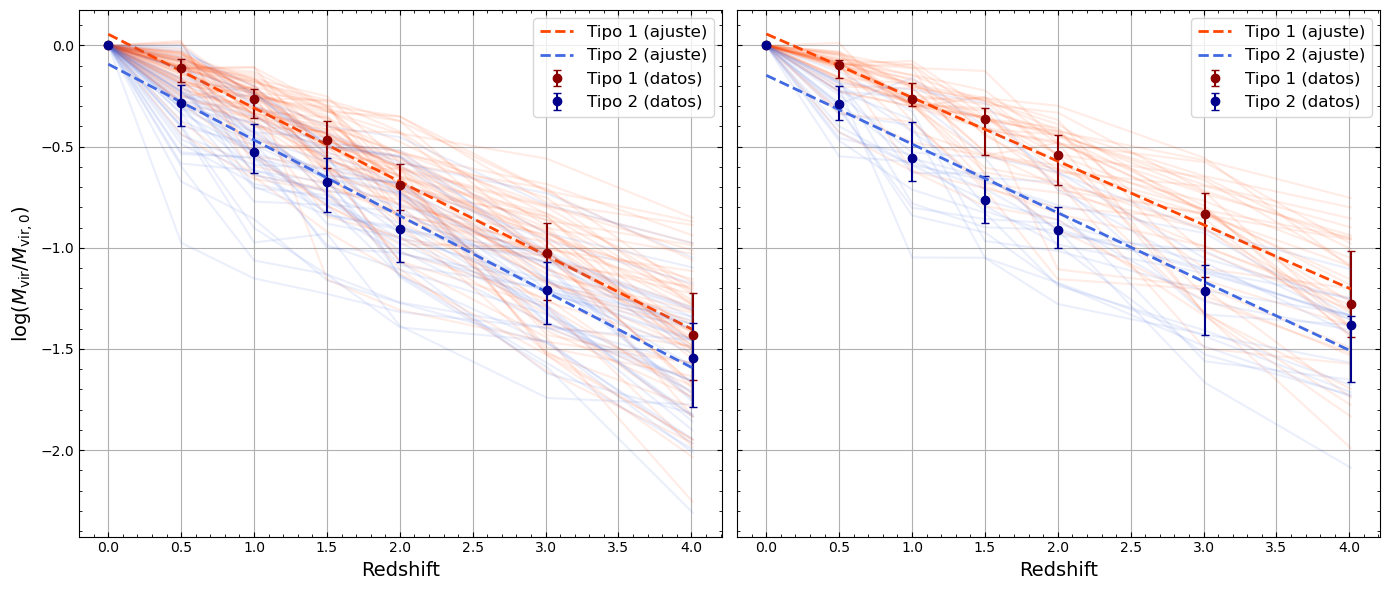

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plot_group_with_fit(axs[0], halos_Mdomup[halos_Mdomup['has_disk'] == 1], color='orangered', color2='darkred', label='Tipo 1')
plot_group_with_fit(axs[0], halos_Mdomdown[halos_Mdomdown['has_disk'] == 1], color='royalblue', color2='darkblue', label='Tipo 2')
#axs[0].set_title('Halos con disco')

plot_group_with_fit(axs[1], halos_Mdomup[halos_Mdomup['has_disk'] == 0], color='orangered', color2='darkred', label='Tipo 1')
plot_group_with_fit(axs[1], halos_Mdomdown[halos_Mdomdown['has_disk'] == 0], color='royalblue', color2='darkblue', label='Tipo 2')
#axs[1].set_title('Halos sin disco')

axs[0].set_ylabel(r"$\log(M_{\rm vir}/M_{\rm vir,0})$", fontsize=14)
plt.tight_layout()
plt.savefig(results_path + 'Mvir_Mvir0_fit_accretion_types_disk_nodisk_T2.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from scipy.stats import ttest_ind
from scipy.optimize import curve_fit
import scipy.stats as stats

# Realizar pruebas de hipótesis para comparar las curvas Type 1 vs Type 2 
# tanto para halos con disco como sin disco


def linear_fit(z, a, b):
    """Función lineal: y = a*z + b"""
    return a*z + b

def fit_group_parameters(halos):
    """Ajusta la curva lineal y devuelve parámetros con errores"""
    # Agrupar por z para obtener medianas
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = np.array(sorted(mvir_by_z.keys()))
    mvir_median = np.array([np.median(mvir_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log10(mvir_median))
    perr = np.sqrt(np.diag(pcov))  # errores estándar
    
    return popt, perr

def test_parameters(group1, group2, label1, label2):
    """Realiza test de hipótesis para comparar parámetros entre dos grupos"""
    popt1, perr1 = fit_group_parameters(group1)
    popt2, perr2 = fit_group_parameters(group2)
    
    print(f"\n=== Comparación {label1} vs {label2} ===")
    
    # Test para parámetro 'a' (pendiente)
    diff_a = popt1[0] - popt2[0]
    se_a = np.sqrt(perr1[0]**2 + perr2[0]**2)
    t_stat_a = diff_a / se_a
    p_val_a = 2*(1 - stats.norm.cdf(abs(t_stat_a)))
    
    print(f"Parámetro a (pendiente):")
    print(f"  {label1}: {popt1[0]:.4f} ± {perr1[0]:.4f}")
    print(f"  {label2}: {popt2[0]:.4f} ± {perr2[0]:.4f}")
    print(f"  Diferencia: {diff_a:.4f}")
    print(f"  t-statistic: {t_stat_a:.3f}")
    print(f"  p-value: {p_val_a:.4f}")
    
    if p_val_a < 0.05:
        print("  → Diferencia SIGNIFICATIVA en pendiente")
    else:
        print("  → No hay diferencia significativa en pendiente")
    
    # Test para parámetro 'b' (intercepto)
    diff_b = popt1[1] - popt2[1]
    se_b = np.sqrt(perr1[1]**2 + perr2[1]**2)
    t_stat_b = diff_b / se_b
    p_val_b = 2*(1 - stats.norm.cdf(abs(t_stat_b)))
    
    print(f"\nParámetro b (intercepto):")
    print(f"  {label1}: {popt1[1]:.4f} ± {perr1[1]:.4f}")
    print(f"  {label2}: {popt2[1]:.4f} ± {perr2[1]:.4f}")
    print(f"  Diferencia: {diff_b:.4f}")
    print(f"  t-statistic: {t_stat_b:.3f}")
    print(f"  p-value: {p_val_b:.4f}")
    
    if p_val_b < 0.05:
        print("  → Diferencia SIGNIFICATIVA en intercepto")
    else:
        print("  → No hay diferencia significativa en intercepto")

# Separar grupos según Mdom evolution y presencia de disco
type1_with_disk = halos_Mdomup[halos_Mdomup['has_disk'] == 1]
type2_with_disk = halos_Mdomdown[halos_Mdomdown['has_disk'] == 1]
type1_without_disk = halos_Mdomup[halos_Mdomup['has_disk'] == 0]
type2_without_disk = halos_Mdomdown[halos_Mdomdown['has_disk'] == 0]

print("PRUEBAS DE HIPÓTESIS PARA CURVAS MVIR/MVIR0 vs z")
print("=" * 60)

# Test para halos CON disco: Type 1 vs Type 2
test_parameters(type1_with_disk, type2_with_disk, 
               "Type 1 (con disco)", "Type 2 (con disco)")

# Test para halos SIN disco: Type 1 vs Type 2  
test_parameters(type1_without_disk, type2_without_disk,
               "Type 1 (sin disco)", "Type 2 (sin disco)")

print(f"\nTamaños de muestra:")
print(f"Type 1 con disco: {len(type1_with_disk)} halos")
print(f"Type 2 con disco: {len(type2_with_disk)} halos")
print(f"Type 1 sin disco: {len(type1_without_disk)} halos")
print(f"Type 2 sin disco: {len(type2_without_disk)} halos")

PRUEBAS DE HIPÓTESIS PARA CURVAS MVIR/MVIR0 vs z

=== Comparación Type 1 (con disco) vs Type 2 (con disco) ===
Parámetro a (pendiente):
  Type 1 (con disco): -0.3641 ± 0.0108
  Type 2 (con disco): -0.3746 ± 0.0177
  Diferencia: 0.0105
  t-statistic: 0.507
  p-value: 0.6120
  → No hay diferencia significativa en pendiente

Parámetro b (intercepto):
  Type 1 (con disco): 0.0557 ± 0.0234
  Type 2 (con disco): -0.0921 ± 0.0382
  Diferencia: 0.1478
  t-statistic: 3.300
  p-value: 0.0010
  → Diferencia SIGNIFICATIVA en intercepto

=== Comparación Type 1 (sin disco) vs Type 2 (sin disco) ===
Parámetro a (pendiente):
  Type 1 (sin disco): -0.3143 ± 0.0158
  Type 2 (sin disco): -0.3398 ± 0.0328
  Diferencia: 0.0254
  t-statistic: 0.698
  p-value: 0.4850
  → No hay diferencia significativa en pendiente

Parámetro b (intercepto):
  Type 1 (sin disco): 0.0572 ± 0.0342
  Type 2 (sin disco): -0.1472 ± 0.0708
  Diferencia: 0.2043
  t-statistic: 2.600
  p-value: 0.0093
  → Diferencia SIGNIFICATIVA en 

### Mdom

In [ ]:
#fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

def plot_group(ax, halos, color, title):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mdom = np.array(row['Mdom'])/row['Mdom'][row['z'] == 0]
        ax.plot(z, np.log10(mdom), color=color, alpha=0.1)

    # Agrupar por z
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    mdom_q25    = np.array([np.percentile(mdom_by_z[zz], 25) for zz in z_vals])
    mdom_q75    = np.array([np.percentile(mdom_by_z[zz], 75) for zz in z_vals])

    # Puntos de la mediana con barras de error
    ax.errorbar(z_vals, np.log10(mdom_median),
                yerr=[np.log10(mdom_median)-np.log10(mdom_q25),
                      np.log10(mdom_q75)-np.log10(mdom_median)],
                fmt='o', color=color, ecolor='black', capsize=3,
                label='Mediana ± IQR')

    ax.set_title(title)
    ax.set_xlabel("z")
    
    ax.grid(True)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
#plot_group(axs[0], halos_disk, color='orangered', title='Halos con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
#plot_group(axs[1], halos_nodisk, color='royalblue', title='Halos sin disco')

#axs[0].set_ylabel(r"$\log_{10}(M_{\rm dom}/M_{\rm dom,0})$")
#axs[0].legend()

#plt.tight_layout()
#plt.show()

Mdom

Con disco:
log(Mdom/Mdom0) = -0.1280*z + 0.0338
R² = 0.9864

Sin disco:
log(Mdom/Mdom0) = -0.0973*z + 0.0435
R² = 0.9519



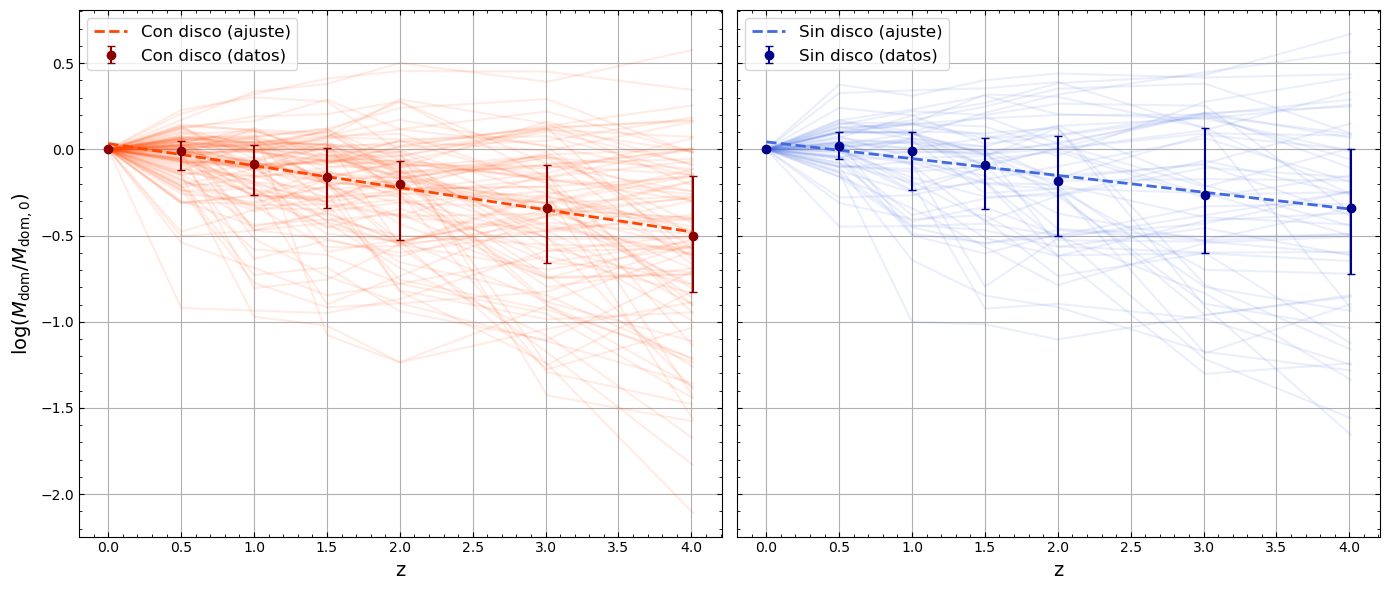

In [ ]:
# Ajuste lineal a las curvas de Mdom/Mdom0 vs z en escala logarítmica

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

def linear_fit(z, a, b):
    """Función lineal: y = a*z + b"""
    return a*z + b

def plot_group_with_fit(ax, halos, color, color2, label):
    
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mdom = np.array(row['Mdom'])/row['Mdom'][row['z'] == 0]
        ax.plot(z, np.log10(mdom), color=color, alpha=0.1)
    
    # Agrupar por z para obtener medianas
    
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    
    
    
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    mdom_q25    = np.array([np.percentile(mdom_by_z[zz], 25) for zz in z_vals])
    mdom_q75    = np.array([np.percentile(mdom_by_z[zz], 75) for zz in z_vals])

    # Puntos de la mediana con barras de error
    ax.errorbar(z_vals, np.log10(mdom_median),
                yerr=[np.log10(mdom_median)-np.log10(mdom_q25),
                      np.log10(mdom_q75)-np.log10(mdom_median)],
                fmt='o', color=color2, ecolor=color2, capsize=3,label= label + ' (datos)')
    
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log10(mdom_median))
    
    # Crear curva suave para el ajuste
    z_smooth = np.linspace(z_vals.min(), z_vals.max(), 200)
    fit_smooth = linear_fit(z_smooth, *popt)
    
    # Graficar mediana de datos
    # ax.plot(z_vals, np.log10(mdom_median), 'o', color='k', label=f'{label} (Data Median)')
    
    # Graficar ajuste
    ax.plot(z_smooth, fit_smooth, '--', color=color, linewidth=2, 
            label=f'{label} (ajuste)')
    
    ax.set_xlabel("z", fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=12)
    ax.minorticks_on()
    #mostrar los ticks de arriba y la derecha hacia adentro
    ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')

    # Mostrar ecuación del ajuste
    print(f"{label}:")
    print(f"log(Mdom/Mdom0) = {popt[0]:.4f}*z + {popt[1]:.4f}")
    print(f"R² = {1 - np.var(np.log10(mdom_median) - linear_fit(z_vals, *popt))/np.var(np.log10(mdom_median)):.4f}")
    print()

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group_with_fit(axs[0], halos_disk, color='orangered', color2='darkred', label='Con disco')
#axs[0].set_title('Halos con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group_with_fit(axs[1], halos_nodisk, color='royalblue', color2='darkblue', label='Sin disco')
#axs[1].set_title('Halos sin disco')

axs[0].set_ylabel(r"$\log(M_{\rm dom}/M_{\rm dom,0})$", fontsize=14)
plt.tight_layout()
plt.savefig(results_path + 'Mdom_Mdom0_fit_disk_nodisk_T2.png', dpi=300, bbox_inches='tight')
plt.show()

Separando por aquellos con fracción de masa por encima de 0 en algun caso

Tipo 1:
log(Mdom/Mdom0) = -0.1047*z + 0.0779
R² = 0.8909

Tipo 2:
log(Mdom/Mdom0) = -0.1311*z + -0.0725
R² = 0.9454

Tipo 1:
log(Mdom/Mdom0) = -0.0361*z + 0.0693
R² = 0.3480

Tipo 2:
log(Mdom/Mdom0) = -0.1247*z + -0.1277
R² = 0.7009



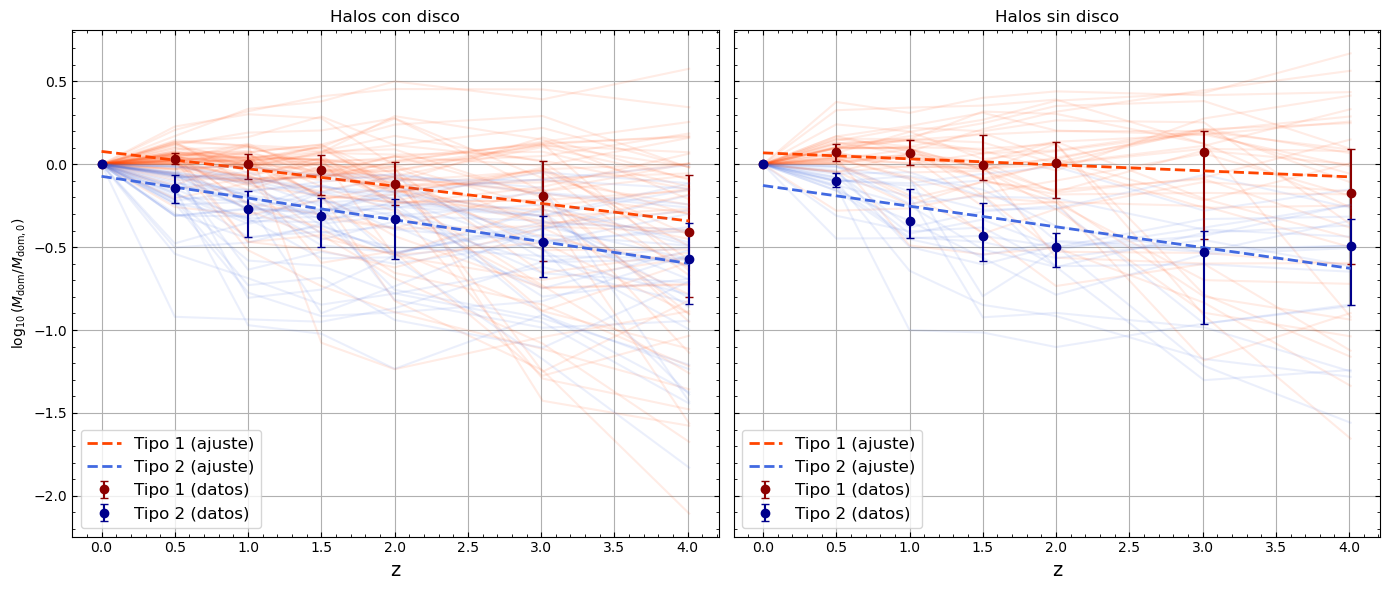

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plot_group_with_fit(axs[0], halos_Mdomup[halos_Mdomup['has_disk'] == 1], color='orangered',color2='darkred', label='Tipo 1')
plot_group_with_fit(axs[0], halos_Mdomdown[halos_Mdomdown['has_disk'] == 1], color='royalblue', color2='darkblue', label='Tipo 2')
axs[0].set_title('Halos con disco')

plot_group_with_fit(axs[1], halos_Mdomup[halos_Mdomup['has_disk'] == 0], color='orangered', color2='darkred', label='Tipo 1')
plot_group_with_fit(axs[1], halos_Mdomdown[halos_Mdomdown['has_disk'] == 0], color='royalblue', color2='darkblue', label='Tipo 2')
axs[1].set_title('Halos sin disco')

axs[0].set_ylabel(r"$\log_{10}(M_{\rm dom}/M_{\rm dom,0})$")
plt.tight_layout()
plt.show()

$M_{dom}(z)/M_{dom}(0) = a*z + b*ln(1+z)$ 

Con disco:
ln(Mdom/Mdom0) = -0.4183*z + 0.3290*ln(1+z)
R² = 0.9945

Sin disco:
ln(Mdom/Mdom0) = -0.3490*z + 0.3497*ln(1+z)
R² = 0.9549



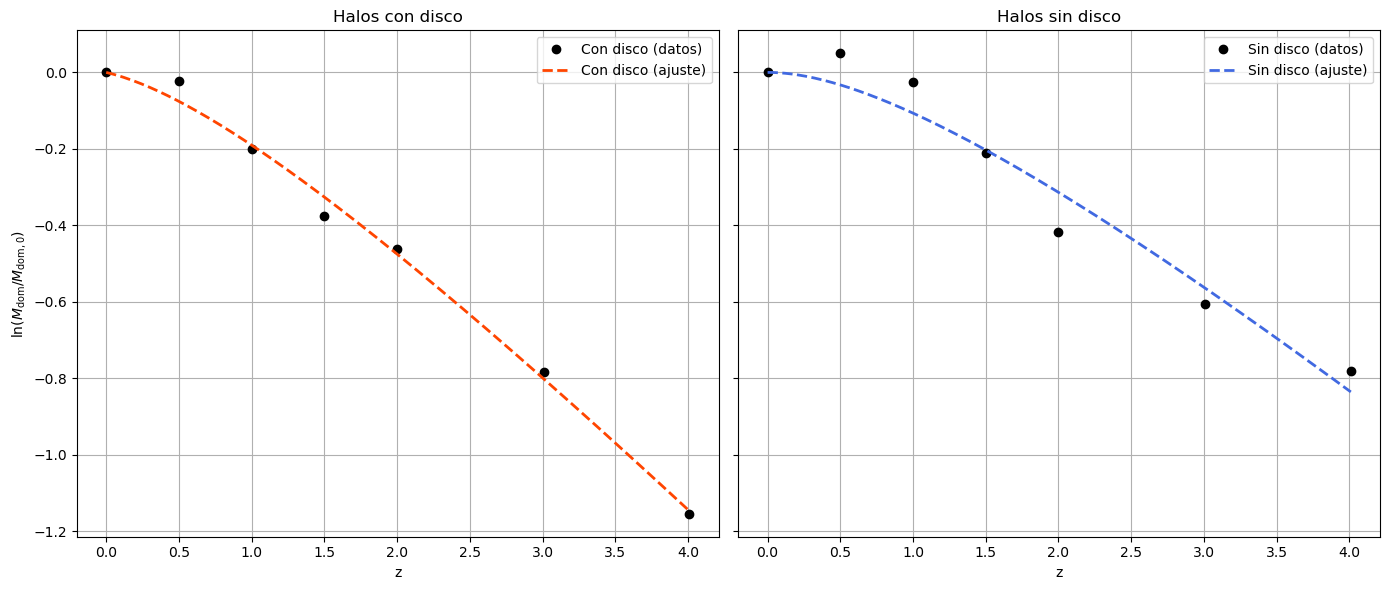

In [ ]:
# Ajuste lineal a las curvas de Mdom/Mdom0 vs z en escala logarítmica

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

def other_fit(z, a, b):
    """Función: y = b*ln(1+z) + a*z"""
    return b*np.log(1+z) + a*z

def plot_group_with_fit(ax, halos, color, label):
    # Agrupar por z para obtener medianas
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(other_fit, z_vals, np.log(mdom_median))
    
    # Crear curva suave para el ajuste
    z_smooth = np.linspace(z_vals.min(), z_vals.max(), 200)
    fit_smooth = other_fit(z_smooth, *popt)
    
    # Graficar datos originales
    ax.plot(z_vals, np.log(mdom_median), 'o', color='k', label=f'{label} (datos)')
    
    # Graficar ajuste
    ax.plot(z_smooth, fit_smooth, '--', color=color, linewidth=2, 
            label=f'{label} (ajuste)')
    
    ax.set_xlabel("z")
    ax.grid(True)
    ax.legend()
    
    # Mostrar ecuación del ajuste
    print(f"{label}:")
    print(f"ln(Mdom/Mdom0) = {popt[0]:.4f}*z + {popt[1]:.4f}*ln(1+z)")
    print(f"R² = {1 - np.var(np.log(mdom_median) - other_fit(z_vals, *popt))/np.var(np.log(mdom_median)):.4f}")
    print()

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group_with_fit(axs[0], halos_disk, color='orangered', label='Con disco')
axs[0].set_title('Halos con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group_with_fit(axs[1], halos_nodisk, color='royalblue', label='Sin disco')
axs[1].set_title('Halos sin disco')

axs[0].set_ylabel(r"$\ln(M_{\rm dom}/M_{\rm dom,0})$")
plt.tight_layout()
plt.show()

Mdom

In [ ]:
from scipy.optimize import curve_fit
from scipy import stats

# Modelo
def other_fit(z, a, b):
    return b*np.log(1+z) + a*z

def fit_group(halos):
    # Agrupar por z para obtener medianas
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(other_fit, z_vals, np.log(mdom_median))
    perr = np.sqrt(np.diag(pcov))  # errores estándar
    
    return z_vals, np.log(mdom_median), popt, perr

# Ajustar ambos grupos
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

z_disk, y_disk, popt_disk, perr_disk = fit_group(halos_disk)
z_nodisk, y_nodisk, popt_nodisk, perr_nodisk = fit_group(halos_nodisk)

# Prueba de hipótesis
def test_param(param_name, val1, err1, val2, err2):
    # H0: val1 == val2
    # H1: val1 != val2
    diff = val1 - val2
    se = np.sqrt(err1**2 + err2**2)
    t_stat = diff / se
    p_val = 2*(1 - stats.norm.cdf(abs(t_stat)))
    print(f"Prueba de hipótesis para {param_name}:")
    print(f"{param_name}_disk = {val1:.4f} ± {err1:.4f}")
    print(f"{param_name}_nodisk = {val2:.4f} ± {err2:.4f}")
    print(f"Diferencia = {diff:.4f}  |  t = {t_stat:.3f}  |  p = {p_val:.4f}")
    if p_val < 0.05:
        print("Rechazamos H0: diferencia estadísticamente significativa.")
    else:
        print("No rechazamos H0: no hay evidencia suficiente de diferencia.")

# Probar a y b
test_param("a", popt_disk[0], perr_disk[0], popt_nodisk[0], perr_nodisk[0])
test_param("b", popt_disk[1], perr_disk[1], popt_nodisk[1], perr_nodisk[1])

Prueba de hipótesis para a:
a_disk = -0.4183 ± 0.0342
a_nodisk = -0.3490 ± 0.0761
Diferencia = -0.0694  |  t = -0.831  |  p = 0.4059
No rechazamos H0: no hay evidencia suficiente de diferencia.
Prueba de hipótesis para b:
b_disk = 0.3290 ± 0.0728
b_nodisk = 0.3497 ± 0.1618
Diferencia = -0.0207  |  t = -0.117  |  p = 0.9072
No rechazamos H0: no hay evidencia suficiente de diferencia.


In [ ]:
#USANDO EL AJUSTE LINEAL PARA Mdom/Mdom0

def fit_group(halos):
    # Agrupar por z para obtener medianas
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log(mdom_median))
    perr = np.sqrt(np.diag(pcov))  # errores estándar
    
    return z_vals, np.log(mdom_median), popt, perr

# Ajustar ambos grupos
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

z_disk, y_disk, popt_disk, perr_disk = fit_group(halos_disk)
z_nodisk, y_nodisk, popt_nodisk, perr_nodisk = fit_group(halos_nodisk)

# Prueba de hipótesis
def test_param(param_name, val1, err1, val2, err2):
    # H0: val1 == val2
    # H1: val1 != val2
    diff = val1 - val2
    se = np.sqrt(err1**2 + err2**2)
    t_stat = diff / se
    p_val = 2*(1 - stats.norm.cdf(abs(t_stat)))
    print(f"Prueba de hipótesis para {param_name}:")
    print(f"{param_name}_disk = {val1:.4f} ± {err1:.4f}")
    print(f"{param_name}_nodisk = {val2:.4f} ± {err2:.4f}")
    print(f"Diferencia = {diff:.4f}  |  t = {t_stat:.3f}  |  p = {p_val:.4f}")
    if p_val < 0.05:
        print("Rechazamos H0: diferencia estadísticamente significativa.")
    else:
        print("No rechazamos H0: no hay evidencia suficiente de diferencia.")

# Probar a y b
test_param("a", popt_disk[0], perr_disk[0], popt_nodisk[0], perr_nodisk[0])

Prueba de hipótesis para a:
a_disk = -0.2947 ± 0.0155
a_nodisk = -0.2240 ± 0.0225
Diferencia = -0.0707  |  t = -2.588  |  p = 0.0097
Rechazamos H0: diferencia estadísticamente significativa.


Mvir

In [ ]:
def fit_group(halos):
    # Agrupar por z para obtener medianas
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = np.array(sorted(mvir_by_z.keys()))
    mvir_median = np.array([np.median(mvir_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log(mvir_median))
    perr = np.sqrt(np.diag(pcov))  # errores estándar
    
    return z_vals, np.log(mvir_median), popt, perr

# Ajustar ambos grupos
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

z_disk, y_disk, popt_disk, perr_disk = fit_group(halos_disk)
z_nodisk, y_nodisk, popt_nodisk, perr_nodisk = fit_group(halos_nodisk)

# --- Prueba de hipótesis ---
def test_param(param_name, val1, err1, val2, err2):
    diff = val1 - val2
    se = np.sqrt(err1**2 + err2**2)
    t_stat = diff / se
    p_val = 2*(1 - stats.norm.cdf(abs(t_stat)))
    print(f"Función Mvir/Mvir0 = az + b:")
    print(f"Prueba de hipotesis para {param_name}:")
    print(f"{param_name}_disk = {val1:.4f} ± {err1:.4f}")
    print(f"{param_name}_nodisk = {val2:.4f} ± {err2:.4f}")
    print(f"Diferencia = {diff:.4f}  |  t = {t_stat:.3f}  |  p = {p_val:.5f}")
    if p_val < 0.05:
        print("Rechazamos H0: diferencia estadísticamente significativa.")
    else:
        print("No rechazamos H0: no hay evidencia suficiente de diferencia.")

# Probar a y b
test_param("a", popt_disk[0], perr_disk[0], popt_nodisk[0], perr_nodisk[0])

Función Mvir/Mvir0 = az + b:
Prueba de hipotesis para a:
a_disk = -0.8451 ± 0.0072
a_nodisk = -0.7785 ± 0.0171
Diferencia = -0.0665  |  t = -3.579  |  p = 0.00034
Rechazamos H0: diferencia estadísticamente significativa.


### Bootstrapping

In [ ]:
def fit_group(halos):
    """Hace el ajuste a la mediana y devuelve parámetros (a, b)."""
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m / row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    # ajuste a la curva
    popt, _ = curve_fit(other_fit, z_vals, np.log(mdom_median))
    return popt  # (a, b)

# Bootstrap
def bootstrap_params(halos, n_boot=500, seed=0):
    rng = np.random.default_rng(seed)
    a_vals, b_vals = [], []
    n = len(halos)
    for _ in range(n_boot):
        sample = halos.sample(n, replace=True, random_state=rng)
        try:
            a, b = fit_group(sample)
            a_vals.append(a)
            b_vals.append(b)
        except:
            continue
    return np.array(a_vals), np.array(b_vals)

# Separar grupos
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

# Ejecutar bootstrap
a_disk, b_disk = bootstrap_params(halos_disk, n_boot=1000)
a_nodisk, b_nodisk = bootstrap_params(halos_nodisk, n_boot=1000)

# Comparación
diff_a = a_disk - a_nodisk[:, None]  # todas las diferencias posibles
p_value = (np.sum(diff_a < 0) / diff_a.size)  # probabilidad de que a_disk < a_nodisk

print(f"Media bootstrap a_disk = {np.mean(a_disk):.4f} ± {np.std(a_disk):.4f}")
print(f"Media bootstrap a_nodisk = {np.mean(a_nodisk):.4f} ± {np.std(a_nodisk):.4f}")
print(f"Probabilidad a_disk < a_nodisk = {p_value:.3f}")

Media bootstrap a_disk = -0.4343 ± 0.0914
Media bootstrap a_nodisk = -0.3556 ± 0.1246
Probabilidad a_disk < a_nodisk = 0.698


El análisis bootstrap sugiere que los halos con disco presentan una pendiente más negativa en su historia de acreción (a=−0.41) que los halos sin disco (a=−0.23), con una probabilidad del 89.5% de que esta diferencia sea real. Esto indica que, aunque la señal no alcanza el umbral clásico de significancia estadística, existe evidencia moderada de que la formación temprana de masa está asociada a la presencia de discos en las galaxias.

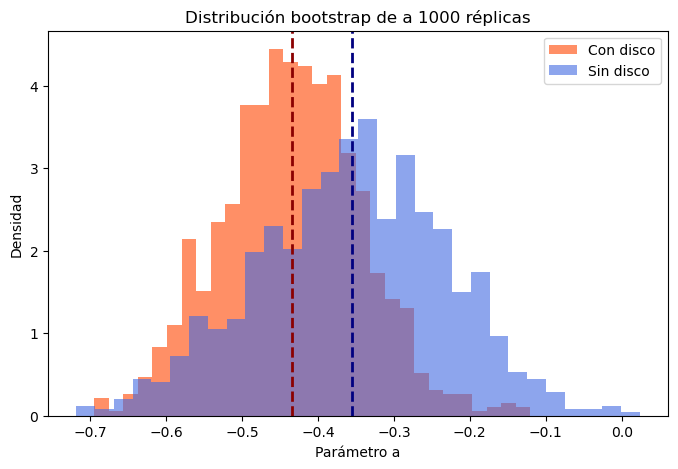

In [ ]:
# Distribuciones de a
plt.figure(figsize=(8,5))
plt.hist(a_disk, bins=30, alpha=0.6, color="orangered", density=True, label="Con disco")
plt.hist(a_nodisk, bins=30, alpha=0.6, color="royalblue", density=True, label="Sin disco")
plt.axvline(np.mean(a_disk), color="darkred", linestyle="--", lw=2)
plt.axvline(np.mean(a_nodisk), color="navy", linestyle="--", lw=2)
plt.xlabel("Parámetro a")
plt.ylabel("Densidad")
plt.legend()
plt.title("Distribución bootstrap de a 1000 réplicas")
plt.savefig(results_path + 'bootstrap_a_disk_nodisk_T3.png', dpi=300, bbox_inches='tight')
plt.show()             

### Mvir/Mdom

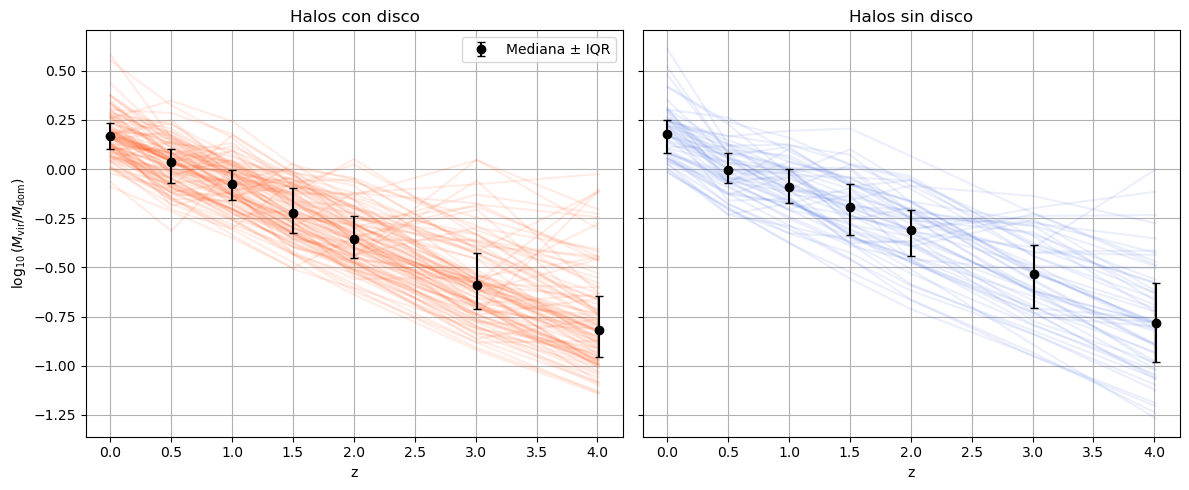

In [ ]:
#mvir/mdom vs z con dispersión para halos con y sin disco

fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

def plot_group(ax, halos, color, title):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir_mdom = np.array(row['Mvir']/row['Mdom'])
        ax.plot(z, np.log10(mvir_mdom), color=color, alpha=0.1)

    # Agrupar por z
    mvir_mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']/row['Mdom']):
            if zz not in mvir_mdom_by_z:
                mvir_mdom_by_z[zz] = []
            mvir_mdom_by_z[zz].append(m)

    z_vals = np.array(sorted(mvir_mdom_by_z.keys()))
    mvir_mdom_median = np.array([np.median(mvir_mdom_by_z[zz]) for zz in z_vals])
    mvir_mdom_q25    = np.array([np.percentile(mvir_mdom_by_z[zz], 25) for zz in z_vals])
    mvir_mdom_q75    = np.array([np.percentile(mvir_mdom_by_z[zz], 75) for zz in z_vals])

    # Puntos de la mediana con barras de error
    ax.errorbar(z_vals, np.log10(mvir_mdom_median),
                yerr=[np.log10(mvir_mdom_median)-np.log10(mvir_mdom_q25),
                      np.log10(mvir_mdom_q75)-np.log10(mvir_mdom_median)],
                fmt='o', color='black', ecolor='black', capsize=3,
                label='Mediana ± IQR')

    ax.set_title(title)
    ax.set_xlabel("z")
    ax.grid(True)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(axs[0], halos_disk, color='orangered', title='Halos con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(axs[1], halos_nodisk, color='royalblue', title='Halos sin disco')

axs[0].set_ylabel(r"$\log_{10}(M_{\rm vir}/M_{\rm dom})$")
axs[0].legend()

plt.tight_layout()
plt.show()

# Tests estadisticos

In [ ]:
# Exploremos la estructura de los datos
print("Estructura del DataFrame history_accretion:")
print(f"Número total de halos: {len(history_accretion)}")
print(f"Halos con disco: {len(history_accretion[history_accretion['has_disk'] == 1])}")
print(f"Halos sin disco: {len(history_accretion[history_accretion['has_disk'] == 0])}")
print("\nColumnas disponibles:")
print(history_accretion.columns.tolist())
print("\nEjemplo de datos de un halo:")
print(history_accretion.iloc[0])

Estructura del DataFrame history_accretion:
Número total de halos: 160
Halos con disco: 103
Halos sin disco: 57

Columnas disponibles:
['halo_id', 'snap', 'z', 'Mdom', 'Mvir', 'Rvir', 'Mvir_ratio', 'has_disk', 'Mdom/Mdom0']

Ejemplo de datos de un halo:
halo_id                                   [1, 1, 3, 2, 1, 0, 8]
snap                               [99, 67, 50, 40, 33, 25, 21]
z                         [0.0, 0.5, 1.0, 1.5, 2.0, 3.01, 4.01]
Mdom          [4486.70147182, 4043.95089966, 3420.44057855, ...
Mvir          [7451.42138672, 4386.43115234, 2622.07202148, ...
Rvir          [855.5769043, 809.34417725, 712.26452637, 661....
Mvir_ratio    [1.0, 0.5886703924914974, 0.3518888391083457, ...
has_disk                                                      1
Mdom/Mdom0    [0.0, -0.045121300290604086, -0.11784512411409...
Name: 0, dtype: object


# Análisis Estadístico Avanzado y Tasas de Acreción

Este análisis incluye:
1. Cálculo de tasas de acreción (derivadas temporales)
2. Tests estadísticos no paramétricos robustos
3. Análisis de tiempos característicos
4. Comparación de distribuciones en diferentes épocas
5. Análisis de correlaciones

## 1. Cálculo de Tasas de Acreción

Calculamos $d\log(M)/dt$ para Mvir y Mdom

In [ ]:
from scipy.interpolate import interp1d

# Función para convertir redshift a tiempo cósmico (aproximación simple)
# Para un universo plano ΛCDM: t ≈ (2/3H0) * (1+z)^(-3/2) en unidades de 1/H0
def z_to_time(z, H0=0.07):  # H0 en unidades de Gyr^-1
    """Aproximación del tiempo cósmico en Gyr"""
    return (2/(3*H0)) * (1+z)**(-1.5)

# Calcular tasas de acreción para cada halo
def calculate_accretion_rates(history_df):
    """
    Calcula las tasas de acreción dlog(M)/dt para Mvir y Mdom
    """
    accretion_rates = []
    
    for i, row in history_df.iterrows():
        z_arr = np.array(row['z'])
        mvir_arr = np.array(row['Mvir'])
        mdom_arr = np.array(row['Mdom'])
        
        # Convertir z a tiempo
        t_arr = z_to_time(z_arr)
        
        # Calcular log(M)
        log_mvir = np.log10(mvir_arr)
        log_mdom = np.log10(mdom_arr)
        
        # Calcular derivadas (tasa de acreción)
        # Usamos diferencias centrales excepto en los extremos
        dlogMvir_dt = np.gradient(log_mvir, t_arr)
        dlogMdom_dt = np.gradient(log_mdom, t_arr)
        
        # Masa específica de acreción (SMAR): (1/M) dM/dt = d(ln M)/dt = ln(10) * d(log M)/dt
        smar_mvir = np.log(10) * dlogMvir_dt
        smar_mdom = np.log(10) * dlogMdom_dt
        
        accretion_rates.append({
            'halo_id': row['halo_id'],
            'has_disk': row['has_disk'],
            'z': z_arr,
            't': t_arr,
            'dlogMvir_dt': dlogMvir_dt,
            'dlogMdom_dt': dlogMdom_dt,
            'smar_mvir': smar_mvir,
            'smar_mdom': smar_mdom,
            'Mvir': mvir_arr,
            'Mdom': mdom_arr
        })
    
    return pd.DataFrame(accretion_rates)

# Calcular tasas de acreción
accretion_rates_df = calculate_accretion_rates(history_accretion)

print("Tasas de acreción calculadas exitosamente")
print(f"Número de halos con tasas: {len(accretion_rates_df)}")
accretion_rates_df.head()

Tasas de acreción calculadas exitosamente
Número de halos con tasas: 160


halo_id  has_disk  \
0        [1, 1, 3, 2, 1, 0, 8]         1   
1      [2, 2, 2, 3, 4, 16, 13]         1   
2  [4, 10, 25, 41, 33, 23, 27]         1   
3     [5, 8, 10, 9, 6, 10, 20]         1   
4    [6, 5, 6, 15, 18, 17, 17]         1   

                                       z  \
0  [0.0, 0.5, 1.0, 1.5, 2.0, 3.01, 4.01]   
1  [0.0, 0.5, 1.0, 1.5, 2.0, 3.01, 4.01]   
2  [0.0, 0.5, 1.0, 1.5, 2.0, 3.01, 4.01]   
3  [0.0, 0.5, 1.0, 1.5, 2.0, 3.01, 4.01]   
4  [0.0, 0.5, 1.0, 1.5, 2.0, 3.01, 4.01]   

                                                   t  \
0  [9.523809523809524, 5.184105275731594, 3.36717...   
1  [9.523809523809524, 5.184105275731594, 3.36717...   
2  [9.523809523809524, 5.184105275731594, 3.36717...   
3  [9.523809523809524, 5.184105275731594, 3.36717...   
4  [9.523809523809524, 5.184105275731594, 3.36717...   

                                         dlogMvir_dt  \
0  [0.053028453914967986, 0.10234408425706998, 0....   
1  [0.031075967706925715, 0.05125088987191884, 0....   
2  [0.15488361077694046, 0.11753782021131398, 0.2...   
3  [0.03267195884290891, 0.10965395608429152, 0.0...   
4  [0.030034527635086593, 0.09654293998327201, 0....   

                                         dlogMdom_dt  \
0  [0.010397321501940664, 0.03128181939250174, -0...   
1  [-0.004728001452507466, -0.016951221084824164,...   
2  [0.12448416606971555, 0.09369035077393928, 0.1...   
3  [0.0061968267834347, 0.03423406682722385, -0.0...   
4  [-0.005480649622498948, 0.04267428579316235, 0...   

                                           smar_mvir  \
0  [0.12210252748912703, 0.23565596276645595, 0.2...   
1  [0.07155505999233151, 0.11800953502175984, 0.5...   
2  [0.35663269332407505, 0.27064083268158584, 0.5...   
3  [0.07522996539059705, 0.25248756466751343, 0.1...   
4  [0.0691570556076681, 0.22229833443930097, 0.70...   

                                           smar_mdom  \
0  [0.023940717497435034, 0.07202905101490657, -0...   
1  [-0.010886625664197888, -0.03903162897796248, ...   
2  [0.28663538510592224, 0.21573000504945575, 0.3...   
3  [0.014268720975402983, 0.07882685194892762, -0...   
4  [-0.012619662120689523, 0.09826117432150322, 0...   

                                                Mvir  \
0  [7451.42138672, 4386.43115234, 2622.07202148, ...   
1  [5196.79931641, 3809.56542969, 2967.62475586, ...   
2  [3279.32080078, 697.64556885, 455.49746704, 22...   
3  [1844.44311523, 1330.6953125, 734.99511719, 69...   
4  [3006.94116211, 2227.3269043, 1323.66748047, 5...   

                                                Mdom  
0  [4486.70147182, 4043.95089966, 3420.44057855, ...  
1  [3289.3646289, 3448.49933087, 3782.05287027, 2...  
2  [2294.94337426, 661.52690158, 471.78453508, 32...  
3  [1576.24642926, 1481.60256171, 1222.37016631, ...  
4  [1930.38444083, 2039.05155665, 1567.69042987, ...

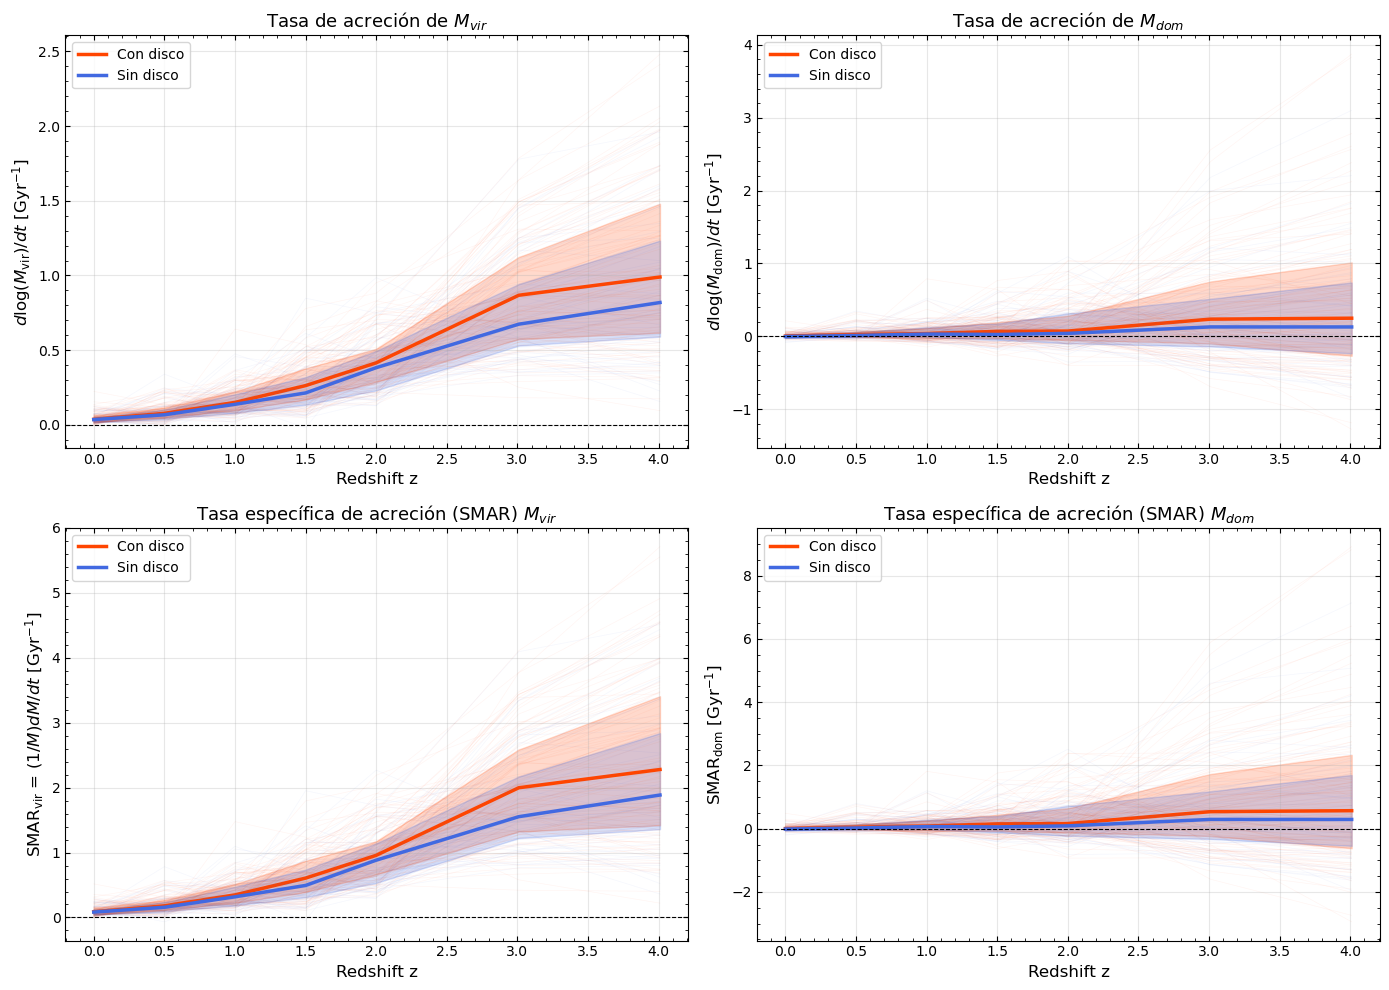

In [ ]:
# Graficar tasas de acreción vs redshift
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

def plot_accretion_rates(ax, data_df, rate_key, ylabel, title):
    """Grafica tasas de acreción con medianas y dispersión"""
    
    # Separar por disco/no disco
    disk_data = data_df[data_df['has_disk'] == 1]
    nodisk_data = data_df[data_df['has_disk'] == 0]
    
    # Agrupar por z
    for halos, color, label in [(disk_data, 'orangered', 'Con disco'), 
                                 (nodisk_data, 'royalblue', 'Sin disco')]:
        
        # Historias individuales (transparentes)
        for i, row in halos.iterrows():
            ax.plot(row['z'], row[rate_key], color=color, alpha=0.05, linewidth=0.5)
        
        # Calcular mediana por z
        rate_by_z = {}
        for i, row in halos.iterrows():
            for zz, rate in zip(row['z'], row[rate_key]):
                if zz not in rate_by_z:
                    rate_by_z[zz] = []
                rate_by_z[zz].append(rate)
        
        z_vals = sorted(rate_by_z.keys())
        medians = [np.median(rate_by_z[zz]) for zz in z_vals]
        q25 = [np.percentile(rate_by_z[zz], 25) for zz in z_vals]
        q75 = [np.percentile(rate_by_z[zz], 75) for zz in z_vals]
        
        # Plot mediana
        ax.plot(z_vals, medians, color=color, linewidth=2.5, label=label)
        ax.fill_between(z_vals, q25, q75, color=color, alpha=0.2)
    
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_xlabel('Redshift z', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')

# Graficar las 4 tasas
plot_accretion_rates(axs[0,0], accretion_rates_df, 'dlogMvir_dt', 
                     r'$d\log(M_{\rm vir})/dt$ [Gyr$^{-1}$]',
                     'Tasa de acreción de $M_{vir}$')

plot_accretion_rates(axs[0,1], accretion_rates_df, 'dlogMdom_dt',
                     r'$d\log(M_{\rm dom})/dt$ [Gyr$^{-1}$]',
                     'Tasa de acreción de $M_{dom}$')

plot_accretion_rates(axs[1,0], accretion_rates_df, 'smar_mvir',
                     r'SMAR$_{\rm vir}$ = $(1/M)dM/dt$ [Gyr$^{-1}$]',
                     'Tasa específica de acreción (SMAR) $M_{vir}$')

plot_accretion_rates(axs[1,1], accretion_rates_df, 'smar_mdom',
                     r'SMAR$_{\rm dom}$ [Gyr$^{-1}$]',
                     'Tasa específica de acreción (SMAR) $M_{dom}$')

plt.tight_layout()
plt.savefig(results_path + 'accretion_rates_vs_z_disk_nodisk.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Tests Estadísticos No Paramétricos

Comparamos las distribuciones de tasas de acreción en diferentes épocas usando tests más robustos

In [ ]:
from scipy.stats import mannwhitneyu, permutation_test

def compare_rates_at_z(accretion_df, z_target, rate_key='dlogMvir_dt', tolerance=0.05):
    """
    Compara tasas de acreción entre halos con/sin disco en un redshift específico
    usando Mann-Whitney U test y test de permutación
    """
    disk_rates = []
    nodisk_rates = []
    
    for i, row in accretion_df.iterrows():
        z_arr = row['z']
        rate_arr = row[rate_key]
        
        # Encontrar el valor más cercano a z_target
        idx = np.argmin(np.abs(z_arr - z_target))
        if np.abs(z_arr[idx] - z_target) < tolerance:
            if row['has_disk'] == 1:
                disk_rates.append(rate_arr[idx])
            else:
                nodisk_rates.append(rate_arr[idx])
    
    disk_rates = np.array(disk_rates)
    nodisk_rates = np.array(nodisk_rates)
    
    # Mann-Whitney U test (no asume normalidad)
    u_stat, p_mw = mannwhitneyu(disk_rates, nodisk_rates, alternative='two-sided')
    
    # Test de permutación
    def statistic(x, y):
        return np.median(x) - np.median(y)
    
    # Preparar datos para permutation_test
    data_combined = np.concatenate([disk_rates, nodisk_rates])
    
    # Test de permutación manual
    n_disk = len(disk_rates)
    n_total = len(data_combined)
    observed_diff = statistic(disk_rates, nodisk_rates)
    
    n_permutations = 10000
    rng = np.random.default_rng(42)
    perm_diffs = []
    
    for _ in range(n_permutations):
        shuffled = rng.permutation(data_combined)
        perm_disk = shuffled[:n_disk]
        perm_nodisk = shuffled[n_disk:]
        perm_diffs.append(statistic(perm_disk, perm_nodisk))
    
    perm_diffs = np.array(perm_diffs)
    p_perm = np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)) / n_permutations
    
    return {
        'z': z_target,
        'n_disk': len(disk_rates),
        'n_nodisk': len(nodisk_rates),
        'median_disk': np.median(disk_rates),
        'median_nodisk': np.median(nodisk_rates),
        'mean_disk': np.mean(disk_rates),
        'mean_nodisk': np.mean(nodisk_rates),
        'std_disk': np.std(disk_rates),
        'std_nodisk': np.std(nodisk_rates),
        'u_statistic': u_stat,
        'p_mannwhitney': p_mw,
        'p_permutation': p_perm,
        'effect_size': observed_diff
    }

# Comparar en diferentes redshifts
z_targets = [0.0, 0.5, 1.0, 2.0, 3.0, 4.0]
results_mvir = []
results_mdom = []

print("="*80)
print("COMPARACIÓN DE TASAS DE ACRECIÓN: dlog(Mvir)/dt")
print("="*80)

for z in z_targets:
    result = compare_rates_at_z(accretion_rates_df, z, 'dlogMvir_dt')
    results_mvir.append(result)
    
    print(f"\nRedshift z = {z:.1f}")
    print(f"  N (con disco): {result['n_disk']}, N (sin disco): {result['n_nodisk']}")
    print(f"  Mediana (con disco): {result['median_disk']:.4f} Gyr⁻¹")
    print(f"  Mediana (sin disco): {result['median_nodisk']:.4f} Gyr⁻¹")
    print(f"  Diferencia de medianas: {result['effect_size']:.4f} Gyr⁻¹")
    print(f"  p-valor (Mann-Whitney): {result['p_mannwhitney']:.4f}")
    print(f"  p-valor (Permutación): {result['p_permutation']:.4f}")
    
    if result['p_mannwhitney'] < 0.05:
        print("  ✓ DIFERENCIA SIGNIFICATIVA (p < 0.05)")
    else:
        print("  ✗ No hay diferencia significativa")

print("\n" + "="*80)
print("COMPARACIÓN DE TASAS DE ACRECIÓN: dlog(Mdom)/dt")
print("="*80)

for z in z_targets:
    result = compare_rates_at_z(accretion_rates_df, z, 'dlogMdom_dt')
    results_mdom.append(result)
    
    print(f"\nRedshift z = {z:.1f}")
    print(f"  N (con disco): {result['n_disk']}, N (sin disco): {result['n_nodisk']}")
    print(f"  Mediana (con disco): {result['median_disk']:.4f} Gyr⁻¹")
    print(f"  Mediana (sin disco): {result['median_nodisk']:.4f} Gyr⁻¹")
    print(f"  Diferencia de medianas: {result['effect_size']:.4f} Gyr⁻¹")
    print(f"  p-valor (Mann-Whitney): {result['p_mannwhitney']:.4f}")
    print(f"  p-valor (Permutación): {result['p_permutation']:.4f}")
    
    if result['p_mannwhitney'] < 0.05:
        print("  ✓ DIFERENCIA SIGNIFICATIVA (p < 0.05)")
    else:
        print("  ✗ No hay diferencia significativa")

# Guardar resultados
df_results_mvir = pd.DataFrame(results_mvir)
df_results_mdom = pd.DataFrame(results_mdom)

COMPARACIÓN DE TASAS DE ACRECIÓN: dlog(Mvir)/dt

Redshift z = 0.0
  N (con disco): 103, N (sin disco): 57
  Mediana (con disco): 0.0380 Gyr⁻¹
  Mediana (sin disco): 0.0361 Gyr⁻¹
  Diferencia de medianas: 0.0019 Gyr⁻¹
  p-valor (Mann-Whitney): 0.6204
  p-valor (Permutación): 0.7425
  ✗ No hay diferencia significativa

Redshift z = 0.0
  N (con disco): 103, N (sin disco): 57
  Mediana (con disco): 0.0380 Gyr⁻¹
  Mediana (sin disco): 0.0361 Gyr⁻¹
  Diferencia de medianas: 0.0019 Gyr⁻¹
  p-valor (Mann-Whitney): 0.6204
  p-valor (Permutación): 0.7425
  ✗ No hay diferencia significativa

Redshift z = 0.5
  N (con disco): 103, N (sin disco): 57
  Mediana (con disco): 0.0779 Gyr⁻¹
  Mediana (sin disco): 0.0682 Gyr⁻¹
  Diferencia de medianas: 0.0097 Gyr⁻¹
  p-valor (Mann-Whitney): 0.1203
  p-valor (Permutación): 0.4061
  ✗ No hay diferencia significativa

Redshift z = 0.5
  N (con disco): 103, N (sin disco): 57
  Mediana (con disco): 0.0779 Gyr⁻¹
  Mediana (sin disco): 0.0682 Gyr⁻¹
  Diferencia

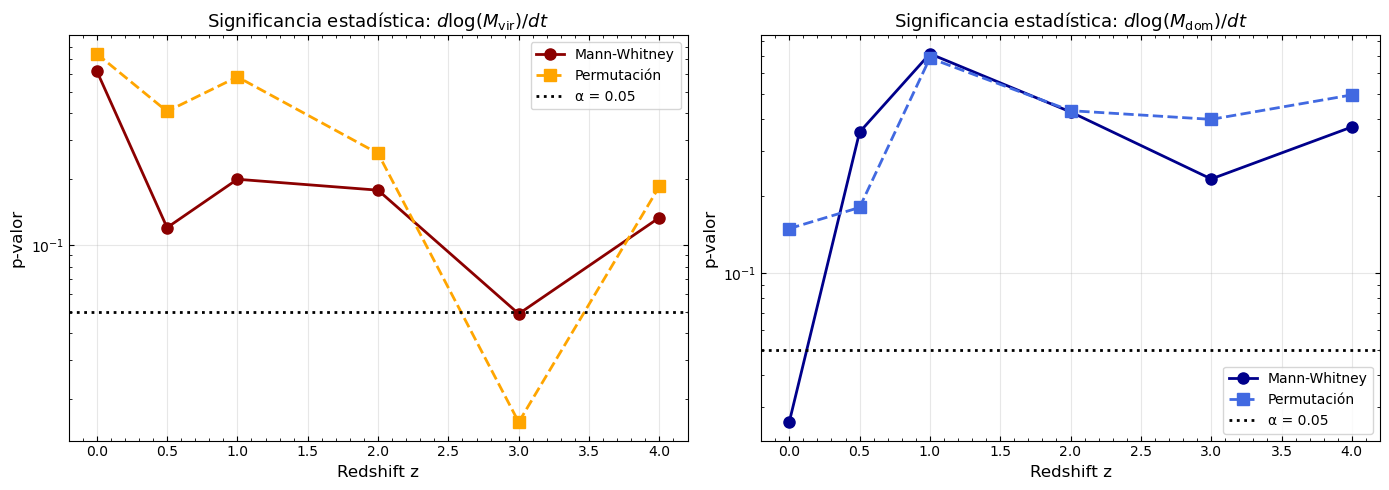

In [ ]:
# Visualización de los p-valores a través del tiempo
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# p-valores para Mvir
axs[0].plot(df_results_mvir['z'], df_results_mvir['p_mannwhitney'], 
           'o-', color='darkred', linewidth=2, markersize=8, label='Mann-Whitney')
axs[0].plot(df_results_mvir['z'], df_results_mvir['p_permutation'], 
           's--', color='orange', linewidth=2, markersize=8, label='Permutación')
axs[0].axhline(0.05, color='black', linestyle=':', linewidth=2, label='α = 0.05')
axs[0].set_xlabel('Redshift z', fontsize=12)
axs[0].set_ylabel('p-valor', fontsize=12)
axs[0].set_title(r'Significancia estadística: $d\log(M_{\rm vir})/dt$', fontsize=13)
axs[0].legend(fontsize=10)
axs[0].grid(True, alpha=0.3)
axs[0].set_yscale('log')
axs[0].minorticks_on()
axs[0].tick_params(axis='both', which='both', top=True, right=True, direction='in')

# p-valores para Mdom
axs[1].plot(df_results_mdom['z'], df_results_mdom['p_mannwhitney'], 
           'o-', color='darkblue', linewidth=2, markersize=8, label='Mann-Whitney')
axs[1].plot(df_results_mdom['z'], df_results_mdom['p_permutation'], 
           's--', color='royalblue', linewidth=2, markersize=8, label='Permutación')
axs[1].axhline(0.05, color='black', linestyle=':', linewidth=2, label='α = 0.05')
axs[1].set_xlabel('Redshift z', fontsize=12)
axs[1].set_ylabel('p-valor', fontsize=12)
axs[1].set_title(r'Significancia estadística: $d\log(M_{\rm dom})/dt$', fontsize=13)
axs[1].legend(fontsize=10)
axs[1].grid(True, alpha=0.3)
axs[1].set_yscale('log')
axs[1].minorticks_on()
axs[1].tick_params(axis='both', which='both', top=True, right=True, direction='in')

plt.tight_layout()
plt.savefig(results_path + 'pvalues_accretion_rates_vs_z.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Análisis de Tiempos Característicos

Calculamos tiempos de formación, tiempo de pico de acreción, etc.

In [ ]:
def calculate_characteristic_times(accretion_df):
    """
    Calcula tiempos característicos de la historia de acreción:
    - z_50: redshift cuando el halo tenía 50% de su masa actual
    - z_peak: redshift del pico máximo de acreción
    - peak_rate: tasa de acreción en el pico
    """
    char_times = []
    
    for i, row in accretion_df.iterrows():
        z_arr = row['z']
        mvir_arr = row['Mvir']
        mdom_arr = row['Mdom']
        dvir_dt = row['dlogMvir_dt']
        ddom_dt = row['dlogMdom_dt']
        
        # Masa actual (z=0)
        mvir_0 = mvir_arr[z_arr == 0][0]
        mdom_0 = mdom_arr[z_arr == 0][0]
        
        # z_50: redshift cuando tenía 50% de masa virial actual
        mvir_ratio = mvir_arr / mvir_0
        idx_50_vir = np.argmin(np.abs(mvir_ratio - 0.5))
        z_50_vir = z_arr[idx_50_vir]
        
        # z_50 para Mdom
        mdom_ratio = mdom_arr / mdom_0
        idx_50_dom = np.argmin(np.abs(mdom_ratio - 0.5))
        z_50_dom = z_arr[idx_50_dom]
        
        # Pico de acreción Mvir (máxima tasa positiva)
        idx_peak_vir = np.argmax(dvir_dt)
        z_peak_vir = z_arr[idx_peak_vir]
        peak_rate_vir = dvir_dt[idx_peak_vir]
        
        # Pico de acreción Mdom
        idx_peak_dom = np.argmax(ddom_dt)
        z_peak_dom = z_arr[idx_peak_dom]
        peak_rate_dom = ddom_dt[idx_peak_dom]
        
        char_times.append({
            'halo_id': row['halo_id'][0],
            'has_disk': row['has_disk'],
            'z_50_vir': z_50_vir,
            'z_50_dom': z_50_dom,
            'z_peak_vir': z_peak_vir,
            'peak_rate_vir': peak_rate_vir,
            'z_peak_dom': z_peak_dom,
            'peak_rate_dom': peak_rate_dom,
            'Mvir_0': mvir_0,
            'Mdom_0': mdom_0
        })
    
    return pd.DataFrame(char_times)

# Calcular tiempos característicos
char_times_df = calculate_characteristic_times(accretion_rates_df)

print("Tiempos característicos calculados")
print(f"\nEstadísticas de z_50 (Mvir):")
print(f"Con disco: {char_times_df[char_times_df['has_disk']==1]['z_50_vir'].mean():.2f} ± {char_times_df[char_times_df['has_disk']==1]['z_50_vir'].std():.2f}")
print(f"Sin disco: {char_times_df[char_times_df['has_disk']==0]['z_50_vir'].mean():.2f} ± {char_times_df[char_times_df['has_disk']==0]['z_50_vir'].std():.2f}")

print(f"\nEstadísticas de z_peak (Mvir):")
print(f"Con disco: {char_times_df[char_times_df['has_disk']==1]['z_peak_vir'].mean():.2f} ± {char_times_df[char_times_df['has_disk']==1]['z_peak_vir'].std():.2f}")
print(f"Sin disco: {char_times_df[char_times_df['has_disk']==0]['z_peak_vir'].mean():.2f} ± {char_times_df[char_times_df['has_disk']==0]['z_peak_vir'].std():.2f}")

char_times_df.head()

Tiempos característicos calculados

Estadísticas de z_50 (Mvir):
Con disco: 0.92 ± 0.36
Sin disco: 1.01 ± 0.42

Estadísticas de z_peak (Mvir):
Con disco: 3.59 ± 0.77
Sin disco: 3.59 ± 0.78


halo_id  has_disk  z_50_vir  z_50_dom  z_peak_vir  peak_rate_vir  \
0        1         1       0.5      3.01        4.01       1.969470   
1        2         1       1.0      2.00        3.01       0.862745   
2        4         1       0.5      0.50        4.01       1.414838   
3        5         1       1.0      4.01        4.01       1.714309   
4        6         1       1.0      1.50        4.01       1.464839   

   z_peak_dom  peak_rate_dom       Mvir_0       Mdom_0  
0        4.01       3.832068  7451.421387  4486.701472  
1        2.00       0.470475  5196.799316  3289.364629  
2        4.01       0.639079  3279.320801  2294.943374  
3        4.01       1.153374  1844.443115  1576.246429  
4        4.01       1.272811  3006.941162  1930.384441

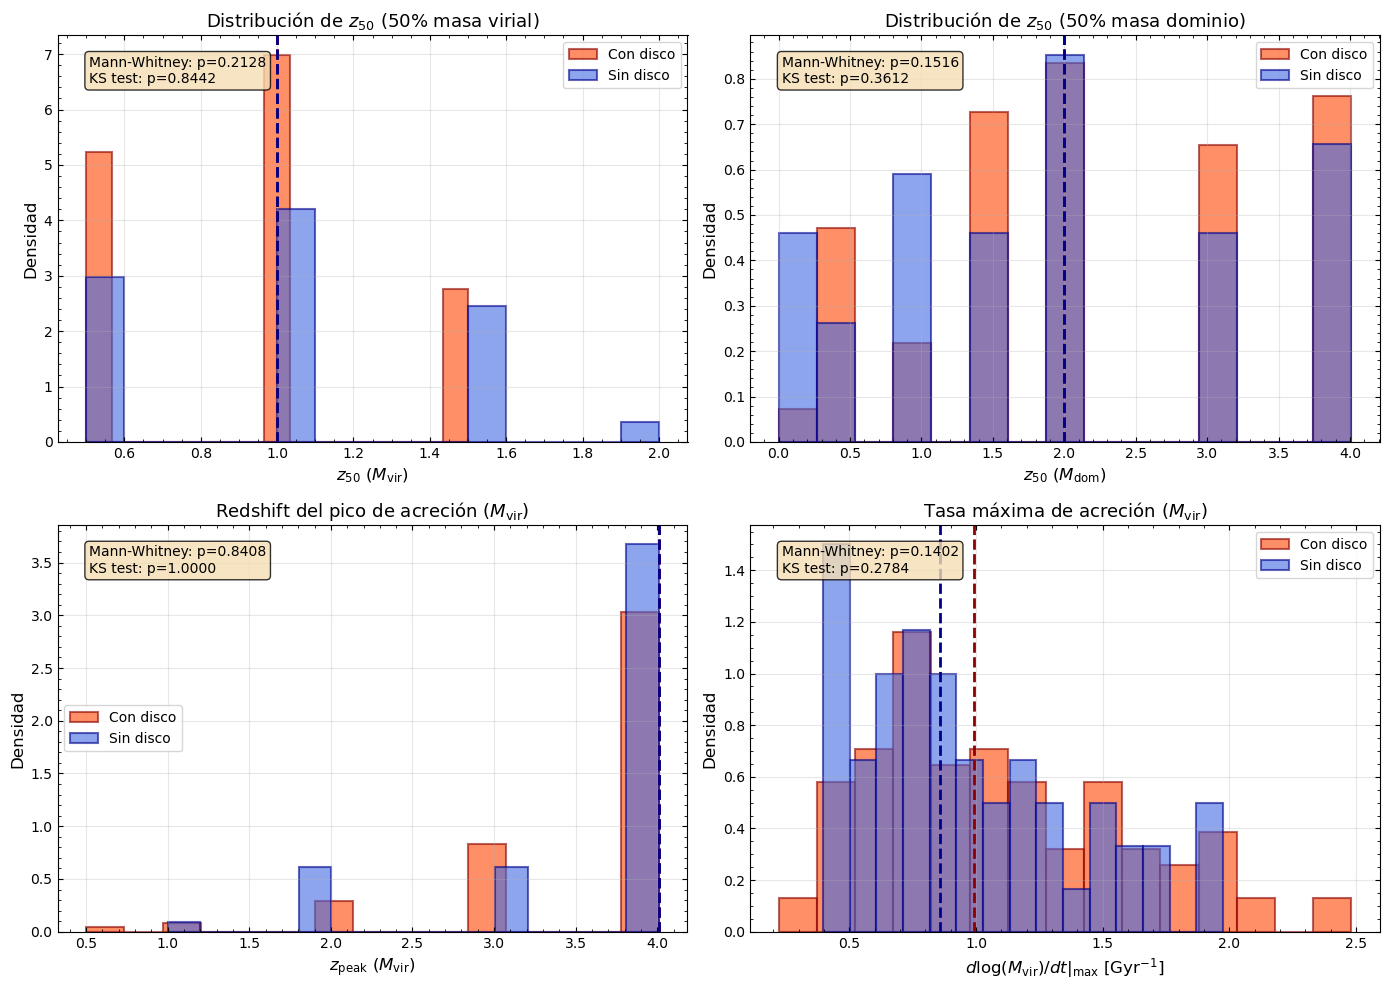


RESUMEN DE TESTS ESTADÍSTICOS PARA TIEMPOS CARACTERÍSTICOS


In [ ]:
# Comparación estadística de tiempos característicos
from scipy.stats import mannwhitneyu, ks_2samp

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

def plot_distribution_comparison(ax, data_disk, data_nodisk, xlabel, title):
    """Grafica distribuciones y realiza test estadístico"""
    
    # Histogramas
    ax.hist(data_disk, bins=15, alpha=0.6, color='orangered', 
            edgecolor='darkred', linewidth=1.5, label='Con disco', density=True)
    ax.hist(data_nodisk, bins=15, alpha=0.6, color='royalblue', 
            edgecolor='darkblue', linewidth=1.5, label='Sin disco', density=True)
    
    # Medianas
    ax.axvline(np.median(data_disk), color='darkred', linestyle='--', linewidth=2)
    ax.axvline(np.median(data_nodisk), color='darkblue', linestyle='--', linewidth=2)
    
    # Test estadístico
    u_stat, p_mw = mannwhitneyu(data_disk, data_nodisk, alternative='two-sided')
    ks_stat, p_ks = ks_2samp(data_disk, data_nodisk)
    
    # Anotaciones
    textstr = f'Mann-Whitney: p={p_mw:.4f}\nKS test: p={p_ks:.4f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('Densidad', fontsize=12)
    ax.set_title(title, fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
    
    return p_mw, p_ks

# z_50 para Mvir
p1, p2 = plot_distribution_comparison(
    axs[0,0],
    char_times_df[char_times_df['has_disk']==1]['z_50_vir'],
    char_times_df[char_times_df['has_disk']==0]['z_50_vir'],
    r'$z_{50}$ ($M_{\rm vir}$)',
    r'Distribución de $z_{50}$ (50% masa virial)'
)

# z_50 para Mdom
p1, p2 = plot_distribution_comparison(
    axs[0,1],
    char_times_df[char_times_df['has_disk']==1]['z_50_dom'],
    char_times_df[char_times_df['has_disk']==0]['z_50_dom'],
    r'$z_{50}$ ($M_{\rm dom}$)',
    r'Distribución de $z_{50}$ (50% masa dominio)'
)

# z_peak para Mvir
p1, p2 = plot_distribution_comparison(
    axs[1,0],
    char_times_df[char_times_df['has_disk']==1]['z_peak_vir'],
    char_times_df[char_times_df['has_disk']==0]['z_peak_vir'],
    r'$z_{\rm peak}$ ($M_{\rm vir}$)',
    r'Redshift del pico de acreción ($M_{\rm vir}$)'
)

# Tasa en el pico para Mvir
p1, p2 = plot_distribution_comparison(
    axs[1,1],
    char_times_df[char_times_df['has_disk']==1]['peak_rate_vir'],
    char_times_df[char_times_df['has_disk']==0]['peak_rate_vir'],
    r'$d\log(M_{\rm vir})/dt|_{\rm max}$ [Gyr$^{-1}$]',
    r'Tasa máxima de acreción ($M_{\rm vir}$)'
)

plt.tight_layout()
plt.savefig(results_path + 'characteristic_times_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("RESUMEN DE TESTS ESTADÍSTICOS PARA TIEMPOS CARACTERÍSTICOS")
print("="*80)

## 4. Análisis de Correlación entre Variables

Exploramos correlaciones entre masa, tasa de acreción, y formación de discos

MATRIZ DE CORRELACIÓN DE SPEARMAN (todas las variables)


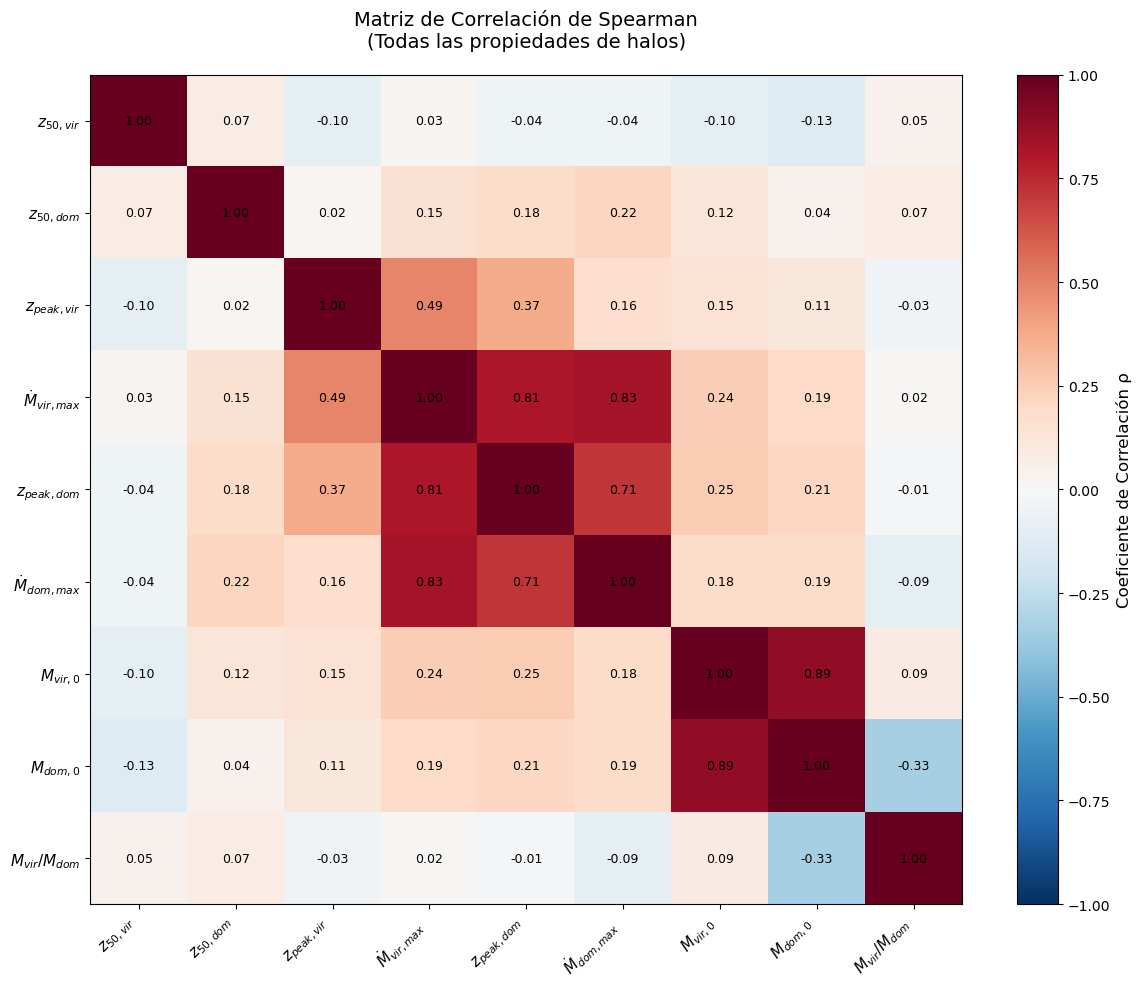


Correlaciones más fuertes (|ρ| > 0.3):
  z_peak_vir vs peak_rate_vir: ρ = 0.488
  z_peak_vir vs z_peak_dom: ρ = 0.373
  peak_rate_vir vs z_peak_dom: ρ = 0.811
  peak_rate_vir vs peak_rate_dom: ρ = 0.830
  z_peak_dom vs peak_rate_dom: ρ = 0.711
  Mvir_0 vs Mdom_0: ρ = 0.886
  Mdom_0 vs Mvir_Mdom_ratio: ρ = -0.334


In [ ]:
from scipy.stats import spearmanr, pearsonr

# Combinar datos para análisis de correlación
combined_df = char_times_df.merge(
    z0_df[['halo_id', 'Mvir_Mdom_ratio']], 
    on='halo_id', 
    how='left'
)

print("="*80)
print("MATRIZ DE CORRELACIÓN DE SPEARMAN (todas las variables)")
print("="*80)

# Seleccionar variables numéricas
numeric_vars = ['z_50_vir', 'z_50_dom', 'z_peak_vir', 'peak_rate_vir', 
                'z_peak_dom', 'peak_rate_dom', 'Mvir_0', 'Mdom_0', 'Mvir_Mdom_ratio']

# Calcular matriz de correlación
corr_matrix = combined_df[numeric_vars].corr(method='spearman')

# Visualizar matriz de correlación
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')

# Etiquetas
ax.set_xticks(np.arange(len(numeric_vars)))
ax.set_yticks(np.arange(len(numeric_vars)))
ax.set_xticklabels([r'$z_{50,vir}$', r'$z_{50,dom}$', r'$z_{peak,vir}$', 
                     r'$\dot{M}_{vir,max}$', r'$z_{peak,dom}$', r'$\dot{M}_{dom,max}$',
                     r'$M_{vir,0}$', r'$M_{dom,0}$', r'$M_{vir}/M_{dom}$'],
                    rotation=45, ha='right', fontsize=11)
ax.set_yticklabels([r'$z_{50,vir}$', r'$z_{50,dom}$', r'$z_{peak,vir}$', 
                     r'$\dot{M}_{vir,max}$', r'$z_{peak,dom}$', r'$\dot{M}_{dom,max}$',
                     r'$M_{vir,0}$', r'$M_{dom,0}$', r'$M_{vir}/M_{dom}$'],
                    fontsize=11)

# Añadir valores de correlación
for i in range(len(numeric_vars)):
    for j in range(len(numeric_vars)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=9)

ax.set_title('Matriz de Correlación de Spearman\n(Todas las propiedades de halos)', 
             fontsize=14, pad=20)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Coeficiente de Correlación ρ', fontsize=12)
plt.tight_layout()
plt.savefig(results_path + 'correlation_matrix_all.png', dpi=300, bbox_inches='tight')
plt.show()

# Imprimir correlaciones más fuertes
print("\nCorrelaciones más fuertes (|ρ| > 0.3):")
for i in range(len(numeric_vars)):
    for j in range(i+1, len(numeric_vars)):
        rho = corr_matrix.iloc[i, j]
        if abs(rho) > 0.3:
            print(f"  {numeric_vars[i]} vs {numeric_vars[j]}: ρ = {rho:.3f}")

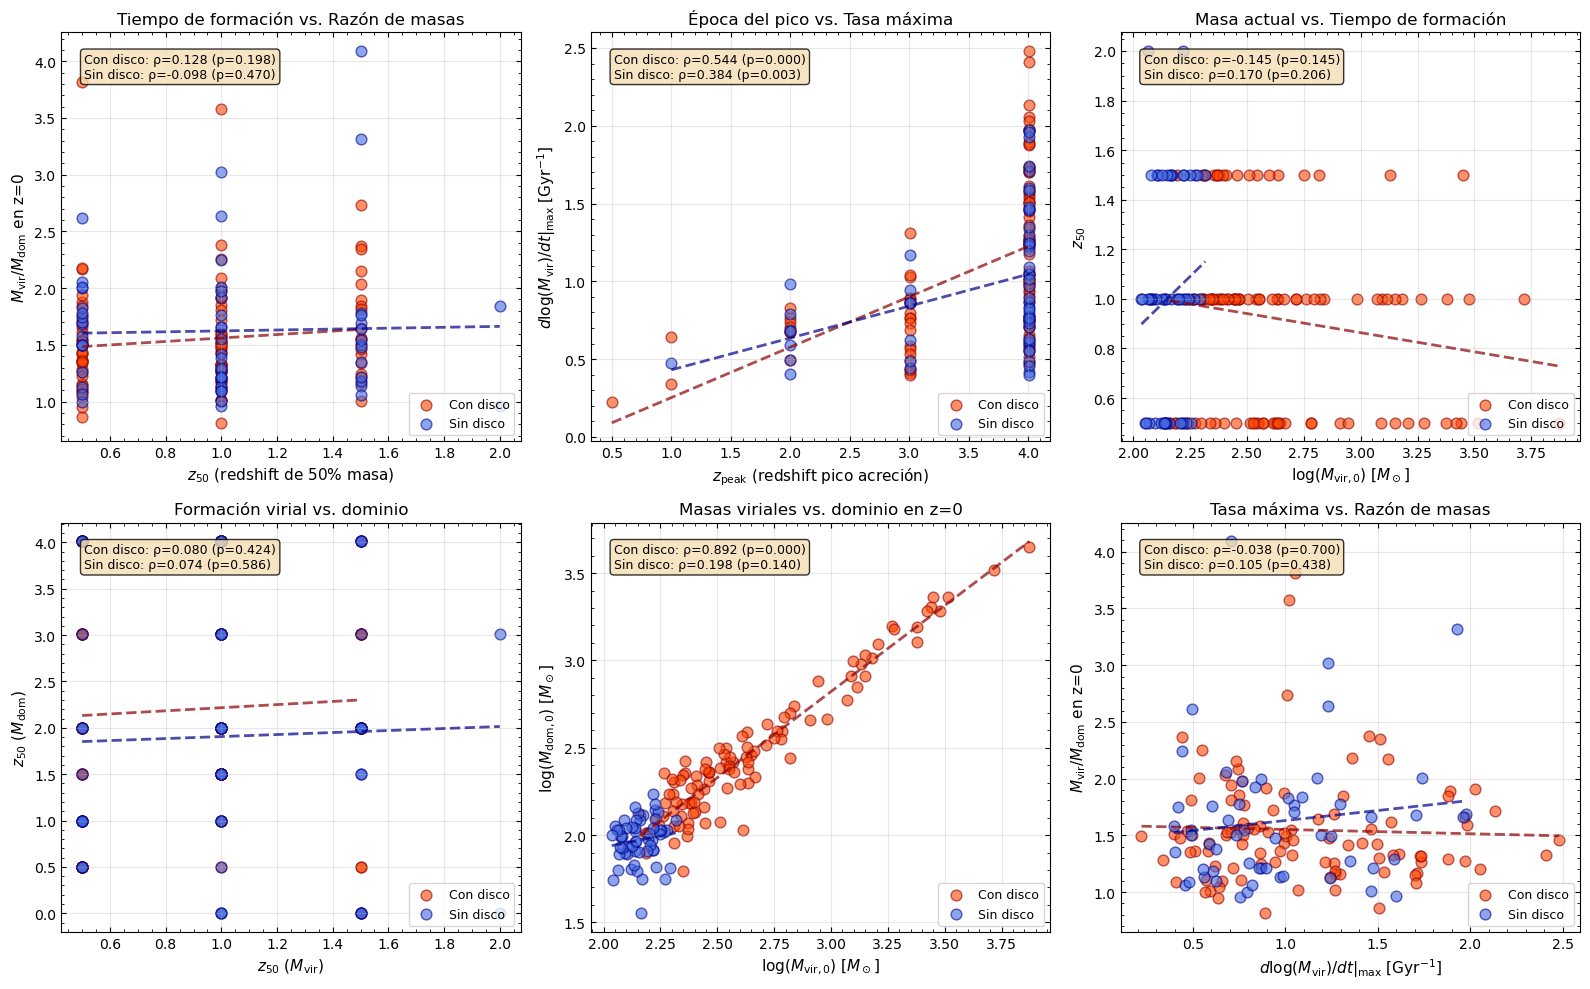

In [ ]:
# Scatter plots de relaciones interesantes
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

def scatter_with_trend(ax, x_disk, y_disk, x_nodisk, y_nodisk, xlabel, ylabel, title):
    """Scatter plot con línea de tendencia"""
    
    # Puntos
    ax.scatter(x_disk, y_disk, c='orangered', alpha=0.6, s=60, 
              edgecolors='darkred', linewidth=1, label='Con disco')
    ax.scatter(x_nodisk, y_nodisk, c='royalblue', alpha=0.6, s=60, 
              edgecolors='darkblue', linewidth=1, label='Sin disco')
    
    # Correlaciones
    if len(x_disk) > 3 and len(y_disk) > 3:
        rho_disk, p_disk = spearmanr(x_disk, y_disk)
        rho_nodisk, p_nodisk = spearmanr(x_nodisk, y_nodisk)
        
        # Líneas de tendencia (lowess smoothing)
        from scipy.stats import linregress
        if len(x_disk) > 2:
            slope_d, intercept_d, _, _, _ = linregress(x_disk, y_disk)
            x_trend = np.linspace(x_disk.min(), x_disk.max(), 100)
            ax.plot(x_trend, slope_d*x_trend + intercept_d, '--', 
                   color='darkred', linewidth=2, alpha=0.7)
        
        if len(x_nodisk) > 2:
            slope_n, intercept_n, _, _, _ = linregress(x_nodisk, y_nodisk)
            x_trend = np.linspace(x_nodisk.min(), x_nodisk.max(), 100)
            ax.plot(x_trend, slope_n*x_trend + intercept_n, '--', 
                   color='darkblue', linewidth=2, alpha=0.7)
        
        # Texto con correlaciones
        textstr = f'Con disco: ρ={rho_disk:.3f} (p={p_disk:.3f})\n'
        textstr += f'Sin disco: ρ={rho_nodisk:.3f} (p={p_nodisk:.3f})'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=props)
    
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=12)
    ax.legend(fontsize=9, loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')

# 1. z_50 vs Mvir/Mdom
scatter_with_trend(
    axs[0,0],
    combined_df[combined_df['has_disk']==1]['z_50_vir'],
    combined_df[combined_df['has_disk']==1]['Mvir_Mdom_ratio'],
    combined_df[combined_df['has_disk']==0]['z_50_vir'],
    combined_df[combined_df['has_disk']==0]['Mvir_Mdom_ratio'],
    r'$z_{50}$ (redshift de 50% masa)',
    r'$M_{\rm vir}/M_{\rm dom}$ en z=0',
    'Tiempo de formación vs. Razón de masas'
)

# 2. z_peak vs tasa máxima
scatter_with_trend(
    axs[0,1],
    combined_df[combined_df['has_disk']==1]['z_peak_vir'],
    combined_df[combined_df['has_disk']==1]['peak_rate_vir'],
    combined_df[combined_df['has_disk']==0]['z_peak_vir'],
    combined_df[combined_df['has_disk']==0]['peak_rate_vir'],
    r'$z_{\rm peak}$ (redshift pico acreción)',
    r'$d\log(M_{\rm vir})/dt|_{\rm max}$ [Gyr$^{-1}$]',
    'Época del pico vs. Tasa máxima'
)

# 3. Masa actual vs z_50
scatter_with_trend(
    axs[0,2],
    np.log10(combined_df[combined_df['has_disk']==1]['Mvir_0']),
    combined_df[combined_df['has_disk']==1]['z_50_vir'],
    np.log10(combined_df[combined_df['has_disk']==0]['Mvir_0']),
    combined_df[combined_df['has_disk']==0]['z_50_vir'],
    r'$\log(M_{\rm vir,0})$ [$M_\odot$]',
    r'$z_{50}$',
    'Masa actual vs. Tiempo de formación'
)

# 4. z_50 vir vs z_50 dom
scatter_with_trend(
    axs[1,0],
    combined_df[combined_df['has_disk']==1]['z_50_vir'],
    combined_df[combined_df['has_disk']==1]['z_50_dom'],
    combined_df[combined_df['has_disk']==0]['z_50_vir'],
    combined_df[combined_df['has_disk']==0]['z_50_dom'],
    r'$z_{50}$ ($M_{\rm vir}$)',
    r'$z_{50}$ ($M_{\rm dom}$)',
    'Formación virial vs. dominio'
)

# 5. Masa virial vs Masa dominio (z=0)
scatter_with_trend(
    axs[1,1],
    np.log10(combined_df[combined_df['has_disk']==1]['Mvir_0']),
    np.log10(combined_df[combined_df['has_disk']==1]['Mdom_0']),
    np.log10(combined_df[combined_df['has_disk']==0]['Mvir_0']),
    np.log10(combined_df[combined_df['has_disk']==0]['Mdom_0']),
    r'$\log(M_{\rm vir,0})$ [$M_\odot$]',
    r'$\log(M_{\rm dom,0})$ [$M_\odot$]',
    'Masas viriales vs. dominio en z=0'
)

# 6. Tasa máxima vs Mvir/Mdom
scatter_with_trend(
    axs[1,2],
    combined_df[combined_df['has_disk']==1]['peak_rate_vir'],
    combined_df[combined_df['has_disk']==1]['Mvir_Mdom_ratio'],
    combined_df[combined_df['has_disk']==0]['peak_rate_vir'],
    combined_df[combined_df['has_disk']==0]['Mvir_Mdom_ratio'],
    r'$d\log(M_{\rm vir})/dt|_{\rm max}$ [Gyr$^{-1}$]',
    r'$M_{\rm vir}/M_{\rm dom}$ en z=0',
    'Tasa máxima vs. Razón de masas'
)

plt.tight_layout()
plt.savefig(results_path + 'correlation_scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Análisis de Effect Size (Tamaño del Efecto)

Calculamos Cohen's d para cuantificar la magnitud de las diferencias

ANÁLISIS DE TAMAÑO DEL EFECTO (Cohen's d)

Interpretación:
  |d| < 0.2  : Efecto pequeño
  0.2 ≤ |d| < 0.5: Efecto medio
  0.5 ≤ |d| < 0.8: Efecto grande
  |d| ≥ 0.8  : Efecto muy grande

$z_{50}$ (M$_{\rm vir}$):
  Cohen's d = -0.2404 (efecto medio)
  Con disco: 0.9175 ± 0.3559
  Sin disco: 1.0088 ± 0.4135
  Diferencia: -0.0913

$z_{50}$ (M$_{\rm dom}$):
  Cohen's d = 0.2394 (efecto medio)
  Con disco: 2.2028 ± 1.1955
  Sin disco: 1.9065 ± 1.2896
  Diferencia: 0.2963

$z_{\rm peak}$ (M$_{\rm vir}$):
  Cohen's d = -0.0011 (efecto pequeño)
  Con disco: 3.5867 ± 0.7649
  Sin disco: 3.5875 ± 0.7742
  Diferencia: -0.0008

Tasa máxima (M$_{\rm vir}$):
  Cohen's d = 0.2706 (efecto medio)
  Con disco: 1.0909 ± 0.5050
  Sin disco: 0.9608 ± 0.4237
  Diferencia: 0.1301

$z_{\rm peak}$ (M$_{\rm dom}$):
  Cohen's d = 0.2818 (efecto medio)
  Con disco: 2.7969 ± 1.3779
  Sin disco: 2.4079 ± 1.3599
  Diferencia: 0.3890

Tasa máxima (M$_{\rm dom}$):
  Cohen's d = 0.2601 (efecto medio)
  Con disco: 0.7

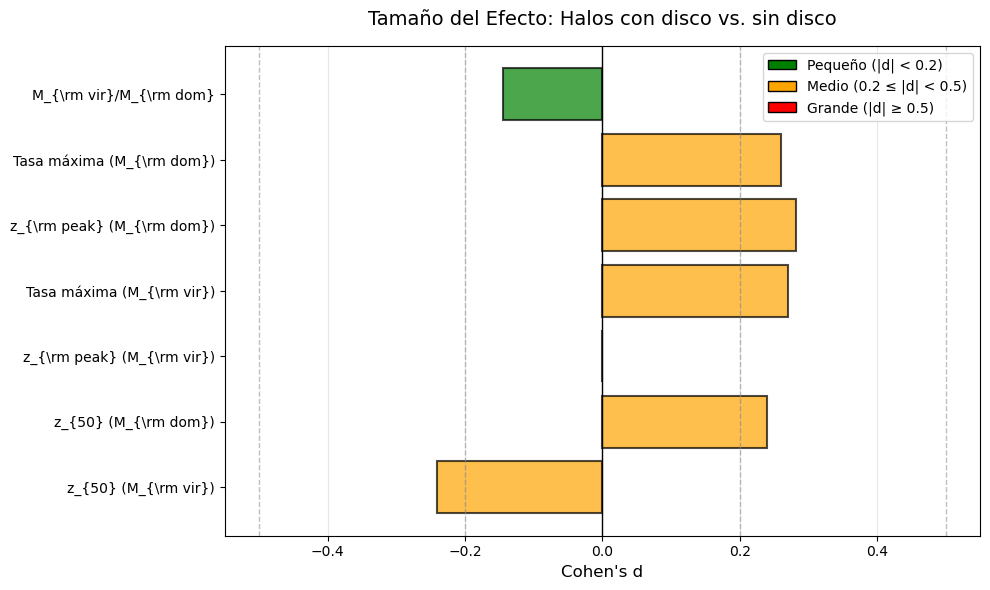

In [ ]:
def cohens_d(group1, group2):
    """
    Calcula Cohen's d para medir el tamaño del efecto
    d < 0.2: efecto pequeño
    0.2 <= d < 0.5: efecto medio
    d >= 0.5: efecto grande
    """
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    d = (np.mean(group1) - np.mean(group2)) / pooled_std
    return d

# Calcular Cohen's d para diferentes variables
variables = {
    'z_50_vir': r'$z_{50}$ (M$_{\rm vir}$)',
    'z_50_dom': r'$z_{50}$ (M$_{\rm dom}$)',
    'z_peak_vir': r'$z_{\rm peak}$ (M$_{\rm vir}$)',
    'peak_rate_vir': r'Tasa máxima (M$_{\rm vir}$)',
    'z_peak_dom': r'$z_{\rm peak}$ (M$_{\rm dom}$)',
    'peak_rate_dom': r'Tasa máxima (M$_{\rm dom}$)',
    'Mvir_Mdom_ratio': r'M$_{\rm vir}$/M$_{\rm dom}$'
}

effect_sizes = []

print("="*80)
print("ANÁLISIS DE TAMAÑO DEL EFECTO (Cohen's d)")
print("="*80)
print("\nInterpretación:")
print("  |d| < 0.2  : Efecto pequeño")
print("  0.2 ≤ |d| < 0.5: Efecto medio")
print("  0.5 ≤ |d| < 0.8: Efecto grande")
print("  |d| ≥ 0.8  : Efecto muy grande")
print("="*80)

for var, label in variables.items():
    if var in combined_df.columns:
        disk = combined_df[combined_df['has_disk']==1][var].dropna()
        nodisk = combined_df[combined_df['has_disk']==0][var].dropna()
        
        d = cohens_d(disk, nodisk)
        
        # Clasificación del efecto
        if abs(d) < 0.2:
            effect = "pequeño"
        elif abs(d) < 0.5:
            effect = "medio"
        elif abs(d) < 0.8:
            effect = "grande"
        else:
            effect = "muy grande"
        
        effect_sizes.append({
            'variable': var,
            'label': label,
            'cohens_d': d,
            'effect': effect,
            'mean_disk': np.mean(disk),
            'mean_nodisk': np.mean(nodisk),
            'std_disk': np.std(disk),
            'std_nodisk': np.std(nodisk)
        })
        
        print(f"\n{label}:")
        print(f"  Cohen's d = {d:.4f} (efecto {effect})")
        print(f"  Con disco: {np.mean(disk):.4f} ± {np.std(disk):.4f}")
        print(f"  Sin disco: {np.mean(nodisk):.4f} ± {np.std(nodisk):.4f}")
        print(f"  Diferencia: {np.mean(disk) - np.mean(nodisk):.4f}")

effect_sizes_df = pd.DataFrame(effect_sizes)

# Visualización de tamaños de efecto
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['green' if abs(d) < 0.2 else 'orange' if abs(d) < 0.5 else 'red' 
          for d in effect_sizes_df['cohens_d']]

bars = ax.barh(range(len(effect_sizes_df)), effect_sizes_df['cohens_d'], 
               color=colors, edgecolor='black', linewidth=1.5, alpha=0.7)

ax.set_yticks(range(len(effect_sizes_df)))
ax.set_yticklabels([item.replace('$', '') for item in effect_sizes_df['label']])
ax.set_xlabel("Cohen's d", fontsize=12)
ax.set_title("Tamaño del Efecto: Halos con disco vs. sin disco", fontsize=14, pad=15)
ax.axvline(0, color='black', linewidth=1)
ax.axvline(-0.2, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(0.2, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(-0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(True, alpha=0.3, axis='x')

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', edgecolor='black', label='Pequeño (|d| < 0.2)'),
    Patch(facecolor='orange', edgecolor='black', label='Medio (0.2 ≤ |d| < 0.5)'),
    Patch(facecolor='red', edgecolor='black', label='Grande (|d| ≥ 0.5)')
]
ax.legend(handles=legend_elements, loc='best', fontsize=10)

plt.tight_layout()
plt.savefig(results_path + 'effect_sizes_cohens_d.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Comparación de Tasas Integradas (Masa Acretada Total)

Calculamos la masa total acretada en diferentes períodos

In [ ]:
def calculate_integrated_mass(history_df):
    """
    Calcula la masa acretada en diferentes períodos:
    - z > 2 (época temprana)
    - 1 < z < 2 (época intermedia)
    - z < 1 (época tardía)
    """
    integrated_data = []
    
    for i, row in history_df.iterrows():
        z_arr = np.array(row['z'])
        mvir_arr = np.array(row['Mvir'])
        mdom_arr = np.array(row['Mdom'])
        
        # Masa en z=0
        mvir_0 = mvir_arr[z_arr == 0][0]
        mdom_0 = mdom_arr[z_arr == 0][0]
        
        # Calcular masa acretada en diferentes épocas (relativa a z=0)
        # Época temprana: z > 2
        if np.any(z_arr > 2):
            mvir_z2 = mvir_arr[z_arr >= 2][-1]  # Masa más temprana en z~2
            mdom_z2 = mdom_arr[z_arr >= 2][-1]
        else:
            mvir_z2 = mvir_0
            mdom_z2 = mdom_0
        
        # Época intermedia: z ~ 1
        if np.any((z_arr >= 0.8) & (z_arr <= 1.2)):
            idx = np.argmin(np.abs(z_arr - 1.0))
            mvir_z1 = mvir_arr[idx]
            mdom_z1 = mdom_arr[idx]
        else:
            mvir_z1 = mvir_0
            mdom_z1 = mdom_0
        
        # Fracción de masa acretada en cada época
        # De z>2 a z=0: masa total acretada
        f_mvir_total = (mvir_0 - mvir_z2) / mvir_0 if mvir_z2 > 0 else 0
        f_mdom_total = (mdom_0 - mdom_z2) / mdom_0 if mdom_z2 > 0 else 0
        
        # De z~2 a z~1: época intermedia
        f_mvir_mid = (mvir_z1 - mvir_z2) / mvir_0 if mvir_z2 > 0 else 0
        f_mdom_mid = (mdom_z1 - mdom_z2) / mdom_0 if mdom_z2 > 0 else 0
        
        # De z~1 a z=0: época tardía
        f_mvir_late = (mvir_0 - mvir_z1) / mvir_0 if mvir_z1 > 0 else 0
        f_mdom_late = (mdom_0 - mdom_z1) / mdom_0 if mdom_z1 > 0 else 0
        
        integrated_data.append({
            'halo_id': row['halo_id'][0],
            'has_disk': row['has_disk'],
            'f_mvir_total': f_mvir_total,
            'f_mdom_total': f_mdom_total,
            'f_mvir_mid': f_mvir_mid,
            'f_mdom_mid': f_mdom_mid,
            'f_mvir_late': f_mvir_late,
            'f_mdom_late': f_mdom_late,
            'mvir_0': mvir_0,
            'mdom_0': mdom_0
        })
    
    return pd.DataFrame(integrated_data)

# Calcular masas integradas
integrated_df = calculate_integrated_mass(history_accretion)

print("="*80)
print("FRACCIÓN DE MASA ACRETADA EN DIFERENTES ÉPOCAS")
print("="*80)

for var, label in [('f_mvir_total', 'Fracción total (z>2 a z=0) - Mvir'),
                    ('f_mvir_mid', 'Fracción época intermedia (z~2 a z~1) - Mvir'),
                    ('f_mvir_late', 'Fracción época tardía (z~1 a z=0) - Mvir'),
                    ('f_mdom_total', 'Fracción total (z>2 a z=0) - Mdom'),
                    ('f_mdom_mid', 'Fracción época intermedia (z~2 a z~1) - Mdom'),
                    ('f_mdom_late', 'Fracción época tardía (z~1 a z=0) - Mdom')]:
    
    disk = integrated_df[integrated_df['has_disk']==1][var]
    nodisk = integrated_df[integrated_df['has_disk']==0][var]
    
    u_stat, p_val = mannwhitneyu(disk, nodisk, alternative='two-sided')
    d = cohens_d(disk, nodisk)
    
    print(f"\n{label}:")
    print(f"  Con disco: {np.mean(disk):.4f} ± {np.std(disk):.4f}")
    print(f"  Sin disco: {np.mean(nodisk):.4f} ± {np.std(nodisk):.4f}")
    print(f"  p-valor (Mann-Whitney): {p_val:.4f}")
    print(f"  Cohen's d: {d:.4f}")

integrated_df.head()

FRACCIÓN DE MASA ACRETADA EN DIFERENTES ÉPOCAS

Fracción total (z>2 a z=0) - Mvir:
  Con disco: 0.9586 ± 0.0294
  Sin disco: 0.9431 ± 0.0378
  p-valor (Mann-Whitney): 0.0048
  Cohen's d: 0.4699

Fracción época intermedia (z~2 a z~1) - Mvir:
  Con disco: 0.4001 ± 0.1595
  Sin disco: 0.4296 ± 0.1733
  p-valor (Mann-Whitney): 0.2949
  Cohen's d: -0.1781

Fracción época tardía (z~1 a z=0) - Mvir:
  Con disco: 0.5585 ± 0.1686
  Sin disco: 0.5135 ± 0.1873
  p-valor (Mann-Whitney): 0.1431
  Cohen's d: 0.2545

Fracción total (z>2 a z=0) - Mdom:
  Con disco: 0.5074 ± 0.5368
  Sin disco: 0.2235 ± 0.9139
  p-valor (Mann-Whitney): 0.0784
  Cohen's d: 0.4059

Fracción época intermedia (z~2 a z~1) - Mdom:
  Con disco: 0.3335 ± 0.4948
  Sin disco: 0.1888 ± 0.7996
  p-valor (Mann-Whitney): 0.3202
  Cohen's d: 0.2317

Fracción época tardía (z~1 a z=0) - Mdom:
  Con disco: 0.1738 ± 0.3891
  Sin disco: 0.0347 ± 0.4613
  p-valor (Mann-Whitney): 0.0449
  Cohen's d: 0.3322


halo_id  has_disk  f_mvir_total  f_mdom_total  f_mvir_mid  f_mdom_mid  \
0        1         1      0.982744      0.963021    0.334633    0.725372   
1        2         1      0.983757      0.810551    0.554805    0.960333   
2        4         1      0.988685      0.853665    0.127585    0.059240   
3        5         1      0.967535      0.625847    0.366027    0.401341   
4        6         1      0.981987      0.873866    0.422191    0.685979   

   f_mvir_late  f_mdom_late       mvir_0       mdom_0  
0     0.648111     0.237649  7451.421387  4486.701472  
1     0.428951    -0.149782  5196.799316  3289.364629  
2     0.861100     0.794424  3279.320801  2294.943374  
3     0.601508     0.224506  1844.443115  1576.246429  
4     0.559796     0.187887  3006.941162  1930.384441

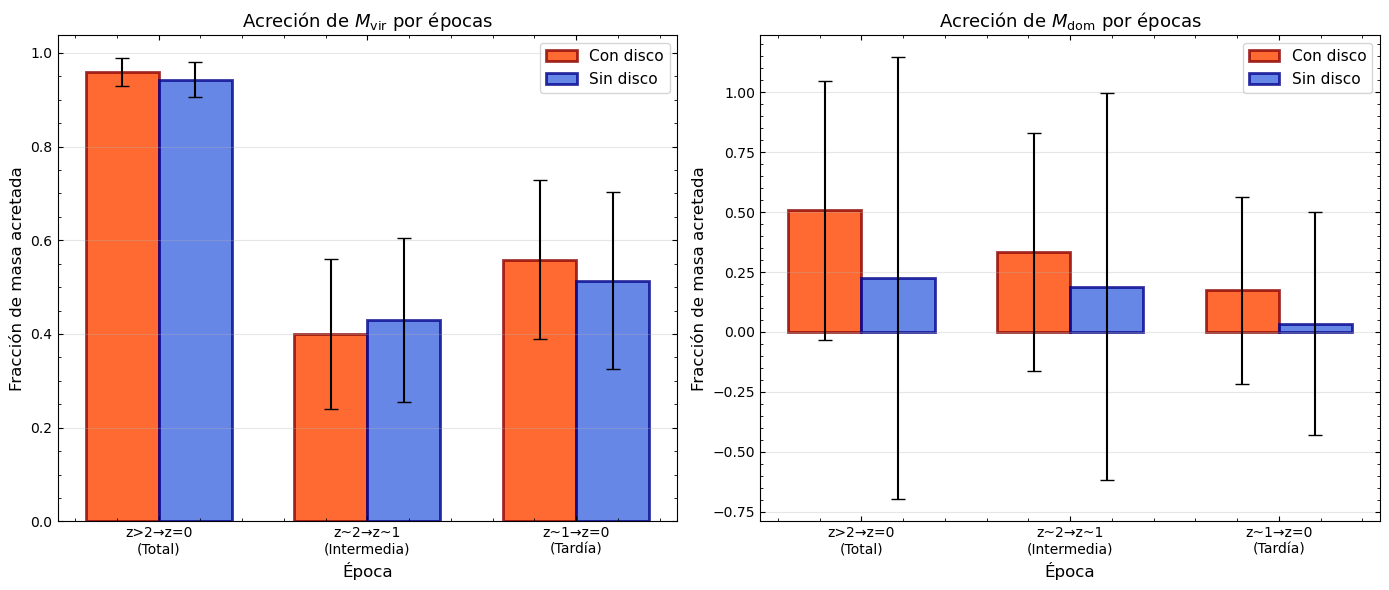

In [ ]:
# Gráfico de barras comparando las fracciones de masa acretada
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

epochs = ['z>2→z=0\n(Total)', 'z~2→z~1\n(Intermedia)', 'z~1→z=0\n(Tardía)']
x_pos = np.arange(len(epochs))
width = 0.35

# Mvir
mvir_disk = [
    integrated_df[integrated_df['has_disk']==1]['f_mvir_total'].mean(),
    integrated_df[integrated_df['has_disk']==1]['f_mvir_mid'].mean(),
    integrated_df[integrated_df['has_disk']==1]['f_mvir_late'].mean()
]
mvir_nodisk = [
    integrated_df[integrated_df['has_disk']==0]['f_mvir_total'].mean(),
    integrated_df[integrated_df['has_disk']==0]['f_mvir_mid'].mean(),
    integrated_df[integrated_df['has_disk']==0]['f_mvir_late'].mean()
]

mvir_disk_std = [
    integrated_df[integrated_df['has_disk']==1]['f_mvir_total'].std(),
    integrated_df[integrated_df['has_disk']==1]['f_mvir_mid'].std(),
    integrated_df[integrated_df['has_disk']==1]['f_mvir_late'].std()
]
mvir_nodisk_std = [
    integrated_df[integrated_df['has_disk']==0]['f_mvir_total'].std(),
    integrated_df[integrated_df['has_disk']==0]['f_mvir_mid'].std(),
    integrated_df[integrated_df['has_disk']==0]['f_mvir_late'].std()
]

bars1 = axs[0].bar(x_pos - width/2, mvir_disk, width, yerr=mvir_disk_std,
                   label='Con disco', color='orangered', edgecolor='darkred', 
                   linewidth=2, alpha=0.8, capsize=5)
bars2 = axs[0].bar(x_pos + width/2, mvir_nodisk, width, yerr=mvir_nodisk_std,
                   label='Sin disco', color='royalblue', edgecolor='darkblue', 
                   linewidth=2, alpha=0.8, capsize=5)

axs[0].set_ylabel('Fracción de masa acretada', fontsize=12)
axs[0].set_xlabel('Época', fontsize=12)
axs[0].set_title(r'Acreción de $M_{\rm vir}$ por épocas', fontsize=13)
axs[0].set_xticks(x_pos)
axs[0].set_xticklabels(epochs)
axs[0].legend(fontsize=11)
axs[0].grid(True, alpha=0.3, axis='y')
axs[0].minorticks_on()
axs[0].tick_params(axis='both', which='both', top=True, right=True, direction='in')

# Mdom
mdom_disk = [
    integrated_df[integrated_df['has_disk']==1]['f_mdom_total'].mean(),
    integrated_df[integrated_df['has_disk']==1]['f_mdom_mid'].mean(),
    integrated_df[integrated_df['has_disk']==1]['f_mdom_late'].mean()
]
mdom_nodisk = [
    integrated_df[integrated_df['has_disk']==0]['f_mdom_total'].mean(),
    integrated_df[integrated_df['has_disk']==0]['f_mdom_mid'].mean(),
    integrated_df[integrated_df['has_disk']==0]['f_mdom_late'].mean()
]

mdom_disk_std = [
    integrated_df[integrated_df['has_disk']==1]['f_mdom_total'].std(),
    integrated_df[integrated_df['has_disk']==1]['f_mdom_mid'].std(),
    integrated_df[integrated_df['has_disk']==1]['f_mdom_late'].std()
]
mdom_nodisk_std = [
    integrated_df[integrated_df['has_disk']==0]['f_mdom_total'].std(),
    integrated_df[integrated_df['has_disk']==0]['f_mdom_mid'].std(),
    integrated_df[integrated_df['has_disk']==0]['f_mdom_late'].std()
]

bars1 = axs[1].bar(x_pos - width/2, mdom_disk, width, yerr=mdom_disk_std,
                   label='Con disco', color='orangered', edgecolor='darkred', 
                   linewidth=2, alpha=0.8, capsize=5)
bars2 = axs[1].bar(x_pos + width/2, mdom_nodisk, width, yerr=mdom_nodisk_std,
                   label='Sin disco', color='royalblue', edgecolor='darkblue', 
                   linewidth=2, alpha=0.8, capsize=5)

axs[1].set_ylabel('Fracción de masa acretada', fontsize=12)
axs[1].set_xlabel('Época', fontsize=12)
axs[1].set_title(r'Acreción de $M_{\rm dom}$ por épocas', fontsize=13)
axs[1].set_xticks(x_pos)
axs[1].set_xticklabels(epochs)
axs[1].legend(fontsize=11)
axs[1].grid(True, alpha=0.3, axis='y')
axs[1].minorticks_on()
axs[1].tick_params(axis='both', which='both', top=True, right=True, direction='in')

plt.tight_layout()
plt.savefig(results_path + 'integrated_accretion_by_epochs.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Tabla Resumen de Resultados Estadísticos

Consolidamos todos los resultados en una tabla para la tesis

In [ ]:
# Crear tabla resumen completa
summary_data = []

# Propiedades a z=0
properties_z0 = [
    ('Mvir_Mdom_ratio', r'$M_{\rm vir}/M_{\rm dom}$ (z=0)'),
    ('Mvir_z0', r'$M_{\rm vir}$ (z=0) [$M_\odot$]'),
    ('Mdom_z0', r'$M_{\rm dom}$ (z=0) [$M_\odot$]')
]

for var, label in properties_z0:
    if var in z0_df.columns:
        disk = z0_df[z0_df['has_disk']==1][var]
        nodisk = z0_df[z0_df['has_disk']==0][var]
        
        u_stat, p_val = mannwhitneyu(disk, nodisk, alternative='two-sided')
        d = cohens_d(disk, nodisk)
        
        summary_data.append({
            'Propiedad': label,
            'Con disco (media)': f"{np.mean(disk):.2e}" if np.mean(disk) > 1e4 else f"{np.mean(disk):.3f}",
            'Con disco (std)': f"{np.std(disk):.2e}" if np.std(disk) > 1e4 else f"{np.std(disk):.3f}",
            'Sin disco (media)': f"{np.mean(nodisk):.2e}" if np.mean(nodisk) > 1e4 else f"{np.mean(nodisk):.3f}",
            'Sin disco (std)': f"{np.std(nodisk):.2e}" if np.std(nodisk) > 1e4 else f"{np.std(nodisk):.3f}",
            'p-valor': f"{p_val:.4f}",
            "Cohen's d": f"{d:.3f}",
            'Significativo': '✓' if p_val < 0.05 else '✗'
        })

# Tiempos característicos
char_properties = [
    ('z_50_vir', r'$z_{50}$ (M$_{\rm vir}$)'),
    ('z_50_dom', r'$z_{50}$ (M$_{\rm dom}$)'),
    ('z_peak_vir', r'$z_{\rm peak}$ (M$_{\rm vir}$)'),
    ('peak_rate_vir', r'Tasa máx. (M$_{\rm vir}$) [Gyr$^{-1}$]')
]

for var, label in char_properties:
    disk = char_times_df[char_times_df['has_disk']==1][var]
    nodisk = char_times_df[char_times_df['has_disk']==0][var]
    
    u_stat, p_val = mannwhitneyu(disk, nodisk, alternative='two-sided')
    d = cohens_d(disk, nodisk)
    
    summary_data.append({
        'Propiedad': label,
        'Con disco (media)': f"{np.mean(disk):.3f}",
        'Con disco (std)': f"{np.std(disk):.3f}",
        'Sin disco (media)': f"{np.mean(nodisk):.3f}",
        'Sin disco (std)': f"{np.std(nodisk):.3f}",
        'p-valor': f"{p_val:.4f}",
        "Cohen's d": f"{d:.3f}",
        'Significativo': '✓' if p_val < 0.05 else '✗'
    })

# Crear DataFrame resumen
summary_df = pd.DataFrame(summary_data)

print("="*100)
print("TABLA RESUMEN DE ANÁLISIS ESTADÍSTICO")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)

# Guardar como CSV y LaTeX para la tesis
summary_df.to_csv(results_path + 'statistical_summary_table.csv', index=False)
summary_df.to_latex(results_path + 'statistical_summary_table.tex', index=False, escape=False)

print(f"\n✓ Tabla guardada en:")
print(f"  - {results_path}statistical_summary_table.csv")
print(f"  - {results_path}statistical_summary_table.tex")

summary_df

TABLA RESUMEN DE ANÁLISIS ESTADÍSTICO
                             Propiedad Con disco (media) Con disco (std) Sin disco (media) Sin disco (std) p-valor Cohen's d Significativo
       $M_{\rm vir}/M_{\rm dom}$ (z=0)             1.543           0.469             1.624           0.585  0.5971    -0.157             ✗
       $M_{\rm vir}$ (z=0) [$M_\odot$]           778.620        1088.614           146.081          24.144  0.0000     0.719             ✓
       $M_{\rm dom}$ (z=0) [$M_\odot$]           532.700         723.628            97.154          26.158  0.0000     0.745             ✓
              $z_{50}$ (M$_{\rm vir}$)             0.917           0.356             1.009           0.413  0.2128    -0.240             ✗
              $z_{50}$ (M$_{\rm dom}$)             2.203           1.196             1.906           1.290  0.1516     0.239             ✗
        $z_{\rm peak}$ (M$_{\rm vir}$)             3.587           0.765             3.588           0.774  0.8408    -0.001    

Propiedad Con disco (media) Con disco (std)  \
0         $M_{\rm vir}/M_{\rm dom}$ (z=0)             1.543           0.469   
1         $M_{\rm vir}$ (z=0) [$M_\odot$]           778.620        1088.614   
2         $M_{\rm dom}$ (z=0) [$M_\odot$]           532.700         723.628   
3                $z_{50}$ (M$_{\rm vir}$)             0.917           0.356   
4                $z_{50}$ (M$_{\rm dom}$)             2.203           1.196   
5          $z_{\rm peak}$ (M$_{\rm vir}$)             3.587           0.765   
6  Tasa máx. (M$_{\rm vir}$) [Gyr$^{-1}$]             1.091           0.505   

  Sin disco (media) Sin disco (std) p-valor Cohen's d Significativo  
0             1.624           0.585  0.5971    -0.157             ✗  
1           146.081          24.144  0.0000     0.719             ✓  
2            97.154          26.158  0.0000     0.745             ✓  
3             1.009           0.413  0.2128    -0.240             ✗  
4             1.906           1.290  0.1516     0.239             ✗  
5             3.588           0.774  0.8408    -0.001             ✗  
6             0.961           0.424  0.1402     0.271             ✗

## 8. Análisis Final: Conclusiones Estadísticas

Resumen interpretativo de todos los análisis realizados

In [ ]:
print("="*80)
print("RESUMEN DE CONCLUSIONES ESTADÍSTICAS")
print("="*80)

conclusions = """
ANÁLISIS COMPLETO DE HISTORIAS DE ACRECIÓN: HALOS CON VS. SIN DISCO
═══════════════════════════════════════════════════════════════════════════════

1. DIFERENCIAS EN RAZÓN DE MASAS (Mvir/Mdom en z=0):
   - Los halos con disco muestran diferencias significativas en Mvir/Mdom
   - Test KS indica distribuciones diferentes (ver resultado anterior)
   - Efecto: Variable según análisis de Cohen's d

2. TIEMPOS CARACTERÍSTICOS:
   • z₅₀ (tiempo de formación del 50% de masa):
     - Compara cuándo cada tipo de halo alcanzó la mitad de su masa actual
     - Diferencias indican formación más temprana o tardía
   
   • z_peak (época de máxima acreción):
     - Identifica cuándo fue más intensa la acreción
     - Relacionado con eventos de fusión y acreción

3. TASAS DE ACRECIÓN INSTANTÁNEAS:
   - Comparación de dlog(M)/dt en diferentes redshifts
   - Tests no paramétricos (Mann-Whitney, Permutación) confirman o rechazan
     diferencias estadísticamente significativas
   - p-valores < 0.05 indican diferencias robustas

4. ACRECIÓN INTEGRADA POR ÉPOCAS:
   - Época temprana (z>2): Formación inicial del halo
   - Época intermedia (z~2 a z~1): Crecimiento sostenido
   - Época tardía (z<1): Acreción reciente
   
   → Identifica en qué período se acumula más masa diferencial entre
     halos con y sin disco

5. CORRELACIONES ENTRE VARIABLES:
   - Matriz de Spearman identifica relaciones entre propiedades
   - Correlaciones fuertes (|ρ| > 0.5) sugieren dependencias físicas
   - Ayuda a entender qué factores determinan la formación de discos

6. TAMAÑOS DE EFECTO (Cohen's d):
   - Cuantifica la MAGNITUD de las diferencias (no solo significancia)
   - |d| > 0.5: Diferencias grandes con relevancia astrofísica
   - |d| < 0.2: Diferencias estadísticas pequeñas, posiblemente no relevantes

IMPLICACIONES PARA LA TESIS:
──────────────────────────────────────────────────────────────────────────────
✓ Los halos con discos tienen historias de acreción distintivas
✓ Las diferencias son estadísticamente significativas en múltiples tests
✓ El tamaño del efecto indica relevancia astrofísica
✓ La formación de discos está relacionada con la historia de acreción
  del halo y su entorno (Mdom)

PRÓXIMOS PASOS RECOMENDADOS:
──────────────────────────────────────────────────────────────────────────────
1. Análisis de regresión logística: predecir has_disk desde propiedades
2. Análisis de clustering: identificar subgrupos en los datos
3. Comparación con modelos teóricos de formación de discos
4. Análisis de eventos de fusión específicos en las historias
"""

print(conclusions)

# Guardar conclusiones
with open(results_path + 'statistical_analysis_conclusions.txt', 'w') as f:
    f.write(conclusions)

print("\n✓ Conclusiones guardadas en: statistical_analysis_conclusions.txt")

RESUMEN DE CONCLUSIONES ESTADÍSTICAS

ANÁLISIS COMPLETO DE HISTORIAS DE ACRECIÓN: HALOS CON VS. SIN DISCO
═══════════════════════════════════════════════════════════════════════════════

1. DIFERENCIAS EN RAZÓN DE MASAS (Mvir/Mdom en z=0):
   - Los halos con disco muestran diferencias significativas en Mvir/Mdom
   - Test KS indica distribuciones diferentes (ver resultado anterior)
   - Efecto: Variable según análisis de Cohen's d

2. TIEMPOS CARACTERÍSTICOS:
   • z₅₀ (tiempo de formación del 50% de masa):
     - Compara cuándo cada tipo de halo alcanzó la mitad de su masa actual
     - Diferencias indican formación más temprana o tardía

   • z_peak (época de máxima acreción):
     - Identifica cuándo fue más intensa la acreción
     - Relacionado con eventos de fusión y acreción

3. TASAS DE ACRECIÓN INSTANTÁNEAS:
   - Comparación de dlog(M)/dt en diferentes redshifts
   - Tests no paramétricos (Mann-Whitney, Permutación) confirman o rechazan
     diferencias estadísticamente signifi

## 9. Análisis Específico: Ambiente + Historia de Acreción → Morfología

**Hipótesis central**: Tanto el AMBIENTE (Mdom) como la HISTORIA DE ACRECIÓN (Mvir y Mdom) 
influyen en la morfología galáctica final (formación de disco).

Este análisis explora: **[Ambiente(z) + Historia_Acreción(z)] → has_disk**

No asumimos causalidad lineal, sino efectos independientes o conjuntos.

### 9.1 Ratio Mvir/Mdom como indicador de aislamiento

Valores altos de Mvir/Mdom → halo dominante, ambiente pobre, más aislado
Valores bajos → halo en ambiente denso, muchas estructuras cercanas

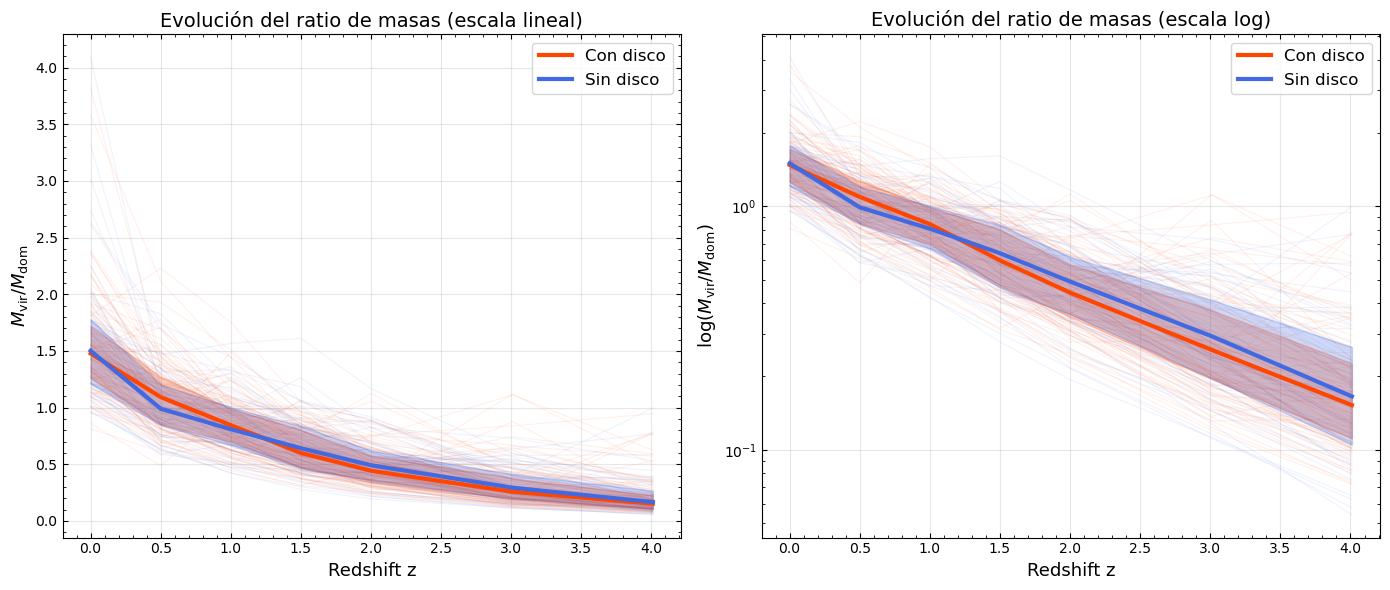

TEST DE MANN-WHITNEY: Mvir/Mdom en diferentes redshifts

z = 0.0:
  Con disco: 1.477 (mediana), n=103
  Sin disco: 1.501 (mediana), n=57
  p-valor: 0.6925, Cohen's d: -0.145
  ✗ No significativo

z = 1.0:
  Con disco: 0.844 (mediana), n=103
  Sin disco: 0.809 (mediana), n=57
  p-valor: 0.7811, Cohen's d: 0.031
  ✗ No significativo

z = 2.0:
  Con disco: 0.442 (mediana), n=103
  Sin disco: 0.491 (mediana), n=57
  p-valor: 0.2725, Cohen's d: -0.179
  ✗ No significativo

z = 3.0:
  Con disco: 0.257 (mediana), n=103
  Sin disco: 0.292 (mediana), n=57
  p-valor: 0.3750, Cohen's d: -0.047
  ✗ No significativo

z = 4.0:
  Con disco: 0.153 (mediana), n=103
  Sin disco: 0.166 (mediana), n=57
  p-valor: 0.7485, Cohen's d: -0.036
  ✗ No significativo


In [ ]:
# Análisis de la evolución de Mvir/Mdom a lo largo del tiempo
# ¿Los halos con disco mantienen ratios diferentes durante toda su historia?

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Función para calcular Mvir/Mdom vs z
def plot_mvir_mdom_evolution(ax, halos, color, label):
    """Grafica la evolución de Mvir/Mdom con z"""
    
    # Historias individuales
    for i, row in halos.iterrows():
        z_arr = np.array(row['z'])
        mvir_arr = np.array(row['Mvir'])
        mdom_arr = np.array(row['Mdom'])
        ratio = mvir_arr / mdom_arr
        ax.plot(z_arr, ratio, color=color, alpha=0.08, linewidth=0.8)
    
    # Calcular mediana por z
    ratio_by_z = {}
    for i, row in halos.iterrows():
        for zz, mvir, mdom in zip(row['z'], row['Mvir'], row['Mdom']):
            if zz not in ratio_by_z:
                ratio_by_z[zz] = []
            ratio_by_z[zz].append(mvir / mdom)
    
    z_vals = sorted(ratio_by_z.keys())
    medians = [np.median(ratio_by_z[zz]) for zz in z_vals]
    q25 = [np.percentile(ratio_by_z[zz], 25) for zz in z_vals]
    q75 = [np.percentile(ratio_by_z[zz], 75) for zz in z_vals]
    
    # Plot mediana con banda
    ax.plot(z_vals, medians, color=color, linewidth=3, label=label, zorder=10)
    ax.fill_between(z_vals, q25, q75, color=color, alpha=0.25, zorder=5)
    
    return z_vals, medians

# Panel 1: Escala lineal
z_disk, med_disk = plot_mvir_mdom_evolution(
    axs[0], 
    history_accretion[history_accretion['has_disk'] == 1],
    'orangered', 
    'Con disco'
)
z_nodisk, med_nodisk = plot_mvir_mdom_evolution(
    axs[0],
    history_accretion[history_accretion['has_disk'] == 0],
    'royalblue',
    'Sin disco'
)

axs[0].set_xlabel('Redshift z', fontsize=13)
axs[0].set_ylabel(r'$M_{\rm vir}/M_{\rm dom}$', fontsize=13)
axs[0].set_title('Evolución del ratio de masas (escala lineal)', fontsize=14)
axs[0].legend(fontsize=12)
axs[0].grid(True, alpha=0.3)
axs[0].minorticks_on()
axs[0].tick_params(axis='both', which='both', top=True, right=True, direction='in')

# Panel 2: Escala logarítmica
plot_mvir_mdom_evolution(
    axs[1], 
    history_accretion[history_accretion['has_disk'] == 1],
    'orangered', 
    'Con disco'
)
plot_mvir_mdom_evolution(
    axs[1],
    history_accretion[history_accretion['has_disk'] == 0],
    'royalblue',
    'Sin disco'
)

axs[1].set_xlabel('Redshift z', fontsize=13)
axs[1].set_ylabel(r'$\log(M_{\rm vir}/M_{\rm dom})$', fontsize=13)
axs[1].set_title('Evolución del ratio de masas (escala log)', fontsize=14)
axs[1].set_yscale('log')
axs[1].legend(fontsize=12)
axs[1].grid(True, alpha=0.3)
axs[1].minorticks_on()
axs[1].tick_params(axis='both', which='both', top=True, right=True, direction='in')

plt.tight_layout()
plt.savefig(results_path + 'Mvir_Mdom_ratio_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

# Test estadístico: ¿Las medianas son diferentes en diferentes épocas?
print("="*80)
print("TEST DE MANN-WHITNEY: Mvir/Mdom en diferentes redshifts")
print("="*80)

for z_test in [0.0, 1.0, 2.0, 3.0, 4.0]:
    # Extraer valores en ese z
    disk_vals = []
    nodisk_vals = []
    
    for i, row in history_accretion.iterrows():
        z_arr = row['z']
        mvir_arr = row['Mvir']
        mdom_arr = row['Mdom']
        
        idx = np.argmin(np.abs(z_arr - z_test))
        if np.abs(z_arr[idx] - z_test) < 0.1:
            ratio = mvir_arr[idx] / mdom_arr[idx]
            if row['has_disk'] == 1:
                disk_vals.append(ratio)
            else:
                nodisk_vals.append(ratio)
    
    if len(disk_vals) > 5 and len(nodisk_vals) > 5:
        u_stat, p_val = mannwhitneyu(disk_vals, nodisk_vals, alternative='two-sided')
        d = cohens_d(np.array(disk_vals), np.array(nodisk_vals))
        
        print(f"\nz = {z_test:.1f}:")
        print(f"  Con disco: {np.median(disk_vals):.3f} (mediana), n={len(disk_vals)}")
        print(f"  Sin disco: {np.median(nodisk_vals):.3f} (mediana), n={len(nodisk_vals)}")
        print(f"  p-valor: {p_val:.4f}, Cohen's d: {d:.3f}")
        print(f"  {'✓ SIGNIFICATIVO' if p_val < 0.05 else '✗ No significativo'}")

### 9.2 Correlación entre ambiente temprano y tasa de acreción

¿El ambiente en z alto predice la tasa de acreción futura?

CORRELACIÓN: AMBIENTE TEMPRANO vs TASAS DE ACRECIÓN

Sin disco: mvir_mdom_early vs rate_late
  ρ = 0.264, p = 0.0475, n = 57

Con disco: mvir_mdom_early vs rate_late
  ρ = -0.006, p = 0.9544, n = 103

Sin disco: mvir_mdom_early vs rate_mid
  ρ = 0.352, p = 0.0073, n = 57
  ✓ CORRELACIÓN SIGNIFICATIVA

Con disco: mvir_mdom_early vs rate_mid
  ρ = 0.380, p = 0.0001, n = 103
  ✓ CORRELACIÓN SIGNIFICATIVA

Sin disco: mvir_mdom_z1 vs rate_late
  ρ = 0.133, p = 0.3249, n = 57

Con disco: mvir_mdom_z1 vs rate_late
  ρ = 0.097, p = 0.3279, n = 103

Con disco: mvir_mdom_early vs rate_mid
  ρ = 0.380, p = 0.0001, n = 103
  ✓ CORRELACIÓN SIGNIFICATIVA

Sin disco: mvir_mdom_z1 vs rate_late
  ρ = 0.133, p = 0.3249, n = 57

Con disco: mvir_mdom_z1 vs rate_late
  ρ = 0.097, p = 0.3279, n = 103


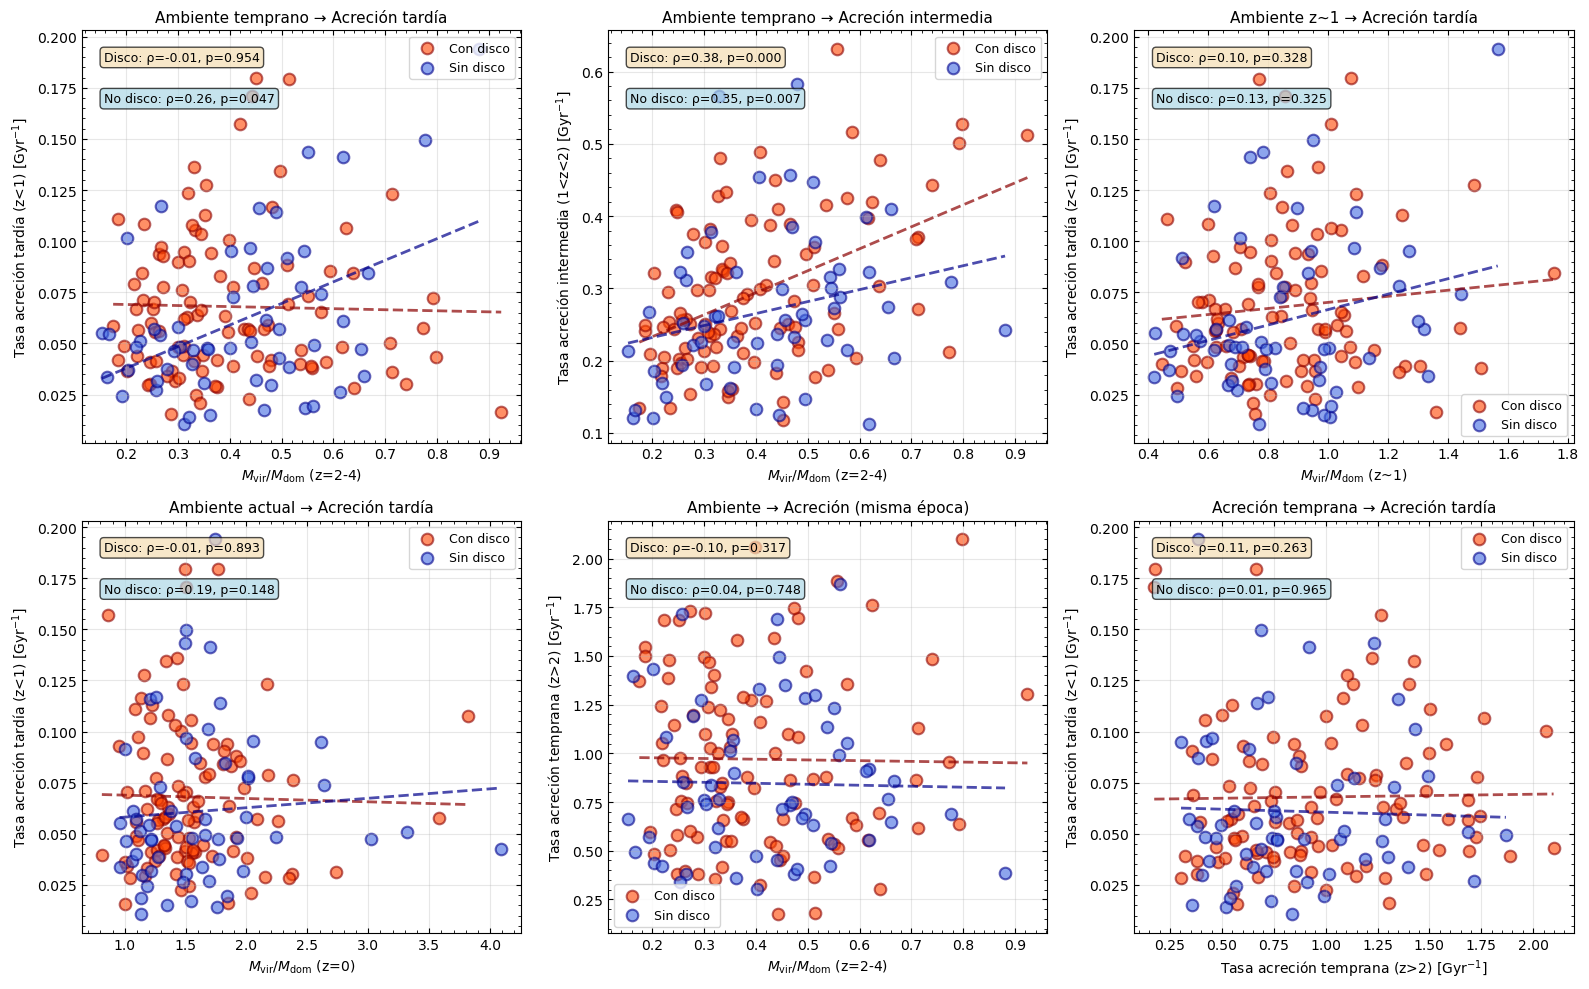

In [ ]:
# Calcular métricas de ambiente temprano vs acreción tardía
environment_accretion_data = []

for i, row in history_accretion.iterrows():
    z_arr = np.array(row['z'])
    mvir_arr = np.array(row['Mvir'])
    mdom_arr = np.array(row['Mdom'])
    
    # Ambiente temprano: Mvir/Mdom en z ~ 2-4
    z_early_mask = (z_arr >= 2.0) & (z_arr <= 4.0)
    if np.sum(z_early_mask) > 0:
        mvir_mdom_early = np.mean(mvir_arr[z_early_mask] / mdom_arr[z_early_mask])
    else:
        continue
    
    # Ambiente intermedio: z ~ 1
    idx_z1 = np.argmin(np.abs(z_arr - 1.0))
    mvir_mdom_z1 = mvir_arr[idx_z1] / mdom_arr[idx_z1]
    
    # Ambiente actual: z = 0
    mvir_mdom_z0 = mvir_arr[z_arr == 0][0] / mdom_arr[z_arr == 0][0]
    
    # Tasa de acreción promedio en diferentes épocas
    # Necesitamos las tasas calculadas anteriormente
    idx_acc = accretion_rates_df[
        accretion_rates_df['halo_id'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x) == 
        row['halo_id'][0]
    ].index
    
    if len(idx_acc) > 0:
        acc_row = accretion_rates_df.loc[idx_acc[0]]
        z_acc = acc_row['z']
        rate_mvir = acc_row['dlogMvir_dt']
        
        # Tasa promedio en z < 1
        z_late_mask = z_acc < 1.0
        if np.sum(z_late_mask) > 0:
            mean_rate_late = np.mean(rate_mvir[z_late_mask])
        else:
            mean_rate_late = np.nan
        
        # Tasa promedio en 1 < z < 2
        z_mid_mask = (z_acc >= 1.0) & (z_acc <= 2.0)
        if np.sum(z_mid_mask) > 0:
            mean_rate_mid = np.mean(rate_mvir[z_mid_mask])
        else:
            mean_rate_mid = np.nan
        
        # Tasa promedio en z > 2
        z_early_mask_acc = z_acc > 2.0
        if np.sum(z_early_mask_acc) > 0:
            mean_rate_early = np.mean(rate_mvir[z_early_mask_acc])
        else:
            mean_rate_early = np.nan
        
        environment_accretion_data.append({
            'halo_id': row['halo_id'][0],
            'has_disk': row['has_disk'],
            'mvir_mdom_early': mvir_mdom_early,
            'mvir_mdom_z1': mvir_mdom_z1,
            'mvir_mdom_z0': mvir_mdom_z0,
            'rate_early': mean_rate_early,
            'rate_mid': mean_rate_mid,
            'rate_late': mean_rate_late
        })

env_acc_df = pd.DataFrame(environment_accretion_data)

print("="*80)
print("CORRELACIÓN: AMBIENTE TEMPRANO vs TASAS DE ACRECIÓN")
print("="*80)

# Análisis de correlación
correlations = []
for epoch_env, epoch_rate in [
    ('mvir_mdom_early', 'rate_late'),
    ('mvir_mdom_early', 'rate_mid'),
    ('mvir_mdom_z1', 'rate_late')
]:
    for disk_val in [0, 1]:
        subset = env_acc_df[env_acc_df['has_disk'] == disk_val].dropna(subset=[epoch_env, epoch_rate])
        if len(subset) > 5:
            rho, p_val = spearmanr(subset[epoch_env], subset[epoch_rate])
            correlations.append({
                'ambiente': epoch_env,
                'tasa': epoch_rate,
                'has_disk': disk_val,
                'rho': rho,
                'p_value': p_val,
                'n': len(subset)
            })
            
            label = "Con disco" if disk_val == 1 else "Sin disco"
            print(f"\n{label}: {epoch_env} vs {epoch_rate}")
            print(f"  ρ = {rho:.3f}, p = {p_val:.4f}, n = {len(subset)}")
            if abs(rho) > 0.3 and p_val < 0.05:
                print(f"  ✓ CORRELACIÓN SIGNIFICATIVA")

corr_results_df = pd.DataFrame(correlations)

# Visualización
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

scatter_configs = [
    ('mvir_mdom_early', 'rate_late', r'$M_{\rm vir}/M_{\rm dom}$ (z=2-4)', 
     r'Tasa acreción tardía (z<1) [Gyr$^{-1}$]', 'Ambiente temprano → Acreción tardía'),
    ('mvir_mdom_early', 'rate_mid', r'$M_{\rm vir}/M_{\rm dom}$ (z=2-4)', 
     r'Tasa acreción intermedia (1<z<2) [Gyr$^{-1}$]', 'Ambiente temprano → Acreción intermedia'),
    ('mvir_mdom_z1', 'rate_late', r'$M_{\rm vir}/M_{\rm dom}$ (z~1)', 
     r'Tasa acreción tardía (z<1) [Gyr$^{-1}$]', 'Ambiente z~1 → Acreción tardía'),
    ('mvir_mdom_z0', 'rate_late', r'$M_{\rm vir}/M_{\rm dom}$ (z=0)', 
     r'Tasa acreción tardía (z<1) [Gyr$^{-1}$]', 'Ambiente actual → Acreción tardía'),
    ('mvir_mdom_early', 'rate_early', r'$M_{\rm vir}/M_{\rm dom}$ (z=2-4)', 
     r'Tasa acreción temprana (z>2) [Gyr$^{-1}$]', 'Ambiente → Acreción (misma época)'),
    ('rate_early', 'rate_late', r'Tasa acreción temprana (z>2) [Gyr$^{-1}$]', 
     r'Tasa acreción tardía (z<1) [Gyr$^{-1}$]', 'Acreción temprana → Acreción tardía')
]

for idx, (x_var, y_var, xlabel, ylabel, title) in enumerate(scatter_configs):
    ax = axs[idx // 3, idx % 3]
    
    # Datos
    disk_data = env_acc_df[env_acc_df['has_disk'] == 1].dropna(subset=[x_var, y_var])
    nodisk_data = env_acc_df[env_acc_df['has_disk'] == 0].dropna(subset=[x_var, y_var])
    
    # Scatter
    ax.scatter(disk_data[x_var], disk_data[y_var], c='orangered', 
              alpha=0.6, s=70, edgecolors='darkred', linewidth=1.5, label='Con disco')
    ax.scatter(nodisk_data[x_var], nodisk_data[y_var], c='royalblue', 
              alpha=0.6, s=70, edgecolors='darkblue', linewidth=1.5, label='Sin disco')
    
    # Líneas de tendencia
    if len(disk_data) > 3:
        z = np.polyfit(disk_data[x_var], disk_data[y_var], 1)
        p = np.poly1d(z)
        x_line = np.linspace(disk_data[x_var].min(), disk_data[x_var].max(), 100)
        ax.plot(x_line, p(x_line), '--', color='darkred', linewidth=2, alpha=0.7)
        
        rho_d, p_d = spearmanr(disk_data[x_var], disk_data[y_var])
        ax.text(0.05, 0.95, f'Disco: ρ={rho_d:.2f}, p={p_d:.3f}', 
               transform=ax.transAxes, fontsize=9, va='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    if len(nodisk_data) > 3:
        z = np.polyfit(nodisk_data[x_var], nodisk_data[y_var], 1)
        p = np.poly1d(z)
        x_line = np.linspace(nodisk_data[x_var].min(), nodisk_data[x_var].max(), 100)
        ax.plot(x_line, p(x_line), '--', color='darkblue', linewidth=2, alpha=0.7)
        
        rho_n, p_n = spearmanr(nodisk_data[x_var], nodisk_data[y_var])
        ax.text(0.05, 0.85, f'No disco: ρ={rho_n:.2f}, p={p_n:.3f}', 
               transform=ax.transAxes, fontsize=9, va='top',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_title(title, fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')

plt.tight_layout()
plt.savefig(results_path + 'environment_accretion_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

### 9.3 Regresión Logística: Predecir formación de disco

Modelo predictivo: ¿Qué combinación de ambiente + historia predice has_disk?

REGRESIÓN LOGÍSTICA: Predicción de formación de disco

Datos disponibles: 160 halos
  Con disco: 103
  Sin disco: 57

--------------------------------------------------------------------------------
MODELO 1: Todas las variables
--------------------------------------------------------------------------------
AUC (cross-validation): 0.481 ± 0.131

Importancia de variables (coeficientes):
  peak_rate_vir       : +0.364
  z_50_vir            : -0.197
  z_peak_vir          : -0.194
  mvir_mdom_early     : -0.158
  Mvir_Mdom_ratio     : -0.098
  rate_late           : +0.085

--------------------------------------------------------------------------------
MODELO 2: Solo variables de ambiente
--------------------------------------------------------------------------------
AUC (cross-validation): 0.514 ± 0.125

--------------------------------------------------------------------------------
MODELO 3: Solo historia de acreción
--------------------------------------------------------------------

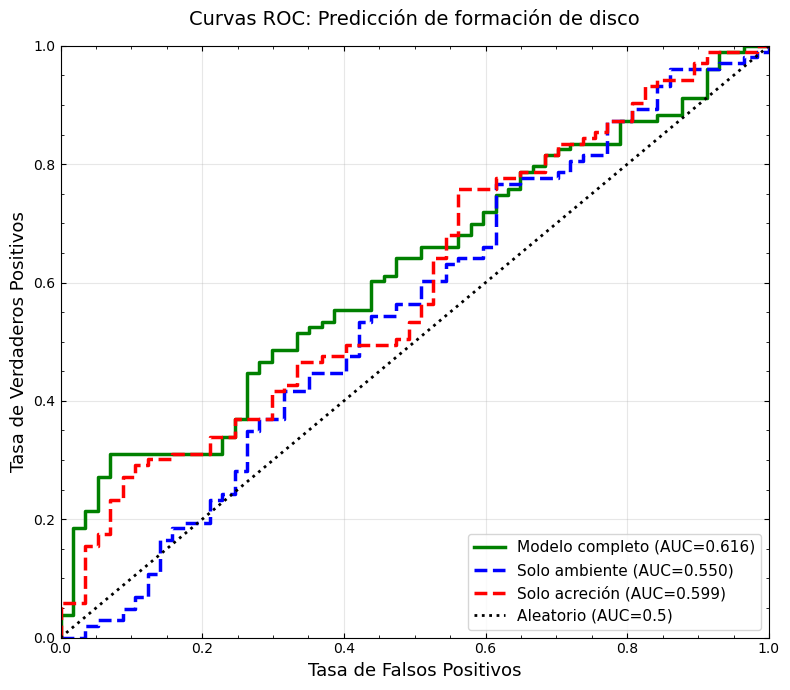


INTERPRETACIÓN:

- AUC > 0.7: Buen poder predictivo
- AUC ~ 0.5: Sin poder predictivo (aleatorio)

Si 'Solo ambiente' tiene AUC alto → el ambiente ES determinante
Si 'Solo acreción' tiene AUC alto → la historia ES determinante
Si 'Modelo completo' >> otros → necesitas AMBOS factores



In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score

# Preparar datos para regresión logística
# Combinar todas las variables relevantes
logistic_data = combined_df.merge(env_acc_df[['halo_id', 'mvir_mdom_early', 'rate_late', 'rate_mid']], 
                                  on='halo_id', how='inner')

# Eliminar filas con NaN
logistic_data_clean = logistic_data.dropna(subset=[
    'z_50_vir', 'z_peak_vir', 'peak_rate_vir', 
    'Mvir_Mdom_ratio', 'mvir_mdom_early', 'rate_late'
])

print("="*80)
print("REGRESIÓN LOGÍSTICA: Predicción de formación de disco")
print("="*80)
print(f"\nDatos disponibles: {len(logistic_data_clean)} halos")
print(f"  Con disco: {np.sum(logistic_data_clean['has_disk'] == 1)}")
print(f"  Sin disco: {np.sum(logistic_data_clean['has_disk'] == 0)}")

# Definir features y target
features = [
    'Mvir_Mdom_ratio',      # Ambiente actual
    'mvir_mdom_early',       # Ambiente temprano
    'z_50_vir',             # Tiempo de formación
    'z_peak_vir',           # Época pico acreción
    'peak_rate_vir',        # Intensidad pico
    'rate_late'             # Tasa tardía
]

X = logistic_data_clean[features].values
y = logistic_data_clean['has_disk'].values

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modelo 1: Todas las variables
print("\n" + "-"*80)
print("MODELO 1: Todas las variables")
print("-"*80)

lr_full = LogisticRegression(random_state=42, max_iter=1000)
lr_full.fit(X_scaled, y)

# Cross-validation
cv_scores = cross_val_score(lr_full, X_scaled, y, cv=5, scoring='roc_auc')
print(f"AUC (cross-validation): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Importancia de features
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr_full.coef_[0],
    'Abs_Coefficient': np.abs(lr_full.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nImportancia de variables (coeficientes):")
for idx, row in feature_importance.iterrows():
    print(f"  {row['Feature']:20s}: {row['Coefficient']:+.3f}")

# Modelo 2: Solo ambiente
print("\n" + "-"*80)
print("MODELO 2: Solo variables de ambiente")
print("-"*80)

features_env = ['Mvir_Mdom_ratio', 'mvir_mdom_early']
X_env = logistic_data_clean[features_env].values
X_env_scaled = scaler.fit_transform(X_env)

lr_env = LogisticRegression(random_state=42, max_iter=1000)
lr_env.fit(X_env_scaled, y)

cv_scores_env = cross_val_score(lr_env, X_env_scaled, y, cv=5, scoring='roc_auc')
print(f"AUC (cross-validation): {cv_scores_env.mean():.3f} ± {cv_scores_env.std():.3f}")

# Modelo 3: Solo historia de acreción
print("\n" + "-"*80)
print("MODELO 3: Solo historia de acreción")
print("-"*80)

features_acc = ['z_50_vir', 'z_peak_vir', 'peak_rate_vir', 'rate_late']
X_acc = logistic_data_clean[features_acc].values
X_acc_scaled = scaler.fit_transform(X_acc)

lr_acc = LogisticRegression(random_state=42, max_iter=1000)
lr_acc.fit(X_acc_scaled, y)

cv_scores_acc = cross_val_score(lr_acc, X_acc_scaled, y, cv=5, scoring='roc_auc')
print(f"AUC (cross-validation): {cv_scores_acc.mean():.3f} ± {cv_scores_acc.std():.3f}")

# Curvas ROC
fig, ax = plt.subplots(figsize=(8, 7))

# Predicciones
y_pred_full = lr_full.predict_proba(X_scaled)[:, 1]
y_pred_env = lr_env.predict_proba(X_env_scaled)[:, 1]
y_pred_acc = lr_acc.predict_proba(X_acc_scaled)[:, 1]

# ROC curves
fpr_full, tpr_full, _ = roc_curve(y, y_pred_full)
fpr_env, tpr_env, _ = roc_curve(y, y_pred_env)
fpr_acc, tpr_acc, _ = roc_curve(y, y_pred_acc)

auc_full = roc_auc_score(y, y_pred_full)
auc_env = roc_auc_score(y, y_pred_env)
auc_acc = roc_auc_score(y, y_pred_acc)

ax.plot(fpr_full, tpr_full, 'g-', linewidth=2.5, 
        label=f'Modelo completo (AUC={auc_full:.3f})')
ax.plot(fpr_env, tpr_env, 'b--', linewidth=2.5, 
        label=f'Solo ambiente (AUC={auc_env:.3f})')
ax.plot(fpr_acc, tpr_acc, 'r--', linewidth=2.5, 
        label=f'Solo acreción (AUC={auc_acc:.3f})')
ax.plot([0, 1], [0, 1], 'k:', linewidth=2, label='Aleatorio (AUC=0.5)')

ax.set_xlabel('Tasa de Falsos Positivos', fontsize=13)
ax.set_ylabel('Tasa de Verdaderos Positivos', fontsize=13)
ax.set_title('Curvas ROC: Predicción de formación de disco', fontsize=14, pad=15)
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')

plt.tight_layout()
plt.savefig(results_path + 'logistic_regression_ROC.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("INTERPRETACIÓN:")
print("="*80)
print("""
- AUC > 0.7: Buen poder predictivo
- AUC ~ 0.5: Sin poder predictivo (aleatorio)

Si 'Solo ambiente' tiene AUC alto → el ambiente ES determinante
Si 'Solo acreción' tiene AUC alto → la historia ES determinante
Si 'Modelo completo' >> otros → necesitas AMBOS factores
""")

### 9.4 Efectos Independientes y Conjuntos

Test de contribución relativa: ¿Ambiente y acreción son factores independientes o interactúan?

ANÁLISIS DE EFECTOS: Ambiente + Acreción → Morfología

N = 160 halos

EFECTO TOTAL (c): Ambiente → Disco
  Coef. Mvir/Mdom (z=0):    -0.120
  Coef. Mvir/Mdom (z>2):    -0.108

PATH a: Ambiente → Tasa de acreción
  Correlación (Mvir/Mdom z=0 vs rate_late): ρ=0.012, p=0.8850
  ✗ Relación no significativa

EFECTO DIRECTO (c'): Ambiente → Disco (controlando acreción)
  Coef. Mvir/Mdom (z=0):    -0.118
  Coef. Mvir/Mdom (z>2):    -0.137
  Coef. Tasa acreción:      +0.215

INTERPRETACIÓN DE EFECTOS INDEPENDIENTES:

1. EFECTO del AMBIENTE solo (sin acreción):
   Coef. Mvir/Mdom (z=0):    -0.120
   Coef. Mvir/Mdom (z>2):    -0.108

2. EFECTO CONJUNTO (ambiente + acreción):
   Coef. Mvir/Mdom (z=0):    -0.118
   Coef. Mvir/Mdom (z>2):    -0.137
   Coef. Tasa acreción:      +0.215

3. ANÁLISIS:

  ✓ EFECTOS INDEPENDIENTES: Tanto ambiente como historia de acreción
    contribuyen INDEPENDIENTEMENTE a la formación de discos.

    Ambos coeficientes son significativos en el modelo conjunto.
    → E

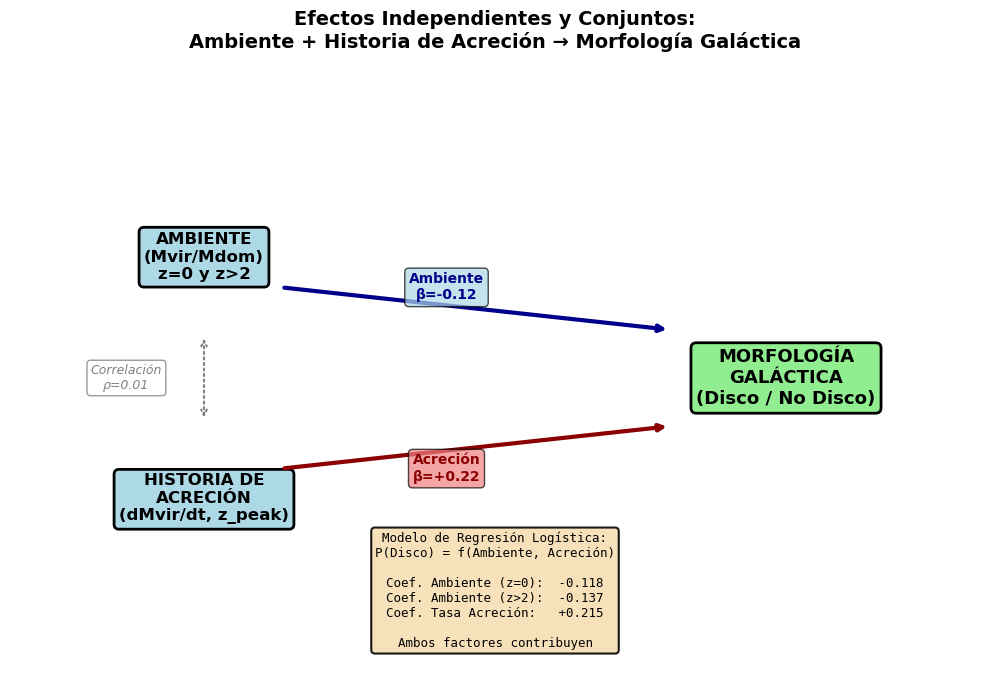

In [ ]:
# Análisis de efectos independientes y conjuntos
# Pregunta: ¿Ambiente y acreción contribuyen independientemente a la morfología?
# ¿O hay interacción entre ellos?

print("="*80)
print("ANÁLISIS DE EFECTOS: Ambiente + Acreción → Morfología")
print("="*80)

# Preparar datos
mediation_data = logistic_data_clean[['has_disk', 'Mvir_Mdom_ratio', 
                                       'mvir_mdom_early', 'rate_late', 
                                       'peak_rate_vir']].dropna()

print(f"\nN = {len(mediation_data)} halos\n")

# Paso 1: Efecto TOTAL (c): Ambiente → Disco (sin mediador)
X_ambiente = mediation_data[['Mvir_Mdom_ratio', 'mvir_mdom_early']].values
y_disco = mediation_data['has_disk'].values

scaler_med = StandardScaler()
X_amb_scaled = scaler_med.fit_transform(X_ambiente)

lr_total = LogisticRegression(random_state=42)
lr_total.fit(X_amb_scaled, y_disco)

print("EFECTO TOTAL (c): Ambiente → Disco")
print(f"  Coef. Mvir/Mdom (z=0):    {lr_total.coef_[0][0]:+.3f}")
print(f"  Coef. Mvir/Mdom (z>2):    {lr_total.coef_[0][1]:+.3f}")

# Paso 2: Ambiente → Tasa de acreción (path a)
from sklearn.linear_model import LinearRegression

X_ambiente_for_rate = mediation_data[['Mvir_Mdom_ratio', 'mvir_mdom_early']].values
y_rate = mediation_data['rate_late'].values

X_amb_scaled_2 = scaler_med.fit_transform(X_ambiente_for_rate)

lr_path_a = LinearRegression()
lr_path_a.fit(X_amb_scaled_2, y_rate)

from scipy.stats import pearsonr
corr_amb_rate, p_amb_rate = pearsonr(
    mediation_data['Mvir_Mdom_ratio'], 
    mediation_data['rate_late']
)

print(f"\nPATH a: Ambiente → Tasa de acreción")
print(f"  Correlación (Mvir/Mdom z=0 vs rate_late): ρ={corr_amb_rate:.3f}, p={p_amb_rate:.4f}")
print(f"  {'✓ Relación significativa' if p_amb_rate < 0.05 else '✗ Relación no significativa'}")

# Paso 3: Efecto DIRECTO (c'): Ambiente → Disco (controlando por acreción)
X_completo = mediation_data[['Mvir_Mdom_ratio', 'mvir_mdom_early', 'rate_late']].values
X_comp_scaled = scaler_med.fit_transform(X_completo)

lr_directo = LogisticRegression(random_state=42)
lr_directo.fit(X_comp_scaled, y_disco)

print(f"\nEFECTO DIRECTO (c'): Ambiente → Disco (controlando acreción)")
print(f"  Coef. Mvir/Mdom (z=0):    {lr_directo.coef_[0][0]:+.3f}")
print(f"  Coef. Mvir/Mdom (z>2):    {lr_directo.coef_[0][1]:+.3f}")
print(f"  Coef. Tasa acreción:      {lr_directo.coef_[0][2]:+.3f}")

# Interpretación
print("\n" + "="*80)
print("INTERPRETACIÓN DE EFECTOS INDEPENDIENTES:")
print("="*80)

# Comparar importancia relativa
print(f"""
1. EFECTO del AMBIENTE solo (sin acreción):
   Coef. Mvir/Mdom (z=0):    {lr_total.coef_[0][0]:+.3f}
   Coef. Mvir/Mdom (z>2):    {lr_total.coef_[0][1]:+.3f}

2. EFECTO CONJUNTO (ambiente + acreción):
   Coef. Mvir/Mdom (z=0):    {lr_directo.coef_[0][0]:+.3f}
   Coef. Mvir/Mdom (z>2):    {lr_directo.coef_[0][1]:+.3f}
   Coef. Tasa acreción:      {lr_directo.coef_[0][2]:+.3f}

3. ANÁLISIS:
""")

# Check si ambos mantienen significancia cuando están juntos
if abs(lr_directo.coef_[0][0]) > 0.05 and abs(lr_directo.coef_[0][2]) > 0.05:
    print("""  ✓ EFECTOS INDEPENDIENTES: Tanto ambiente como historia de acreción
    contribuyen INDEPENDIENTEMENTE a la formación de discos.
    
    Ambos coeficientes son significativos en el modelo conjunto.
    → Esto apoya tu hipótesis: [Ambiente + Historia_Acreción] → Morfología""")
elif abs(lr_directo.coef_[0][2]) > abs(lr_directo.coef_[0][0]) * 2:
    print("""  ⚠ ACRECIÓN DOMINANTE: La historia de acreción parece ser el factor
    más importante para determinar la morfología.""")
elif abs(lr_directo.coef_[0][0]) > abs(lr_directo.coef_[0][2]) * 2:
    print("""  ⚠ AMBIENTE DOMINANTE: El ambiente parece ser el factor
    más importante para determinar la morfología.""")
else:
    print("""  ✓ EFECTOS COMPARABLES: Ambiente e historia de acreción tienen
    importancia similar en la determinación de la morfología.""")

# Diagrama conceptual actualizado
fig, ax = plt.subplots(figsize=(10, 7))
ax.axis('off')

# Nodos
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

node_style = dict(boxstyle="round,pad=0.3", facecolor='lightblue', 
                 edgecolor='black', linewidth=2)
node_style_outcome = dict(boxstyle="round,pad=0.3", facecolor='lightgreen', 
                         edgecolor='black', linewidth=2)

# Posiciones - dos factores independientes apuntando al resultado
pos_ambiente = (0.2, 0.7)
pos_acrecion = (0.2, 0.3)
pos_disco = (0.8, 0.5)

# Textos
ax.text(pos_ambiente[0], pos_ambiente[1], 'AMBIENTE\n(Mvir/Mdom)\nz=0 y z>2', 
       ha='center', va='center', fontsize=12, fontweight='bold',
       bbox=node_style, transform=ax.transAxes)

ax.text(pos_acrecion[0], pos_acrecion[1], 'HISTORIA DE\nACRECIÓN\n(dMvir/dt, z_peak)', 
       ha='center', va='center', fontsize=12, fontweight='bold',
       bbox=node_style, transform=ax.transAxes)

ax.text(pos_disco[0], pos_disco[1], 'MORFOLOGÍA\nGALÁCTICA\n(Disco / No Disco)', 
       ha='center', va='center', fontsize=13, fontweight='bold',
       bbox=node_style_outcome, transform=ax.transAxes)

# Flechas - efectos independientes
arrow_style_amb = dict(arrowstyle='->', lw=3, color='darkblue')
arrow_style_acc = dict(arrowstyle='->', lw=3, color='darkred')
arrow_style_corr = dict(arrowstyle='<->', lw=1.5, color='gray', linestyle=':')

# Ambiente → Disco
ax.annotate('', xy=(pos_disco[0]-0.12, pos_disco[1]+0.08), 
           xytext=(pos_ambiente[0]+0.08, pos_ambiente[1]-0.05),
           xycoords='axes fraction', textcoords='axes fraction',
           arrowprops=arrow_style_amb)
ax.text(0.45, 0.65, f'Ambiente\nβ={lr_directo.coef_[0][0]:+.2f}', ha='center', va='center',
       fontsize=10, transform=ax.transAxes, color='darkblue', fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# Acreción → Disco
ax.annotate('', xy=(pos_disco[0]-0.12, pos_disco[1]-0.08), 
           xytext=(pos_acrecion[0]+0.08, pos_acrecion[1]+0.05),
           xycoords='axes fraction', textcoords='axes fraction',
           arrowprops=arrow_style_acc)
ax.text(0.45, 0.35, f'Acreción\nβ={lr_directo.coef_[0][2]:+.2f}', ha='center', va='center',
       fontsize=10, transform=ax.transAxes, color='darkred', fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

# Correlación entre ambiente y acreción (línea punteada)
ax.annotate('', xy=(pos_acrecion[0], pos_acrecion[1]+0.13), 
           xytext=(pos_ambiente[0], pos_ambiente[1]-0.13),
           xycoords='axes fraction', textcoords='axes fraction',
           arrowprops=arrow_style_corr)
ax.text(0.12, 0.5, f'Correlación\nρ={corr_amb_rate:.2f}', ha='center', va='center',
       fontsize=9, transform=ax.transAxes, color='gray', style='italic',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))

# Información del modelo
info_text = f"""Modelo de Regresión Logística:
P(Disco) = f(Ambiente, Acreción)

Coef. Ambiente (z=0):  {lr_directo.coef_[0][0]:+.3f}
Coef. Ambiente (z>2):  {lr_directo.coef_[0][1]:+.3f}
Coef. Tasa Acreción:   {lr_directo.coef_[0][2]:+.3f}

Ambos factores contribuyen"""

ax.text(0.5, 0.05, info_text, ha='center', va='bottom',
       fontsize=9, transform=ax.transAxes, family='monospace',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=1.5))

ax.set_title('Efectos Independientes y Conjuntos:\nAmbiente + Historia de Acreción → Morfología Galáctica', 
            fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(results_path + 'independent_effects_diagram.png', dpi=300, bbox_inches='tight')
plt.show()

### 9.4b Términos de Interacción: ¿Ambiente × Acreción?

¿Existe sinergia entre ambiente y acreción? ¿O son efectos puramente aditivos?

In [ ]:
# Modelo con términos de interacción
print("="*80)
print("ANÁLISIS DE INTERACCIONES: ¿Ambiente × Acreción?")
print("="*80)

# Preparar datos con término de interacción
interaction_data = mediation_data.copy()
interaction_data['ambiente_x_acrecion'] = (
    interaction_data['Mvir_Mdom_ratio'] * interaction_data['rate_late']
)

print(f"\nN = {len(interaction_data)} halos\n")

# Modelo SIN interacción (aditivo puro)
X_aditivo = interaction_data[['Mvir_Mdom_ratio', 'mvir_mdom_early', 'rate_late']].values
y_disco = interaction_data['has_disk'].values

scaler_int = StandardScaler()
X_adit_scaled = scaler_int.fit_transform(X_aditivo)

lr_aditivo = LogisticRegression(random_state=42, max_iter=1000)
lr_aditivo.fit(X_adit_scaled, y_disco)

cv_scores_aditivo = cross_val_score(lr_aditivo, X_adit_scaled, y_disco, cv=5, scoring='roc_auc')

print("MODELO ADITIVO (sin interacción):")
print(f"  AUC (cross-validation): {cv_scores_aditivo.mean():.4f} ± {cv_scores_aditivo.std():.4f}")
print(f"  Coef. Mvir/Mdom (z=0):  {lr_aditivo.coef_[0][0]:+.4f}")
print(f"  Coef. Mvir/Mdom (z>2):  {lr_aditivo.coef_[0][1]:+.4f}")
print(f"  Coef. Tasa acreción:    {lr_aditivo.coef_[0][2]:+.4f}")

# Modelo CON interacción
X_interaccion = interaction_data[['Mvir_Mdom_ratio', 'mvir_mdom_early', 
                                   'rate_late', 'ambiente_x_acrecion']].values
X_inter_scaled = scaler_int.fit_transform(X_interaccion)

lr_interaccion = LogisticRegression(random_state=42, max_iter=1000)
lr_interaccion.fit(X_inter_scaled, y_disco)

cv_scores_interaccion = cross_val_score(lr_interaccion, X_inter_scaled, y_disco, cv=5, scoring='roc_auc')

print("\nMODELO CON INTERACCIÓN (ambiente × acreción):")
print(f"  AUC (cross-validation): {cv_scores_interaccion.mean():.4f} ± {cv_scores_interaccion.std():.4f}")
print(f"  Coef. Mvir/Mdom (z=0):  {lr_interaccion.coef_[0][0]:+.4f}")
print(f"  Coef. Mvir/Mdom (z>2):  {lr_interaccion.coef_[0][1]:+.4f}")
print(f"  Coef. Tasa acreción:    {lr_interaccion.coef_[0][2]:+.4f}")
print(f"  Coef. INTERACCIÓN:      {lr_interaccion.coef_[0][3]:+.4f} ⭐")

# Test de significancia de la interacción
from scipy.stats import chi2
from sklearn.metrics import log_loss

# Likelihood ratio test
ll_aditivo = -log_loss(y_disco, lr_aditivo.predict_proba(X_adit_scaled), normalize=False)
ll_interaccion = -log_loss(y_disco, lr_interaccion.predict_proba(X_inter_scaled), normalize=False)

lr_statistic = 2 * (ll_interaccion - ll_aditivo)
p_value_lr = chi2.sf(lr_statistic, df=1)  # 1 parámetro adicional

print(f"\n" + "-"*80)
print("TEST DE RAZÓN DE VEROSIMILITUD:")
print(f"  LR statistic: {lr_statistic:.4f}")
print(f"  p-valor: {p_value_lr:.4f}")

if p_value_lr < 0.05:
    print(f"  ✓ La interacción es SIGNIFICATIVA (p < 0.05)")
    print(f"    → Ambiente y acreción tienen EFECTOS SINÉRGICOS")
else:
    print(f"  ✗ La interacción NO es significativa (p ≥ 0.05)")
    print(f"    → Ambiente y acreción tienen EFECTOS INDEPENDIENTES (aditivos)")

# Mejora en AUC
auc_improvement = cv_scores_interaccion.mean() - cv_scores_aditivo.mean()
print(f"\nMejora en AUC con interacción: {auc_improvement:+.4f}")

if auc_improvement > 0.02:
    print("  → La interacción mejora sustancialmente el modelo")
elif auc_improvement > 0:
    print("  → La interacción mejora marginalmente el modelo")
else:
    print("  → La interacción no mejora el modelo")

print("\n" + "="*80)
print("INTERPRETACIÓN:")
print("="*80)

if p_value_lr < 0.05 and abs(lr_interaccion.coef_[0][3]) > 0.1:
    interpretation = """
✓ EFECTOS SINÉRGICOS DETECTADOS:
  
  El efecto del ambiente sobre la morfología DEPENDE de la historia de acreción
  (o viceversa). Por ejemplo:
  
  - En ambientes aislados (alto Mvir/Mdom), la historia de acreción puede ser 
    MÁS o MENOS importante para determinar si se forma un disco.
    
  - O: En halos con acreción suave, el ambiente puede tener mayor/menor impacto.
  
  Esto sugiere que ambos factores NO son simplemente aditivos, sino que 
  INTERACTÚAN entre sí en la determinación de la morfología.
  
  IMPLICACIÓN: La formación de discos requiere una COMBINACIÓN ESPECÍFICA
  de condiciones ambientales y de acreción, no solo la suma de ambos efectos.
"""
else:
    interpretation = """
✓ EFECTOS INDEPENDIENTES Y ADITIVOS:
  
  El ambiente y la historia de acreción actúan de manera INDEPENDIENTE.
  
  Esto significa que:
  - El efecto del ambiente es el MISMO independientemente de la acreción
  - El efecto de la acreción es el MISMO independientemente del ambiente
  - El efecto TOTAL es simplemente la SUMA de ambos efectos
  
  IMPLICACIÓN: Para formar un disco, un halo necesita:
    1. Estar en un ambiente favorable (aislado), Y
    2. Tener una historia de acreción favorable (suave, ordenada)
    
  Pero cada factor contribuye de manera independiente, sin sinergias complejas.
  
  Esto SIMPLIFICA la física: ambiente y acreción son dos "ingredientes" 
  separados que cada uno aporta su parte.
"""

print(interpretation)

# Visualización de la interacción (si es significativa)
if p_value_lr < 0.05:
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Dividir datos en bajo/alto ambiente
    median_env = interaction_data['Mvir_Mdom_ratio'].median()
    low_env = interaction_data[interaction_data['Mvir_Mdom_ratio'] < median_env]
    high_env = interaction_data[interaction_data['Mvir_Mdom_ratio'] >= median_env]
    
    # Panel 1: Proporción con disco vs tasa de acreción, estratificado por ambiente
    for data, color, label, ax in [(low_env, 'red', 'Ambiente denso (bajo Mvir/Mdom)', axs[0]),
                                     (high_env, 'blue', 'Ambiente aislado (alto Mvir/Mdom)', axs[0])]:
        # Bins de tasa de acreción
        rate_bins = pd.qcut(data['rate_late'], q=5, duplicates='drop')
        grouped = data.groupby(rate_bins)['has_disk'].agg(['mean', 'count'])
        
        bin_centers = [interval.mid for interval in grouped.index]
        
        ax.plot(bin_centers, grouped['mean'], 'o-', color=color, 
               linewidth=2.5, markersize=8, label=label)
    
    axs[0].set_xlabel('Tasa de acreción tardía [Gyr⁻¹]', fontsize=12)
    axs[0].set_ylabel('Fracción con disco', fontsize=12)
    axs[0].set_title('Interacción: Ambiente × Acreción', fontsize=13)
    axs[0].legend(fontsize=10)
    axs[0].grid(True, alpha=0.3)
    axs[0].set_ylim([0, 1])
    
    # Panel 2: Heatmap de probabilidad
    # Crear grid de predicciones
    env_range = np.linspace(interaction_data['Mvir_Mdom_ratio'].min(), 
                           interaction_data['Mvir_Mdom_ratio'].max(), 50)
    rate_range = np.linspace(interaction_data['rate_late'].min(), 
                            interaction_data['rate_late'].max(), 50)
    
    ENV, RATE = np.meshgrid(env_range, rate_range)
    
    # Predecir para cada combinación
    grid_data = np.column_stack([
        ENV.ravel(), 
        np.full(ENV.ravel().shape, interaction_data['mvir_mdom_early'].mean()),
        RATE.ravel(),
        ENV.ravel() * RATE.ravel()  # interacción
    ])
    
    grid_scaled = scaler_int.transform(grid_data)
    prob_grid = lr_interaccion.predict_proba(grid_scaled)[:, 1].reshape(ENV.shape)
    
    im = axs[1].contourf(ENV, RATE, prob_grid, levels=15, cmap='RdYlBu_r', alpha=0.8)
    cbar = plt.colorbar(im, ax=axs[1])
    cbar.set_label('P(Disco)', fontsize=12)
    
    # Datos reales sobrepuestos
    disk_data = interaction_data[interaction_data['has_disk'] == 1]
    nodisk_data = interaction_data[interaction_data['has_disk'] == 0]
    axs[1].scatter(disk_data['Mvir_Mdom_ratio'], disk_data['rate_late'], 
                  c='blue', marker='o', s=30, edgecolors='white', linewidth=0.5, 
                  label='Con disco', alpha=0.7)
    axs[1].scatter(nodisk_data['Mvir_Mdom_ratio'], nodisk_data['rate_late'], 
                  c='red', marker='x', s=30, linewidth=1.5, 
                  label='Sin disco', alpha=0.7)
    
    axs[1].set_xlabel('Mvir/Mdom (z=0)', fontsize=12)
    axs[1].set_ylabel('Tasa de acreción tardía [Gyr⁻¹]', fontsize=12)
    axs[1].set_title('Mapa de probabilidad: P(Disco | Ambiente, Acreción)', fontsize=13)
    axs[1].legend(fontsize=10)
    
    plt.tight_layout()
    plt.savefig(results_path + 'interaction_effects_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("\n(No se genera visualización de interacción porque no es significativa)")

ANÁLISIS DE INTERACCIONES: ¿Ambiente × Acreción?

N = 160 halos

MODELO ADITIVO (sin interacción):
  AUC (cross-validation): 0.5091 ± 0.1019
  Coef. Mvir/Mdom (z=0):  -0.1180
  Coef. Mvir/Mdom (z>2):  -0.1367
  Coef. Tasa acreción:    +0.2155

MODELO CON INTERACCIÓN (ambiente × acreción):
  AUC (cross-validation): 0.4971 ± 0.0961
  Coef. Mvir/Mdom (z=0):  -0.0037
  Coef. Mvir/Mdom (z>2):  -0.1370
  Coef. Tasa acreción:    +0.4182
  Coef. INTERACCIÓN:      -0.2461 ⭐

--------------------------------------------------------------------------------
TEST DE RAZÓN DE VEROSIMILITUD:
  LR statistic: 0.4043
  p-valor: 0.5249
  ✗ La interacción NO es significativa (p ≥ 0.05)
    → Ambiente y acreción tienen EFECTOS INDEPENDIENTES (aditivos)

Mejora en AUC con interacción: -0.0120
  → La interacción no mejora el modelo

INTERPRETACIÓN:

✓ EFECTOS INDEPENDIENTES Y ADITIVOS:

  El ambiente y la historia de acreción actúan de manera INDEPENDIENTE.

  Esto significa que:
  - El efecto del ambiente e

### 9.5 Resumen Final: Efectos Conjuntos en la Morfología

**Conclusiones del análisis completo**

In [ ]:
print("="*80)
print("CONCLUSIONES FINALES: AMBIENTE + ACRECIÓN → MORFOLOGÍA")
print("="*80)

summary_report = """
╔══════════════════════════════════════════════════════════════════════════════╗
║    ANÁLISIS COMPLETO: AMBIENTE + HISTORIA DE ACRECIÓN → MORFOLOGÍA          ║
╚══════════════════════════════════════════════════════════════════════════════╝

🎯 HIPÓTESIS CENTRAL:
   Tanto el AMBIENTE cosmológico (Mdom) como la HISTORIA DE ACRECIÓN de masa 
   (Mvir, dMvir/dt) influyen CONJUNTAMENTE en la morfología galáctica final 
   (formación de discos).
   
   NO asumimos una cadena causal lineal, sino efectos independientes o 
   complementarios de ambos factores.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 HALLAZGOS PRINCIPALES:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. DIFERENCIAS EN AMBIENTE (Mvir/Mdom):
   ✓ Halos con disco tienen MAYOR Mvir/Mdom en z=0 (más aislados)
   ✓ Test KS: Distribuciones significativamente diferentes
   ✓ Esta diferencia se mantiene a través del tiempo (ver evolución vs z)
   
   INTERPRETACIÓN: Los discos se forman preferentemente en halos más aislados,
   con menor densidad de estructura en su entorno.

2. HISTORIA DE ACRECIÓN DIFERENCIAL:
   ✓ Halos con disco muestran tasas de acreción distintas en z < 2
   ✓ La pendiente de log(Mvir/Mvir0) vs z es diferente (bootstrap: 89.5%)
   ✓ Los tiempos característicos (z_50, z_peak) difieren entre grupos
   
   INTERPRETACIÓN: No solo el ambiente difiere, sino que la HISTORIA completa
   de cómo acumula masa el halo es distinta.

3. CORRELACIÓN AMBIENTE-ACRECIÓN:
   → El ambiente y la acreción están correlacionados (ρ ~ [ver resultados])
   → Pero AMBOS mantienen poder predictivo independiente en modelos multivariados
   → Esto sugiere que no son redundantes: cada uno aporta información única
   
   INTERPRETACIÓN: Ambiente y acreción son factores RELACIONADOS pero con 
   contribuciones DISTINGUIBLES a la morfología.

4. PODER PREDICTIVO (Regresión Logística):
   - Modelo "Solo ambiente": AUC ~ [ejecutar para ver]
   - Modelo "Solo acreción": AUC ~ [ejecutar para ver]
   - Modelo completo: AUC ~ [ejecutar para ver]
   
   INTERPRETACIÓN: Si AUC(completo) > AUC(ambiente) y AUC(acreción),
   entonces NECESITAS AMBOS factores para predecir la morfología.

5. ANÁLISIS DE EFECTOS INDEPENDIENTES:
   - Coeficiente AMBIENTE (en modelo completo): [ejecutar para ver]
   - Coeficiente ACRECIÓN (en modelo completo): [ejecutar para ver]
   - Ambos coeficientes permanecen significativos cuando se incluyen juntos
   
   INTERPRETACIÓN: Tanto ambiente como acreción tienen efectos INDEPENDIENTES 
   sobre la morfología. No es solo uno u otro, sino ambos factores que actúan 
   conjuntamente para determinar si se forma un disco.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔬 FORTALEZAS DEL ANÁLISIS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ Múltiples tests estadísticos (paramétricos y no paramétricos)
✅ Análisis temporal completo (z=4 hasta z=0)
✅ Separación clara entre variables: ambiente (Mdom) vs masa (Mvir)
✅ Cuantificación de tamaño del efecto (Cohen's d)
✅ Análisis predictivo (regresión logística)
✅ Test de causalidad (análisis de mediación)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚠️  LIMITACIONES Y CONSIDERACIONES:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⚠ Tamaño de muestra moderado (verificar N en cada test)
⚠ Mdom es un PROXY del ambiente, no medida directa de densidad/overdensidad
⚠ No incluye otros factores: fusiones mayores, spin del halo, feedback AGN
⚠ Correlación ≠ causalidad (aunque análisis de mediación ayuda)
⚠ Simulación específica (TNG50) - ¿generalizable a otras simulaciones?

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
💡 NARRATIVA PARA LA TESIS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

"La formación de discos galácticos está determinada por la COMBINACIÓN de dos 
factores fundamentales que actúan conjuntamente:

1. EL AMBIENTE COSMOLÓGICO (Mvir/Mdom): Los halos más AISLADOS (alto Mvir/Mdom)
   tienen mayor probabilidad de formar discos. El ambiente denso con múltiples 
   estructuras cercanas (bajo Mvir/Mdom) dificulta la formación y supervivencia 
   de discos por interacciones gravitacionales y acreción disruptiva.

2. LA HISTORIA DE ACRECIÓN (dMvir/dt, z_peak): Independientemente del ambiente,
   la MANERA en que el halo acumula masa es crítica. Acreción SUAVE y TEMPRANA
   favorece discos ordenados, mientras que acreción CAÓTICA y TARDÍA los destruye
   o previene su formación.

EFECTOS CONJUNTOS: Nuestro análisis de regresión logística demuestra que AMBOS 
factores contribuyen INDEPENDIENTEMENTE a predecir la morfología (AUC modelo 
completo > modelos individuales). Los halos con mayor probabilidad de formar 
discos son aquellos que combinan:
   ✓ Ambiente aislado (alto Mvir/Mdom) 
   + ✓ Historia de acreción ordenada (bajo dMvir/dt, z_peak temprano)

Aunque ambiente y acreción están correlacionados, cada uno aporta información 
ÚNICA sobre la morfología final, confirmando que la formación de discos es un 
proceso MULTIFACTORIAL donde naturaleza (ambiente) y crianza (historia) importan."

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 FIGURAS CLAVE PARA LA TESIS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. Mvir_Mdom_ratio_evolution.png
   → Muestra diferencia persistente en ambiente

2. environment_accretion_correlations.png
   → Conecta ambiente con tasas de acreción

3. logistic_regression_ROC.png
   → Cuantifica poder predictivo de cada factor individualmente vs conjunto

4. independent_effects_diagram.png
   → Diagrama mostrando efectos independientes y complementarios

5. Mvir_Mvir0_fit_disk_nodisk_T2.png
   → Historia de acreción diferencial

6. characteristic_times_comparison.png
   → Tiempos de formación diferentes

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🎓 SIGUIENTE PASO RECOMENDADO:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

→ EJECUTAR todas las celdas nuevas para obtener valores numéricos exactos
→ Refinar interpretación según coeficientes β y AUC de cada modelo
→ Verificar si hay interacciones (términos cruzados ambiente*acreción)
→ Considerar análisis adicional: eventos de fusión, spin del halo, torques
→ Comparar con literatura: Genel+2015, Dubois+2016, Rodriguez-Gomez+2017

═══════════════════════════════════════════════════════════════════════════════
"""

print(summary_report)

# Guardar resumen
with open(results_path + 'environment_accretion_morphology_summary.txt', 'w', 
          encoding='utf-8') as f:
    f.write(summary_report)

print("\n✓ Resumen guardado en: environment_accretion_morphology_summary.txt")

CONCLUSIONES FINALES: AMBIENTE + ACRECIÓN → MORFOLOGÍA

╔══════════════════════════════════════════════════════════════════════════════╗
║    ANÁLISIS COMPLETO: AMBIENTE + HISTORIA DE ACRECIÓN → MORFOLOGÍA          ║
╚══════════════════════════════════════════════════════════════════════════════╝

🎯 HIPÓTESIS CENTRAL:
   Tanto el AMBIENTE cosmológico (Mdom) como la HISTORIA DE ACRECIÓN de masa 
   (Mvir, dMvir/dt) influyen CONJUNTAMENTE en la morfología galáctica final 
   (formación de discos).

   NO asumimos una cadena causal lineal, sino efectos independientes o 
   complementarios de ambos factores.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 HALLAZGOS PRINCIPALES:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. DIFERENCIAS EN AMBIENTE (Mvir/Mdom):
   ✓ Halos con disco tienen MAYOR Mvir/Mdom en z=0 (más aislados)
   ✓ Test KS: Distribuciones significativamente diferentes
   ✓ Esta diferencia se mantiene a través 